#### Reference: <br>
* S. A. Niaki, E. Haghighat, X. Li, T. Campbell, and R. Vaziri, "Physics-Informed Neural Network for Modelling the Thermochemical Curing Process of Composite-Tool Systems During Manufacture", arXiv:2011.13511 (2020), https://arxiv.org/abs/2011.13511

In [1]:
# imports
import numpy as np
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import math
import timeit
from ipywidgets import interactive
import tensorflow as tf
import tensorflow.keras.backend as kb
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax, tanh
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.initializers import he_uniform, glorot_normal, zeros, ones
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.keras.backend.set_floatx('float64')

In [19]:
import tensorflow
tensorflow.__version__

'2.5.0'

# Inputs
* material properties
* geometry
* details of processing condition

In [2]:
''' Material, Geometry, and Processing Details '''
T_ave = 100 + 273 # (K) Temp average for properties estimation
alpha_ave = 0.5 #  alpha (degree of cure) average for properties estimation

# tool properties, Invar 
rho_t = 8150 # tool density (kg/m3) for Invar (https://www.azom.com/properties.aspx?ArticleID=515)
k_t = 13 # tool thermal conductivity (W/m K) for Invar (https://www.azom.com/properties.aspx?ArticleID=515)
Cp_t = 510 # tool specific heat capacity (J/kg K) for Invar (https://www.azom.com/properties.aspx?ArticleID=515)
h_t = 70 # heat trasnfer coefficient (W/(m2 K)) 
a_t = k_t/(rho_t*Cp_t) # a in heat trasnfer PDE (m2 / s)
b_t = 0 # b in heat trasnfer PDE (K)

# fibre properties
rho_f = 1.790e03 # fibre density (kg/m3), RAVEN Model
k_f = 2.4  + 1.560e-2 * (T_ave-273) # fibre thermal conductivity (W/(m K)), RAVEN Model, transverse direction
Cp_f = 750 + 2.05 *  (T_ave-273-20)  # fibre specific heat capacity (J/ (kg K)), RAVEN Model

# resin properties
rho_r = 1.300e3 # resin density (kg/m3), RAVEN Model
k_r = 0.148 + 3.430E-04 * (T_ave-273) + 6.070E-02 * alpha_ave # resin thermal conductivity (W/(m K)), RAVEN Model
Cp_r = 1005 + 3.74 *  (T_ave-273-20)  # resin specific heat capacity (J/ (kg K)), RAVEN Model
H_r = 5.4e5 # resin heat of reasction per unit mass (J / kg), RAVEN Model
nu_r = 0.426 # resin volume fraction in composite material (1-0.574)
h_c = 120.0 # heat trasnfer coefficient (W/(m2 K)) 
# cure kinetics properties, 8552 epoxy resin
A = 1.528e5   # (1/s) RAVEN Material Model
dE = 6.650e4     # (J/mol) RAVEN Material Model
M = 0.8129 # RAVEN Model
N = 2.7360 # RAVEN Model
C = 43.09 # RAVEN Model
ALCT = 5.475e-3 # (1/K) RAVEN Model
ALC = -1.6840 # RAVEN Model
R = 8.314     # (J/(mol K))

# composites properties (fibre+resin)
nu_f = 1 - nu_r
rho_c = rho_r * nu_r + rho_f * nu_f # composites density (kg/m3)
Cp_c = Cp_r * nu_r + Cp_f * nu_f # composites specific heat capacity (J/ (kg K))
BB = 2 * (k_r/k_f - 1) #eq (B.70) Andrew Johnston thesis (https://open.library.ubc.ca/cIRcle/collections/ubctheses/831/items/1.0088805)
CC = (nu_f/math.pi)**0.5  #eq (B.70) Andrew Johnston thesis (https://open.library.ubc.ca/cIRcle/collections/ubctheses/831/items/1.0088805)
DD = (1-(BB**2)*(CC**2))**0.5  #eq (B.70) Andrew Johnston thesis (https://open.library.ubc.ca/cIRcle/collections/ubctheses/831/items/1.0088805)
k_c = k_r *( (1-2*CC) + 1 / BB * (math.pi-4/DD*math.atan(DD/(1+BB*CC))) )# composites thermal conductivity (W/(m K)) eq (B.70) Andrew Johnston thesis (https://open.library.ubc.ca/cIRcle/collections/ubctheses/831/items/1.0088805)
a_c =  k_c/(rho_c*Cp_c) # a in heat trasnfer PDE (m2 / s)
b =  rho_r*H_r*nu_r/(rho_c*Cp_c) # b in heat trasnfer PDE (K)


# bc (boundary conditions) data
time_s_ini = 0 # start time
L_b_bc = 0.0 # start point of geometry
L_t_bc = 0.5 # total length (comp + tool)
L_t_bc_t = 0.2 # tool length (comp = L_t_bc - L_t_bc_t)
time_s_bc = time_s_ini # start time for bc
time_e_bc = 222*60 # end time for bc
time_n_bc = 5000 # number of points in time for bc
# delt_bc = (time_e_bc-time_s_bc)/time_n_bc # delta in time for bc

# PDE data (inside the domain excluding boundaries)
L_n = 500 # number of points on geometry
delx = (L_t_bc-L_b_bc)/L_n # delta in x
L_b = L_b_bc + delx   
L_t = L_t_bc - delx
time_n = 1000 # number of points in time for PDE
delt_pde = (time_e_bc-time_s_bc)/time_n # delta in time for PDE
time_s = time_s_bc + delt_pde # start time for PDE (initial time is excluded)
time_e = time_e_bc  # end time for PDE
# extra points on geometry (e.g. around discontinuity)
L_n_d = 0 # number of extra points 
L_b_d = L_t_bc_t #+ delx/100 # start point to add extra points
L_t_d = L_t_bc_t #- delx/100 # end point to add extra points

# initial conditin data
L_n_ini = 10000 # number of points for initial condition
delx_ini = (L_t_bc-L_b_bc)/L_n_ini # delta x for initial condition
L_b_ini = L_b_bc + delx_ini # start point for initial condition
L_t_ini = L_t_bc - delx_ini  # end point for initial condition
initial_alpha = 0.05 # initial degree of cure
maximum_alpha = 1.0 # maximum possible degree of cure

# processing details
bc_typeb = 'prescribed' # type of boundary condition for bottom point, 'prescribed', 'convective'
bc_typet = 'prescribed' # type of boundary condition for bottom point, 'prescribed', 'convective'
temptypeb = 'OneHold' # temperature cycle for bottom point, 'Constant', 'ConstantRate', 'OneHold'
temptypet = 'OneHold' # temperature cycle for top point, 'Constant', 'ConstantRate', 'OneHold'
T_ini = 20+273 # initial temperature of the rod
T_s_b = 20+273  # start temperature at the bottom of the rod
T_s_t = 20+273  # start temperature at the top of the rod
T_rate_b = 0.0625 # tamperature increase rate at the bottom of the rod, for ConstantRate
T_rate_t = 0.0625 # tamperature increase rate at the top of the rod, for ConstantRate
T_b_e = 20+273 # end temperature at the bottom of the rod
T_t_e = 20+273  # end temperature at the top of the rod
T_hold_b = 180 + 273 # hold temperature for bottom point
T_hold_t = 180 + 273 # hold temperature for top point
th1_b = 52*60 # start time of hold temperature for bottom point
th2_b = 172*60 # end time of hold temperature for bottom point
th1_t = 52*60 # start time of hold temperature for top point
th2_t = 172*60 # end time of hold temperature for top point


In [3]:
# feature scaling 
scale_min1 = 0.0 # minimum scaled values for location, x
scale_max1 = 1.0 # maximum scaled values for location, x
scale_min2 = 0.0 # minimum scaled values for time, t
scale_max2 = 1.0 # maximum scaled values for time, t
min_max1=MinMaxScaler(feature_range=(scale_min1, scale_max1))
min_max2=MinMaxScaler(feature_range=(scale_min2, scale_max2))

In [4]:
# inpu data
# inputs: material, geomerty, and processing details
# outputs: tensors and arrays for the neural network model
def inputs(a_c, a_t, b, A, dE, R, ALCT,
           L_b, L_t, L_n, L_b_bc, L_t_bc, L_t_bc_t, L_b_ini, L_t_ini, L_n_ini, L_b_d, L_t_d, L_n_d,
           time_s, time_e, time_n, temptypeb,  temptypet,
           T_s_b, T_s_t, T_b_e, T_t_e, 
           T_rate_b, T_rate_t,
           T_hold_b, T_hold_t, th1_b, th2_b, th1_t, th2_t, 
           T_ini, time_s_ini,
           time_s_bc, time_e_bc, time_n_bc):
    
    
    # bc  points
    x_bc = np.linspace(L_b_bc, L_t_bc, 2)
    t_bc = np.linspace(time_s_bc, time_e_bc, time_n_bc)
    bc_num = x_bc.shape[0] * t_bc.shape[0] # number of bc points
    input_data_bc_np = np.array(np.meshgrid(x_bc, t_bc),dtype=np.float64).T.reshape(-1,2)
    input_data_bc = tf.Variable(input_data_bc_np)
    input_data_bc_np_normalized = min_max1.fit_transform(input_data_bc_np) 
    input_data_bc_np_normalized2 = min_max2.fit_transform(input_data_bc_np)
    input_data_bc_np_normalized[:,1] = input_data_bc_np_normalized2[:,1]
    input_data_bc_normalized = tf.Variable(input_data_bc_np_normalized)
    
    if temptypeb == 'ConstantRate':
        T_b_ev = t_bc * T_rate_b + T_s_b
    elif temptypeb == 'Constant':
        T_b_ev = t_bc * 0 + T_s_b
    elif temptypeb == 'OneHold':
        T_rate_b = (T_hold_b-T_s_b) / th1_b
        T_b_ev = np.where(t_bc < th2_b,
                          np.where(t_bc < th1_b, t_bc* T_rate_b + T_s_b,
                                   t_bc * 0 + T_hold_b),
                          -(t_bc-th2_b) * T_rate_b + T_hold_b)

    if temptypet == 'ConstantRate':
        T_t_ev = t_bc * T_rate_t + T_s_t
    elif temptypeb == 'Constant':
        T_t_ev = t_bc * 0 + T_s_t
    elif temptypeb == 'OneHold':
        T_rate_t = (T_hold_t-T_s_t) / th1_t
        T_t_ev = np.where(t_bc < th2_t,
                          np.where(t_bc < th1_t, t_bc* T_rate_b + T_s_t,
                                   t_bc * 0 + T_hold_t),
                          -(t_bc-th2_t) * T_rate_t + T_hold_t)

    y_bc = np.append(T_b_ev, T_t_ev, axis=0) # tempearature at boundary
    y_bc = np.reshape(y_bc, (y_bc.shape[0],1))
    
    # internal points
    x_pde = np.linspace(L_b, L_t, L_n)
    # discontinuity
    x_pde_d = np.linspace(L_b_d, L_t_d, L_n_d)
    x_pde = np.append(x_pde,x_pde_d)
    
    t_pde = np.linspace(time_s, time_e, time_n)
    coll_num = x_pde.shape[0] * t_pde.shape[0] # number of collocation points
        
    input_data_pde_np = np.array(np.meshgrid(x_pde, t_pde),dtype=np.float64).T.reshape(-1,2)
    input_data_pde = tf.Variable(input_data_pde_np)
    input_data_pde_np_normalized = min_max1.transform(input_data_pde_np)
    input_data_pde_np_normalized1 = min_max2.transform(input_data_pde_np)
    input_data_pde_np_normalized[:,1] = input_data_pde_np_normalized1[:,1]
    input_data_pde_normalized = tf.Variable(input_data_pde_np_normalized)
    
    # initial  points
    x_ini = np.linspace(L_b_ini, L_t_ini, L_n_ini)
    t_ini = np.linspace(time_s_ini,time_s_ini,1)
    ini_num = x_ini.shape[0] * t_ini.shape[0] # number of initial points
    input_data_ini_np = np.array(np.meshgrid(x_ini, t_ini),dtype=np.float64).T.reshape(-1,2)
    input_data_ini = tf.Variable(input_data_ini_np)
    input_data_ini_np_normalized = min_max1.transform(input_data_ini_np)
    input_data_ini_np_normalized1 = min_max2.transform(input_data_ini_np)
    input_data_ini_np_normalized[:,1] = input_data_ini_np_normalized1[:,1]
    input_data_ini_normalized = tf.Variable(input_data_ini_np_normalized)
    y_ini = np.ones([ini_num,1]) * T_ini
    
    # bc and ini combinations
    input_data_bcini = tf.Variable(kb.concatenate((input_data_bc, input_data_ini), axis=0))
    input_data_bcini_normalized = tf.Variable(kb.concatenate((input_data_bc_normalized, input_data_ini_normalized), axis=0))
    y_bcini = np.append(y_bc, y_ini, axis=0)
    
    # all combined data
    input_data_all_np = kb.concatenate((input_data_pde_np, input_data_ini_np, input_data_bc_np), axis=0)
    input_data_all_np_normalized = kb.concatenate((input_data_pde_np_normalized, input_data_bc_np_normalized, input_data_ini_np_normalized), axis=0)
    input_data_all = kb.concatenate((input_data_pde, input_data_bc, input_data_ini), axis=0)
    input_data_all_normalized = kb.concatenate((input_data_pde_normalized, input_data_bc_normalized, input_data_ini_normalized), axis=0)
        
    scaler1 = np.array([1,1]).reshape(1, 2) 
    scaler1 = min_max1.transform(scaler1)
    scaler2 = np.array([1,1]).reshape(1, 2) 
    scaler2 = min_max2.transform(scaler2)
    
    T_scale = np.max(y_bcini) 
    y_bc_normalized = y_bc / T_scale
    y_ini_normalized = y_ini / T_scale
    y_bcini_normalized = y_bcini / T_scale
    T_ini_normalized = T_ini / T_scale
    
    a_c_normalized = a_c * ((scaler1[0,0])**2)/scaler2[0,1]
    a_t_normalized = a_t * ((scaler1[0,0])**2)/scaler2[0,1]
    k_c_normalized = k_c * (scaler1[0,0])/(scaler2[0,1]**3) * T_scale
    k_t_normalized = k_t * (scaler1[0,0])/(scaler2[0,1]**3) * T_scale
    b_normalized = b / T_scale
    A_normalized = A / scaler2[0,1]
    dE_normalized = dE * ((scaler1[0,0])**2)/((scaler2[0,1])**2)  
    R_normalized = R * ((scaler1[0,0])**2)/((scaler2[0,1])**2) * T_scale
    ALCT_normalized = ALCT * T_scale
    
    L_t_bc_t_normalized = L_t_bc_t * scaler1[0,0]
        
    input_x = input_data_all_np[:,0]
    input_t = input_data_all_np[:,1]
    input_x_normalized = input_data_all_np_normalized[:,0]
    input_t_normalized = input_data_all_np_normalized[:,1]
    
    data_num = bc_num + ini_num + coll_num
    target_data_all_np = np.zeros((data_num,1))
    
    
    all_input_data = {'input_x' : input_x,
                      'input_t' : input_t,
                      'input_x_normalized' : input_x_normalized,
                      'input_t_normalized' : input_t_normalized,
                      'target_data_all_np' : target_data_all_np,
                      'T_ini_normalized' : T_ini_normalized,
                      'a_c_normalized' : a_c_normalized,
                      'a_t_normalized' : a_t_normalized,
                      'k_c_normalized' : k_c_normalized,
                      'k_t_normalized' : k_t_normalized,
                      'b_normalized' : b_normalized,
                      'A_normalized' : A_normalized,
                      'dE_normalized' : dE_normalized,
                      'R_normalized' : R_normalized,
                      'ALCT_normalized' : ALCT_normalized,
                      'input_data_pde' : input_data_pde,
                      'input_data_bc' : input_data_bc,
                      'input_data_ini' : input_data_ini,
                      'input_data_bcini' : input_data_bcini,
                      'input_data_all' : input_data_all,
                      'input_data_pde_normalized' : input_data_pde_normalized,
                      'input_data_bc_normalized' : input_data_bc_normalized,
                      'input_data_ini_normalized' : input_data_ini_normalized,
                      'input_data_bcini_normalized' : input_data_bcini_normalized,
                      'input_data_all_normalized' : input_data_all_normalized,
                      'y_bc' : y_bc, 'y_ini' : y_ini, 'y_bcini' : y_bcini,
                      'y_bc_normalized' : y_bc_normalized,
                      'y_ini_normalized' : y_ini_normalized,
                      'y_bcini_normalized' : y_bcini_normalized,
                      'L_t_bc_t_normalized' : L_t_bc_t_normalized,
                      'bc_num' : bc_num, 'x_bc' : x_bc, 't_bc' : t_bc,
                      'ini_num' : ini_num, 'x_ini' : x_ini, 't_ini' : t_ini,
                      'coll_num' : coll_num, 'x_pde' : x_pde, 't_pde' : t_pde, 
                      'T_scale' : T_scale,
                      'scaler1' : scaler1, 'scaler2' : scaler2}
    
    return all_input_data


# plots boundary and initial temperatures
def plot_bcini_Temp(input_data):
    plt.figure(figsize=(15,20))
    input_data_bc = input_data['input_data_bc']
    input_data_bc_normalized = input_data['input_data_bc_normalized']
    input_data_ini = input_data['input_data_ini']
    input_data_ini_normalized = input_data['input_data_ini_normalized']
    y_bc = input_data['y_bc']
    y_ini = input_data['y_ini']
    y_bc_normalized = input_data['y_bc_normalized']
    y_ini_normalized = input_data['y_ini_normalized']
    bc_size = input_data_bc.shape[0]
    ini_size = input_data_ini.shape[0]
    
    print('number of collacation points: {}'.format(input_data['coll_num']))
    print('number of bc and initial points: {}'.format(bc_size+ini_size))
    print('number of bc points: {}'.format(bc_size))
    print('number of ini points: {}'.format(ini_size))
    
    plt.subplot(321)
    plt.plot(input_data_bc[:int(bc_size/2),1],y_bc[:int(bc_size/2)])
    plt.scatter(input_data_bc[:int(bc_size/2),1],y_bc[:int(bc_size/2)], marker='x')
    plt.xlabel('time')
    plt.ylabel('Temperature')
    plt.title('Temperature at first end (true) \n number of data points:{}'.format(int(bc_size/2)))
    
    plt.subplot(322)
    plt.plot(input_data_bc_normalized[:int(bc_size/2),1],y_bc_normalized[:int(bc_size/2)])
    plt.scatter(input_data_bc_normalized[:int(bc_size/2),1],y_bc_normalized[:int(bc_size/2)], marker='x')
    plt.xlabel('time')
    plt.ylabel('Temperature')
    plt.title('Temperature at first end (normalized) \n number of data points:{}'.format(int(bc_size/2)))
    
    plt.subplot(323)
    plt.plot(input_data_bc[int(bc_size/2):,1],y_bc[int(bc_size/2):])
    plt.scatter(input_data_bc[int(bc_size/2):,1],y_bc[int(bc_size/2):], marker='x')
    plt.xlabel('time')
    plt.ylabel('Temperature')
    plt.title('Temperature at second end (true) \n number of data points:{}'.format(int(bc_size/2)))
    
    plt.subplot(324)
    plt.plot(input_data_bc_normalized[int(bc_size/2):,1],y_bc_normalized[int(bc_size/2):])
    plt.scatter(input_data_bc_normalized[int(bc_size/2):,1],y_bc_normalized[int(bc_size/2):], marker='x')
    plt.xlabel('time')
    plt.ylabel('Temperature')
    plt.title('Temperature at second end (normalized) \n number of data points:{}'.format(int(bc_size/2)))
    
    plt.subplot(325)
    plt.plot(input_data_ini[:,0],y_ini)
    plt.scatter(input_data_ini[:,0],y_ini, marker='x')
    plt.xlabel('location')
    plt.ylabel('Temperature')
    plt.title('Initial Temperature (true) \n number of data points:{}'.format(ini_size))
    
    plt.subplot(326)
    plt.plot(input_data_ini_normalized[:,0],y_ini_normalized)
    plt.scatter(input_data_ini_normalized[:,0],y_ini_normalized, marker='x')
    plt.xlabel('location')
    plt.ylabel('Temperature')
    plt.title('Initial Temperature (normalized)\n number of data points:{}'.format(ini_size))
    
    plt.show()
    

# creats start temperature for training of the degree of cure model
def T_bc(temptype, t_inp, T_rate, T_s, T_hold, th1, th2, scaler):
    
    t_inp = t_inp / scaler[0,1]
    
    if temptype == 'ConstantRate':
        T_ev = t_inp * T_rate + T_s
    elif temptype == 'Constant':
        T_ev = t_inp * 0 + T_s
    elif temptype == 'OneHold':
        T_rate = (T_hold-T_s) / th1
        T_ev = tf.where(t_inp < th2,
                        tf.where(t_inp < th1, t_inp* T_rate + T_s,
                                 t_inp * 0 + T_hold),
                        -(t_inp-th2) * T_rate + T_hold)
    
    T_ev = tf.reshape(T_ev, [tf.shape(T_ev)[0],1])
    
    return T_ev

In [5]:

all_input_data = \
inputs(a_c, a_t, b, A, dE, R, ALCT,
       L_b, L_t, L_n, L_b_bc, L_t_bc,  L_t_bc_t,
       L_b_ini, L_t_ini, L_n_ini,
        L_b_d, L_t_d, L_n_d,
       time_s, time_e, time_n, temptypeb,  temptypet, T_s_b, T_s_t, T_b_e, T_t_e, 
       T_rate_b, T_rate_t, 
       T_hold_b, T_hold_t, th1_b, th2_b, th1_t, th2_t, 
       T_ini, time_s_ini,
       time_s_bc, time_e_bc, time_n_bc)

a_c_normalized = all_input_data['a_c_normalized']
a_t_normalized = all_input_data['a_t_normalized']
b_normalized = all_input_data['b_normalized']
k_c_normalized = all_input_data['k_c_normalized']
k_t_normalized = all_input_data['k_t_normalized']
A_normalized = all_input_data['A_normalized']
dE_normalized = all_input_data['dE_normalized']
R_normalized = all_input_data['R_normalized']
ALCT_normalized = all_input_data['ALCT_normalized']
coll_num = all_input_data['coll_num']
bc_num = all_input_data['bc_num']
ini_num = all_input_data['ini_num']
T_scale = all_input_data['T_scale']
T_ini_normalized = all_input_data['T_ini_normalized']
scaler1 = all_input_data['scaler1']
scaler2 = all_input_data['scaler2']

input_train_x = all_input_data['input_x']
input_train_t = all_input_data['input_t']
input_train_x_normalized = all_input_data['input_x_normalized']
input_train_t_normalized = all_input_data['input_t_normalized']
y_ini_normalized = all_input_data['y_ini_normalized']
y_train = all_input_data['target_data_all_np']

L_t_bc_t_normalized = all_input_data['L_t_bc_t_normalized']


number of collacation points: 500000
number of bc and initial points: 20000
number of bc points: 10000
number of ini points: 10000


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


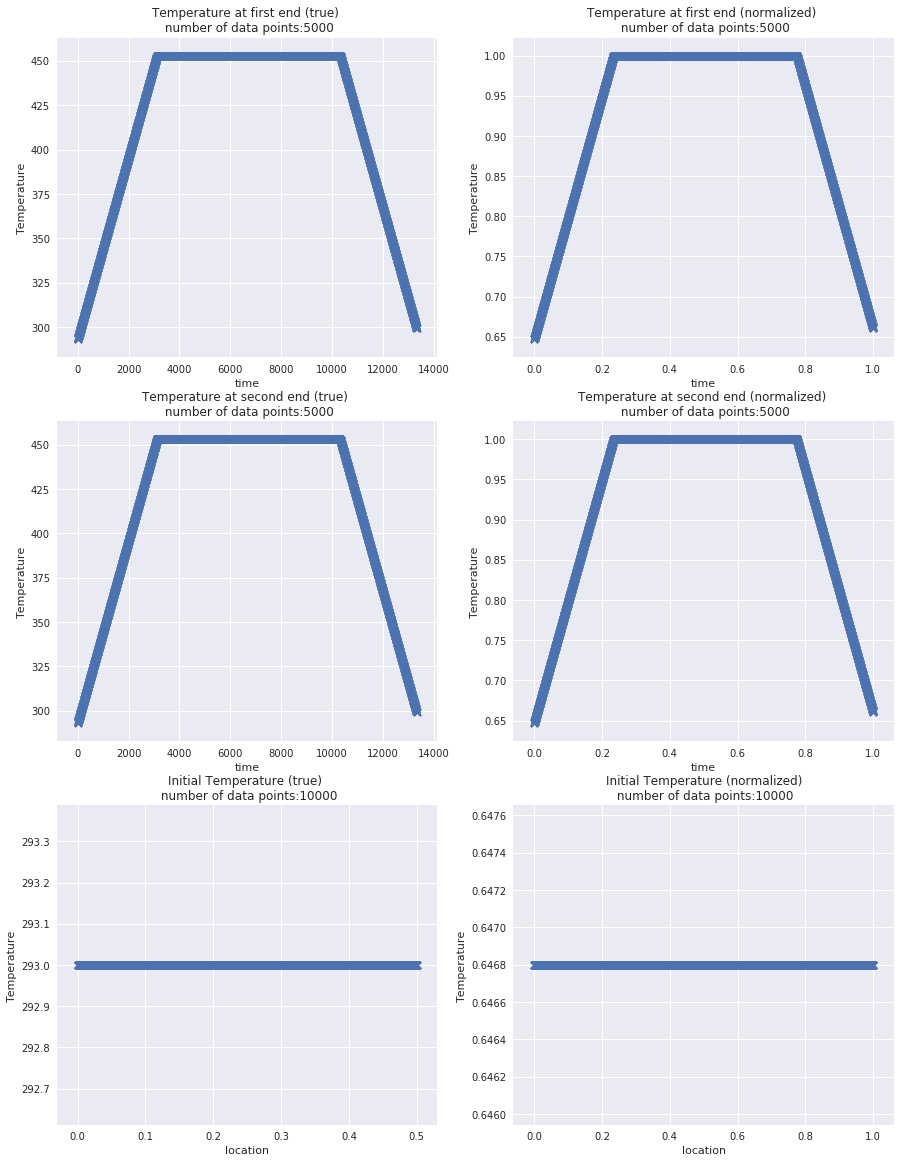

In [6]:
# plot boundary and initial conditions
plot_bcini_Temp(all_input_data)

# Neural Network Models
Consdtructiong and training a deep neural network model to solve heat trasnfer and cure kinetics differential equations in a sequntial approach. <br>
For full details see section 3 of <br>
* S. A. Niaki, E. Haghighat, X. Li, T. Campbell, and R. Vaziri, "Physics-Informed Neural Network for Modelling the Thermochemical Curing Process of Composite-Tool Systems During Manufacture", arXiv:2011.13511 (2020), https://arxiv.org/abs/2011.13511

## Networks

In [7]:
# initilizaers 
he = tf.keras.initializers.he_uniform()
random_uniform = tf.keras.initializers.RandomUniform()
# VS = tf.keras.initializers.VarianceScaling(distribution='uniform', mode='fan_avg', scale=1)
# VSig = tf.keras.initializers.VarianceScaling(distribution='truncated_normal', mode='fan_avg', scale=1)

In [8]:
# NN for resin reaction (degree of cure) problem (see Fig 4 of the paper)
def Alpha_PINN(input_shape):
    '''
    model input is the time 't' and location 'x'
    '''
    x_inputs = Input(shape=input_shape, name='x_inputs')
    t_inputs = Input(shape=input_shape, name='t_inputs')
    T_inputs = Input(shape=input_shape, name='T_inputs')
    T = tf.keras.backend.stop_gradient(T_inputs)
    
    nodes = 30
    h = Concatenate(axis=1)([x_inputs, t_inputs])
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    
    # degree of cure output
    output_alpha = Dense(1, kernel_initializer=random_uniform, activation=alpha_activation, name='out_alpha')(h)
        
    # losses
    ode_L = Lambda(ode_func, name='ode_L')([t_inputs, output_alpha, T, x_inputs]) # ODE loss
    inialpha_L = Lambda(inialpha_func, name='inialpha_L')([t_inputs, output_alpha, x_inputs]) # initial condition loss
    
    model = Model(inputs = [x_inputs, t_inputs, T_inputs],
                  outputs = [ode_L, inialpha_L])
    
    return model


In [9]:
# NN for heat trasnfer problem (see Fig 5 of the paper)
def Heat_PINN(input_shape):
    '''
    model input is the time 't' and location 'x'
    two disjoint netwerok (fig 5 of the paper for T- and T+)
    '''
    # inputs
    x_inputs = Input(shape=input_shape, name='x_inputs')
    t_inputs = Input(shape=input_shape, name='t_inputs')
    alpha_inputs = Input(shape=input_shape, name='alpha_inputs')
    alpha = tf.keras.backend.stop_gradient(alpha_inputs) # degree of cure from Alpha model
    
    nodes = 20 # in each part of the network
    # first part
    h = Concatenate(axis=1)([x_inputs, t_inputs])
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    f1 = Dense(1, kernel_initializer=random_uniform, activation='softplus')(h)
    # second part
    h = Concatenate(axis=1)([x_inputs, t_inputs])
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    h = Dense(nodes, kernel_initializer=he, activation='tanh')(h)
    f2 = Dense(1, kernel_initializer=random_uniform, activation='softplus')(h)
    # combination of two parts (temperature output)
    output_T = Lambda(T_out_func, name='out_T')([x_inputs, f1, f2]) # temperature output
    
    # losses
    pde_L_ct = Lambda(pde_func_ct, name='pde_L_ct')([x_inputs, t_inputs, output_T, alpha]) # PDE loss 
    bc_b_L = Lambda(bc_b_func, name='bc_b_L')([x_inputs, t_inputs, output_T]) # bc1 (bottom) loss 
    bc_t_L = Lambda(bc_t_func, name='bc_t_L')([x_inputs, t_inputs, output_T]) # bc2 (top) loss 
    iniT_L = Lambda(iniT_func, name='iniT_L')([x_inputs, t_inputs, output_T]) # initial condition loss     
    flux_d_L = Lambda(flux_d_func, name='flux_d_L')([x_inputs, f1, f2]) # flux continuity loss
    cont_d_L = Lambda(cont_d_func, name='cont_d_L')([x_inputs, f1, f2]) # temperatature continuity loss
    
    model = Model(inputs = [x_inputs, t_inputs, alpha_inputs],
                  outputs = [pde_L_ct,  bc_b_L, bc_t_L, iniT_L, flux_d_L, cont_d_L])
    
    return model


In [10]:
def T_out_func(LambdaList):
    '''
    temperature combination function from two disjoint networks in temp model
    '''
    x_inp = LambdaList[0]
    f1_inp = LambdaList[1]
    f2_inp = LambdaList[2]
    
    T_out = f1_inp  * 0.5 * (1.0 - tf.math.sign(x_inp-(L_t_bc_t_normalized+1e-15)) ) \
          + f2_inp  * 0.5 * (1.0 + tf.math.sign(x_inp-(L_t_bc_t_normalized+1e-15)) )
    
    return T_out


def alpha_activation(x):
    '''
    a modified sigmoid function for used for initial condition of degree of cure
    the function is changing from initial_alpha to maximum_alpha in a sigmoid form
    '''
    sig = (maximum_alpha-initial_alpha) * tf.math.sigmoid(x) + initial_alpha
    
    return sig


### Losses
Physics based losses for Alpha and Heat NN models

#### Alpha losses

In [11]:

# alpha ODE loss
def ode_func(LambdaList):
    
    t_inp = LambdaList[0]   
    out_alpha = LambdaList[1]
    pred_T =  LambdaList[2]
    x_inp = LambdaList[3]
    
    # gradients
    alphat = tf.gradients(out_alpha, t_inp) 

    # XX=1 where loss is applicable, XX=0 where loss is not applicable
    XX = 0.5 * (1.0+tf.math.sign(t_inp-scale_min2-1e-15)) \
        * 0.5 * (1.0 + tf.math.sign(x_inp-(L_t_bc_t_normalized-delxx/2+1e-15)) )
    
    alpha_RHSTOT = alpha_RHSTOT_func(pred_T, out_alpha, A_normalized,
                                 dE_normalized,
                                 M, N, ALCT_normalized, ALC,
                                 R_normalized)

    # correcting based on the nonzero number of points in the batch
    batch_size = tf.cast(tf.size(XX), tf.float64)
    nonzero_in_batch = tf.cast(tf.math.count_nonzero(XX), tf.float64) 
    chk = tf.cast(tf.math.count_nonzero(nonzero_in_batch), tf.float64)
    nonzero_in_batch = nonzero_in_batch * chk + coll_num* (L_t_bc- L_t_bc_t)/L_t_bc * (1.0-chk)
    batch_size = batch_size * chk + tot_num * (1.0-chk)
    correction =tf.math.sqrt(batch_size/nonzero_in_batch)
    
    L = (alphat[0] - alpha_RHSTOT) \
        * XX * math.sqrt(tot_num/(coll_num* (L_t_bc- L_t_bc_t)/L_t_bc)) #* correction 
    
    return L

# alpha initial condition loss
def inialpha_func(LambdaList):
    t_inp = LambdaList[0]
    out_alpha = LambdaList[1]
    x_inp = LambdaList[2]
    
    # XX=1 where loss is applicable, XX=0 where loss is not applicable
    XX = 0.5 * (1.0-tf.math.sign(t_inp-scale_min2-1e-15))\
        * 0.5 * (1.0 + tf.math.sign(x_inp-(L_t_bc_t_normalized-delxx/2+1e-15)) ) 
    
    # correcting based on the nonzero number of points in the batch
    batch_size = tf.cast(tf.size(XX), tf.float64)
    nonzero_in_batch = tf.cast(tf.math.count_nonzero(XX), tf.float64) 
    chk = tf.cast(tf.math.count_nonzero(nonzero_in_batch), tf.float64)
    nonzero_in_batch = nonzero_in_batch * chk + ini_num * (L_t_bc- L_t_bc_t)/L_t_bc * (1.0-chk)
    batch_size = batch_size * chk + tot_num * (1.0-chk)
    correction =tf.math.sqrt(batch_size/nonzero_in_batch)
    
    L = (out_alpha-initial_alpha) * XX * correction 
    
    return L


#### Temp (heat) losses

In [12]:
# Losses
delxx = (L_t-L_b)/(L_n-1) * scaler1[0,0]
tot_num = (2*bc_num+coll_num+ini_num)
pde_w_ct= tot_num/(coll_num)
pde_w_c= tot_num/(coll_num * (L_t_bc- L_t_bc_t)/(L_t_bc)) 
pde_w_t= tot_num/(coll_num * (L_t_bc_t)/(L_t_bc)) 
bc_b_w = tot_num/(bc_num)
bc_t_w = tot_num/(bc_num)
iniT_w = tot_num/ini_num
ode_w_c = (tot_num)/(coll_num * (L_t_bc- L_t_bc_t)/(L_t_bc)) 
inialpha_w_c = tot_num/ini_num

def alpha_RHSTOT_func(out_T, out_alpha, A,dE,M, N, ALCT, ALC,R):
    '''
    returns RHS of alpha ODE
    '''
    epsilon = 1e-16
    K = A * tf.math.exp(-dE/(R*out_T))
    
    alpha_RHSTOT = (K * (out_alpha)**M) * ((1.0-out_alpha)**N) / (1+tf.math.exp(C*(out_alpha-ALC-ALCT*out_T)))

    return alpha_RHSTOT

# heat transfer PDE loss
def pde_func_ct(LambdaList):
    x_inp = LambdaList[0]
    t_inp = LambdaList[1]
    out_T = LambdaList[2]
    pred_alpha = LambdaList[3]
    # gradients
    Tt = tf.gradients(out_T, t_inp)
    Tx = tf.gradients(out_T, x_inp)
    Txx = tf.gradients(Tx[0], x_inp) 
    
    # XX=1 where loss is applicable, XX=0 where loss is not applicable
    XX = 0.5 * (1.0+tf.math.sign(t_inp-scale_min2-1e-15)) \
       * 0.5 * (1.0+tf.math.sign(x_inp-scale_min1-1e-15)) \
       * 0.5 * (1.0-tf.math.sign(x_inp-scale_max1+1e-15)) 
    
    # correcting based on the nonzero number of points in the batch    
    batch_size = tf.cast(tf.size(XX), tf.float64)
    nonzero_in_batch = tf.cast(tf.math.count_nonzero(XX), tf.float64) 
    chk = tf.cast(tf.math.count_nonzero(nonzero_in_batch), tf.float64)
    nonzero_in_batch = nonzero_in_batch * chk + coll_num * (1.0-chk)
    batch_size = batch_size * chk + tot_num * (1.0-chk)
    correction =tf.math.sqrt(batch_size/nonzero_in_batch)
    
    # RHS function in ODE of degree of cure
    alpha_RHSTOT = alpha_RHSTOT_func(out_T, pred_alpha, A_normalized,
                                 dE_normalized,
                                 M, N, ALCT_normalized, ALC,
                                 R_normalized) 
    
    
    a_ct = a_c_normalized *  0.5 * (1.0 + tf.math.sign(x_inp-(L_t_bc_t_normalized+1e-15))) + a_t_normalized *  0.5 * (1.0 - tf.math.sign(x_inp-(L_t_bc_t_normalized+1e-15)))  
    b_ct = b_normalized *  0.5 * (1.0 + tf.math.sign(x_inp-(L_t_bc_t_normalized+1e-15)))
    
    L = (Tt[0] - a_ct * Txx[0]  - b_ct * alpha_RHSTOT) \
         * XX  * correction
              
    return L


# first boundary condition loss
def bc_b_func(LambdaList):
    x_inp = LambdaList[0]
    t_inp = LambdaList[1]
    output_T = LambdaList[2]
    
    T_bc_b = T_bc(temptypeb, t_inp, T_rate_b, T_s_b, T_hold_b, th1_b, th2_b, scaler2)
    T_bc_b = T_bc_b / T_scale
    
    # XX=1 where loss is applicable, XX=0 where loss is not applicable
    XX = 0.5 * (1.0-tf.math.sign(x_inp-scale_min1-1e-15)) 
        
    # correcting based on the nonzero number of points in the batch 
    batch_size = tf.cast(tf.size(XX), tf.float64)
    nonzero_in_batch = tf.cast(tf.math.count_nonzero(XX), tf.float64) 
    chk = tf.cast(tf.math.count_nonzero(nonzero_in_batch), tf.float64)
    nonzero_in_batch = nonzero_in_batch * chk + bc_num * (1.0-chk)
    batch_size = batch_size * chk + tot_num * (1.0-chk)
    correction =tf.math.sqrt(batch_size/nonzero_in_batch)
    
    if bc_typeb == 'prescribed':
        L = (output_T - T_bc_b) * XX * correction
    else: 
        Tx = tf.gradients(output_T, x_inp)
        L = ((T_bc_b - output_T) + k_t / h_t * Tx[0]  * scaler1[0,0]) * XX * correction 
        
    
    return L 

# second boundary condition loss
def bc_t_func(LambdaList):
    
    x_inp = LambdaList[0]
    t_inp = LambdaList[1]
    output_T = LambdaList[2]
    
    T_bc_t = T_bc(temptypet, t_inp, T_rate_t, T_s_t, T_hold_t, th1_t, th2_t, scaler2)
    T_bc_t = T_bc_t / T_scale
   
    # XX=1 where loss is applicable, XX=0 where loss is not applicable
    XX = 0.5 * (1.0+tf.math.sign(x_inp-scale_max1+1e-15))
        
    # correcting based on the nonzero number of points in the batch 
    batch_size = tf.cast(tf.size(XX), tf.float64)
    nonzero_in_batch = tf.cast(tf.math.count_nonzero(XX), tf.float64) 
    chk = tf.cast(tf.math.count_nonzero(nonzero_in_batch), tf.float64)
    nonzero_in_batch = nonzero_in_batch * chk + bc_num * (1.0-chk)
    batch_size = batch_size * chk + tot_num * (1.0-chk)
    correction =tf.math.sqrt(batch_size/nonzero_in_batch)
    
    
    if bc_typet == 'prescribed':
        L = (output_T - T_bc_t) * XX * correction 
    else:
        Tx = tf.gradients(output_T, x_inp)
        L = ((T_bc_t - output_T) - k_c / h_c * Tx[0]  * scaler1[0,0])  * XX * correction   


    return L 


# temperature initial condition loss
def iniT_func(LambdaList):
    
    x_inp = LambdaList[0]
    t_inp = LambdaList[1]
    output_T = LambdaList[2]
    
    T_ini_arr = t_inp * 0 + T_ini / T_scale
    
    # XX=1 where loss is applicable, XX=0 where loss is not applicable
    XX = 0.5 * (1.0-tf.math.sign(t_inp-scale_min2-1e-10)) \
       * 0.5 * (1.0+tf.math.sign(x_inp-scale_min1-1e-10))  \
       * 0.5 * (1.0 - tf.math.sign(x_inp-scale_max1+1e-10)) 
    
    # correcting based on the nonzero number of points in the batch
    batch_size = tf.cast(tf.size(XX), tf.float64)
    nonzero_in_batch = tf.cast(tf.math.count_nonzero(XX), tf.float64) 
    chk = tf.cast(tf.math.count_nonzero(nonzero_in_batch), tf.float64)
    nonzero_in_batch = nonzero_in_batch * chk + ini_num * (1.0-chk)
    batch_size = batch_size * chk + tot_num * (1.0-chk)
    correction =tf.math.sqrt(batch_size/nonzero_in_batch)
    
    L = (output_T - T_ini_arr) * XX * correction
   
    return L


# heat flux continuity loss
def flux_d_func(LambdaList):
    x_inp = LambdaList[0]
    f1_inp = LambdaList[1]
    f2_inp = LambdaList[2]
    
    # gradients
    f1x = tf.gradients(f1_inp, x_inp)
    f2x = tf.gradients(f2_inp, x_inp)
    
    # XX=1 where loss is applicable, XX=0 where loss is not applicable
    XX = 0.5 * (1.0 + tf.math.sign(x_inp-(L_t_bc_t_normalized-delxx/2+1e-15)) ) \
       * 0.5 * (1.0 - tf.math.sign(x_inp-(L_t_bc_t_normalized+delxx/2+1e-15)) )
        
    # correcting based on the nonzero number of points in the batch
    batch_size = tf.cast(tf.size(XX), tf.float64)
    nonzero_in_batch = tf.cast(tf.math.count_nonzero(XX), tf.float64) 
    chk = tf.cast(tf.math.count_nonzero(nonzero_in_batch), tf.float64)
    nonzero_in_batch = nonzero_in_batch * chk + time_n * (1.0-chk)
    batch_size = batch_size * chk + tot_num * (1.0-chk)
    correction =tf.math.sqrt(batch_size/nonzero_in_batch)
    
    k_t_norm = k_t   / (rho_t*Cp_t) * ((scaler1[0,0])**2)/scaler2[0,1] # scaling tool conductivity
    k_c_norm = k_c   / (rho_t*Cp_t) * ((scaler1[0,0])**2)/scaler2[0,1] # scaling composites conductivity
        
    L = ( k_t_norm* f1x[0] - k_c_norm *   f2x[0]) * XX *  correction

    return L

# temperature continuity loss
def cont_d_func(LambdaList):
    
    x_inp = LambdaList[0]
    f1_inp = LambdaList[1]
    f2_inp = LambdaList[2]

    # XX=1 where loss is applicable, XX=0 where loss is not applicable
    XX = 0.5 * (1.0 + tf.math.sign(x_inp-(L_t_bc_t_normalized-delxx/2+1e-15)) ) \
       * 0.5 * (1.0 - tf.math.sign(x_inp-(L_t_bc_t_normalized+delxx/2+1e-15)) )
    
    # correcting based on the nonzero number of points in the batch
    batch_size = tf.cast(tf.size(XX), tf.float64)
    nonzero_in_batch = tf.cast(tf.math.count_nonzero(XX), tf.float64) 
    chk = tf.cast(tf.math.count_nonzero(nonzero_in_batch), tf.float64)
    nonzero_in_batch = nonzero_in_batch * chk + time_n * (1.0-chk)
    batch_size = batch_size * chk + tot_num * (1.0-chk)
    correction =tf.math.sqrt(batch_size/nonzero_in_batch)
    
    L = (f1_inp- f2_inp) * XX * correction

    return L


#### creating Alpha and Heat models

In [13]:
Alpha_model = Alpha_PINN(input_shape=(1))
Alpha_model.summary()
tf.keras.utils.plot_model(Alpha_model, show_shapes=True)

# finding the layer number of alpha output in Alpha model
out_alpha_indx = None
for idx, layer in enumerate(Alpha_model.layers):
    if layer.name == 'out_alpha':
        out_alpha_indx = idx
        break

ValueError: None values not supported.

In [14]:
tf.keras.backend.clear_session()
Heat_model = Heat_PINN(input_shape=(1))
Heat_model.summary()
tf.keras.utils.plot_model(Heat_model, show_shapes=True)

# finding the layer number of Temp output in Heat model
out_T_indx = None
for idx, layer in enumerate(Heat_model.layers):
    if layer.name == 'out_T':
        out_T_indx = idx
        break

AttributeError: 'NoneType' object has no attribute 'op'

#### adaptive loss weights scheme

For full details see sections 3.4 and 4.2 of <br>
* S. A. Niaki, E. Haghighat, X. Li, T. Campbell, and R. Vaziri, "Physics-Informed Neural Network for Modelling the Thermochemical Curing Process of Composite-Tool Systems During Manufacture", arXiv:2011.13511 (2020), https://arxiv.org/abs/2011.13511

Main reference:  <br>
* S. Wang, Y. Teng, and P. Perdikaris. "Understanding and mitigating gradient pathologies in physics-informed neural networks." arXiv:2001.04536 (2020), https://arxiv.org/abs/2001.04536

In [15]:
@tf.function
def loss_grads(i, model, input_data_1, input_data_2, input_data_3):
    losses = model(inputs = [input_data_1, input_data_2, input_data_3])
    mse_losses = [tf.reduce_mean(li**2) for li in losses] # MSE loss values
    L_grads_i = tf.gradients(mse_losses[i], model.trainable_variables) # , unconnected_gradients='zero'
    trainable_count = tf.cast(model.count_params(), tf.float64) #int(np.sum([kb.count_params(p) for p in set(model.trainable_weights)]))
    
    return L_grads_i, trainable_count


def max_of_loss_grads(L_grads_i):
    max_for_network = max([tf.reduce_max(abs(L_grads_i[li])) for li in range(0,len(L_grads_i))])
    
    return max_for_network


def mean_of_loss_grads(L_grads_i, max_for_network, lambda_i_old, trainable_count):
    mean_for_each_layer = [tf.reduce_mean(abs(L_grads_i[li])) for li in range(0,len(L_grads_i))]
    mean_for_network= sum(mean_for_each_layer) / len(mean_for_each_layer) # number of paramte
    lambda_i = max_for_network / (mean_for_network * lambda_i_old)
    
    return lambda_i
    
def update_weights(lambda_i_old, lambda_i):
    lambda_i_new =  0.9 *lambda_i_old + (1-0.9) * lambda_i
    
    return lambda_i_new

 
# call back for alpha loss weight             
class MyCallback_alpha(tf.keras.callbacks.Callback):
    def __init__(self, ode_loss_weight, inialpha_loss_weight):
        self.ode_loss_weight = ode_loss_weight
        self.inialpha_loss_weight = inialpha_loss_weight
        self.ode_loss_weight_history = ode_loss_weight_history
        self.inialpha_loss_weight_history = inialpha_loss_weight_history
        

        tf.print('++++++++++++++++++++++++++')
        tf.print('Loss weights are')
        tf.print(self.ode_loss_weight, self.inialpha_loss_weight)
        tf.print('++++++++++++++++++++++++++')
    # customize your behavior  number_of_epochs_it_ran2==0
    def on_epoch_end(self, epoch, logs={}):
        if epoch==0:
            grads_of_ode, trainable_count = loss_grads(0, Alpha_model, input_train_x_np, input_train_t_np, pred_T)
            max_of_ode_grads = max_of_loss_grads(grads_of_ode)            
            ode_loss_new_weight = ode_loss_weight
            
            grads_of_inialpha_L, trainable_count = loss_grads(1, Alpha_model, input_train_x_np, input_train_t_np, pred_T)
            inialpha_loss_lambda = mean_of_loss_grads(grads_of_inialpha_L, max_of_ode_grads, inialpha_loss_weight, trainable_count)
            
            inialpha_loss_new_weight = update_weights(inialpha_loss_weight, inialpha_loss_lambda)

            kb.set_value(self.ode_loss_weight , ode_loss_new_weight)
            kb.set_value(self.inialpha_loss_weight , inialpha_loss_new_weight)

            self.ode_loss_weight_history.extend([ode_loss_new_weight])
            self.inialpha_loss_weight_history.extend([inialpha_loss_new_weight])

            tf.print('++++++++++++++++++++++++++')
            tf.print('Loss weights are')
            tf.print(self.ode_loss_weight, self.inialpha_loss_weight)
            tf.print('++++++++++++++++++++++++++')
            
# call back for Temp adaptive loss weights
class MyCallback_T(tf.keras.callbacks.Callback):
    def __init__(self, pde_ct_loss_weight, bc_b_loss_weight, bc_t_loss_weight, iniT_loss_weight, flux_d_loss_weight, cont_d_loss_weight):
        self.pde_ct_loss_weight = pde_ct_loss_weight
        self.bc_b_loss_weight = bc_b_loss_weight
        self.bc_t_loss_weight = bc_t_loss_weight
        self.iniT_loss_weight = iniT_loss_weight
        self.flux_d_loss_weight = flux_d_loss_weight
        self.cont_d_loss_weight = cont_d_loss_weight
        
        self.pde_loss_weight_history = pde_loss_weight_history
        self.bc_b_loss_weight_history = bc_b_loss_weight_history
        self.bc_t_loss_weight_history = bc_t_loss_weight_history
        self.iniT_loss_weight_history = iniT_loss_weight_history
        self.flux_d_loss_weight_history = flux_d_loss_weight_history
        self.cont_d_loss_weight_history = cont_d_loss_weight_history
    
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        
        if epoch==0:
            grads_of_pde, trainable_count = loss_grads(0, Heat_model, input_train_x_np, input_train_t_np, pred_alpha)
            max_of_pde_grads = max_of_loss_grads(grads_of_pde)
            pde_ct_loss_new_weight = pde_ct_loss_weight

            grads_of_bc_b_L, trainable_count = loss_grads(1, Heat_model, input_train_x_np, input_train_t_np, pred_alpha)
            bc_b_loss_lambda = mean_of_loss_grads(grads_of_bc_b_L, max_of_pde_grads, bc_b_loss_weight, trainable_count)
            bc_b_loss_new_weight = update_weights(bc_b_loss_weight, bc_b_loss_lambda)

            grads_of_bc_t_L, trainable_count = loss_grads(2, Heat_model, input_train_x_np, input_train_t_np, pred_alpha)
            bc_t_loss_lambda = mean_of_loss_grads(grads_of_bc_t_L, max_of_pde_grads, bc_t_loss_weight, trainable_count)
            bc_t_loss_new_weight = update_weights(bc_t_loss_weight, bc_t_loss_lambda)

            grads_of_iniT_L, trainable_count = loss_grads(3, Heat_model, input_train_x_np, input_train_t_np, pred_alpha)
            iniT_loss_lambda = mean_of_loss_grads(grads_of_iniT_L, max_of_pde_grads, iniT_loss_weight, trainable_count)
            iniT_loss_new_weight = update_weights(iniT_loss_weight, iniT_loss_lambda)

            flux_d_loss_new_weight = flux_d_loss_weight

            grads_of_cont_d_L, trainable_count = loss_grads(5, Heat_model, input_train_x_np, input_train_t_np, pred_alpha)
            cont_d_loss_lambda = mean_of_loss_grads(grads_of_cont_d_L, max_of_pde_grads, cont_d_loss_weight, trainable_count)
            cont_d_loss_new_weight = update_weights(cont_d_loss_weight, cont_d_loss_lambda)

            kb.set_value(self.pde_ct_loss_weight, pde_ct_loss_new_weight)
            kb.set_value(self.bc_b_loss_weight , bc_b_loss_new_weight)
            kb.set_value(self.bc_t_loss_weight , bc_t_loss_new_weight)
            kb.set_value(self.iniT_loss_weight , iniT_loss_new_weight)
            kb.set_value(self.flux_d_loss_weight , flux_d_loss_new_weight)
            kb.set_value(self.cont_d_loss_weight , cont_d_loss_new_weight)

            self.pde_loss_weight_history.extend([pde_ct_loss_new_weight])
            self.bc_b_loss_weight_history.extend([bc_b_loss_new_weight])
            self.bc_t_loss_weight_history.extend([bc_t_loss_new_weight])
            self.iniT_loss_weight_history.extend([iniT_loss_new_weight])
            self.flux_d_loss_weight_history.extend([flux_d_loss_new_weight])
            self.cont_d_loss_weight_history.extend([cont_d_loss_new_weight])

            tf.print('++++++++++++++++++++++++++')
            tf.print('Loss weights are')
            tf.print(self.pde_ct_loss_weight, self.bc_b_loss_weight, self.bc_t_loss_weight, self.iniT_loss_weight, self.flux_d_loss_weight, self.cont_d_loss_weight)
            tf.print('++++++++++++++++++++++++++')

           

## Training

#### optimizers details

In [16]:
# for alpha
# optimizer
opt_alpha = tf.keras.optimizers.Adam(learning_rate=1e-3)
# initial loss weights
ode_loss_weight = kb.variable(1.0)
inialpha_loss_weight = kb.variable(1.0)
Alpha_model.compile(loss=['mse', 'mse'],
                    loss_weights=[ode_loss_weight, inialpha_loss_weight],
                    optimizer=opt_alpha)

# for Temp
# optimizer
opt_T = tf.keras.optimizers.Adam(learning_rate=1e-3)
# initial loss weights
pde_ct_loss_weight = kb.variable(1.0)
bc_b_loss_weight = kb.variable(1.0)
bc_t_loss_weight = kb.variable(1.0)
iniT_loss_weight = kb.variable(1.0)
flux_d_loss_weight = kb.variable(1.0)
cont_d_loss_weight = kb.variable(1.0)
# compile
Heat_model.compile(loss=['mse', 'mse', 'mse', 'mse', 'mse', 'mse'],
                   loss_weights=[pde_ct_loss_weight, bc_b_loss_weight, bc_t_loss_weight, iniT_loss_weight,
                                 flux_d_loss_weight, cont_d_loss_weight],
                   optimizer=opt_T)

NameError: name 'Alpha_model' is not defined

#### checkpoints

In [47]:
case_info_text_alpha = 'alpha_tool_'+str(round(L_t_bc_t,2))+bc_typeb+'_comp_'+str(round(L_t_bc-L_t_bc_t,2))+bc_typet
case_info_text_T = 'T_tool_'+str(round(L_t_bc_t,2))+bc_typeb+'_comp_'+str(round(L_t_bc-L_t_bc_t,2))+bc_typet

checkpoint_path_alpha = 'Trained_Models\_'+case_info_text_alpha+'\checkpoint'
checkpoint_path_T = 'Trained_Models\_'+case_info_text_T+'\checkpoint'
alpha_epochs = 30 # number of epochs for alpha training
T_epochs = 30 # number of epochs for temp training

checkpoint_alpha = ModelCheckpoint(checkpoint_path_alpha,
                             save_weights_only=True,
                             monitor='loss',
                             verbose=1,
                             save_best_only=True)

checkpoint_T = ModelCheckpoint(checkpoint_path_T,
                             save_weights_only=True,
                             monitor='loss',
                             verbose=1,
                             save_best_only=True)

#### callbacks

In [18]:
# stop training for total loss less than a critical value
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        Loss = logs["loss"]
        if Loss <= self.threshold:
            self.model.stop_training = True

threshold_alpha=MyThresholdCallback(threshold=1e-9) 
threshold_T=MyThresholdCallback(threshold=1e-9) 

In [19]:
# learning rate schedule
patience_alpha = 20
patience_T = 20

reduce_lr_alpha = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                 factor=0.5, patience=patience_alpha,
                                                 verbose=0, mode='auto',
                                                 min_delta=0.0001, cooldown=0, min_lr=1e-8)

reduce_lr_T = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                 factor=0.5, patience=patience_T,
                                                 verbose=0, mode='auto',
                                                 min_delta=0.0001, cooldown=0, min_lr=1e-8)

EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1500) 

In [20]:
# batch sizes
batch_size_alpha = 512
batch_size_T = 512

#### sequential tranining

In [21]:
tot_iteration = 10 # total number of iterative training

# start temperature for first iteration of Alpha model training 
pred_T_b = T_bc(temptypeb, input_train_t_normalized, T_rate_b, T_s_b, T_hold_b, th1_b, th2_b, scaler2)/T_scale 
pred_T_t = T_bc(temptypet, input_train_t_normalized, T_rate_t, T_s_t, T_hold_t, th1_t, th2_t, scaler2)/T_scale
x_reshaped = np.reshape(input_train_x_normalized, (input_train_x_normalized.shape[0], 1))
pred_T = (1.0-(x_reshaped)**2 * 1.0) * pred_T_b + ((x_reshaped)**2  * 1.0) * pred_T_t

start = timeit.default_timer() 

input_train_x_np = np.reshape(input_train_x_normalized, (input_train_x_normalized.shape[0], 1))
input_train_t_np = np.reshape(input_train_t_normalized, (input_train_t_normalized.shape[0], 1))

# keeping history of losses
alpha_total_loss_history = []
ode_loss_history = []
inialpha_loss_history = []
T_total_loss_history = []
pde_loss_history = []
bc_b_loss_history = []
bc_t_loss_history = []
iniT_loss_history = []
flux_d_loss_history = []
cont_d_loss_history = []
# keeping history of loss wights
pde_loss_weight_history = []
bc_b_loss_weight_history = []
bc_t_loss_weight_history = []
iniT_loss_weight_history = []
flux_d_loss_weight_history = []
cont_d_loss_weight_history = []
ode_loss_weight_history = []
inialpha_loss_weight_history = []

number_of_epochs_it_ran1 = 0
number_of_epochs_it_ran2 = 0
xxx = 0
yyy = 0
for i in range(0,tot_iteration):
    if xxx == 0 or yyy == 0:
        print('\n \n \n')
        print('Step:', i+1)
        print('************************* ALPHA ALPHA ALPHA ALPHA ALPHA ***********************')
        
        # in the scond iteration, recompile the alpha model (inhance the training of alpha as pred_T is more realistic now)
        if i==1:
            Alpha_model = Alpha_PINN(input_shape=(1))
            ode_loss_weight = kb.variable(1.0)
            inialpha_loss_weight = kb.variable(1.0)
            Alpha_model.compile(loss=['mse', 'mse'],loss_weights=[ode_loss_weight, inialpha_loss_weight],
                                optimizer=opt_alpha)
            
        history_Alpha = Alpha_model.fit({'x_inputs':input_train_x_normalized,'t_inputs':input_train_t_normalized,
                                         'T_inputs':pred_T},
                                        {'ode_L':y_train,'inialpha_L':y_train},
                                        batch_size=batch_size_alpha,
                                        epochs=alpha_epochs,
                                        verbose=1,
                                        callbacks=[threshold_alpha, reduce_lr_alpha, checkpoint_alpha, EarlyStop,
                                                   MyCallback_alpha(ode_loss_weight, inialpha_loss_weight)])
        
        alpha_total_loss_history.extend(history_Alpha.history['loss'])
        ode_loss_history.extend(history_Alpha.history['ode_L_loss'])
        inialpha_loss_history.extend(history_Alpha.history['inialpha_L_loss'])
        
        inp = Alpha_model.input  
        functors = kb.function([inp], Alpha_model.layers[out_alpha_indx].output)
        pred_alpha = functors([input_train_x_np, input_train_t_np, pred_T])
        pred_alpha = tf.convert_to_tensor(pred_alpha[:,0])
        pred_alpha =pred_alpha.numpy()
        pred_alpha = np.reshape(pred_alpha, (pred_alpha.shape[0], 1))
        
    number_of_epochs_it_ran2 = len(history_Alpha.history['loss'])
    yyy = number_of_epochs_it_ran2 % alpha_epochs

    if xxx == 0 or yyy == 0:
        print('\n \n \n')
        print('Step:', i+1)
        print('************************* TEMP TEMP TEMP TEMP TEMP ***********************')
        history_Heat = Heat_model.fit({'x_inputs':input_train_x_normalized,'t_inputs':input_train_t_normalized,
                                       'alpha_inputs':pred_alpha},
                                      {'pde_L_ct':y_train,
                                       'bc_b_L':y_train, 'bc_t_L':y_train,'iniT_L':y_train,
                                       'flux_d_L':y_train, 'cont_d_L':y_train},
                                      batch_size=batch_size_T,
                                      epochs=T_epochs,
                                      verbose=1,
                                      callbacks=[threshold_T, reduce_lr_T, checkpoint_T, EarlyStop,
                                                 MyCallback_T(pde_ct_loss_weight, bc_b_loss_weight, bc_t_loss_weight, iniT_loss_weight, flux_d_loss_weight, cont_d_loss_weight)])

        T_total_loss_history.extend(history_Heat.history['loss'])
        pde_loss_history.extend(history_Heat.history['pde_L_ct_loss'])
        bc_b_loss_history.extend(history_Heat.history['bc_b_L_loss'])
        bc_t_loss_history.extend(history_Heat.history['bc_t_L_loss'])
        iniT_loss_history.extend(history_Heat.history['iniT_L_loss'])
        flux_d_loss_history.extend(history_Heat.history['flux_d_L_loss'])
        cont_d_loss_history.extend(history_Heat.history['cont_d_L_loss'])
        
        inp = Heat_model.input  
        functors = kb.function([inp], Heat_model.layers[out_T_indx].output)
        pred_T = functors([input_train_x_np, input_train_t_np, pred_alpha])
        pred_T = tf.convert_to_tensor(pred_T[:,0])
        pred_T =pred_T.numpy()
        pred_T = np.reshape(pred_T, (pred_T.shape[0], 1))

    number_of_epochs_it_ran1 = len(history_Heat.history['loss'])
    xxx = number_of_epochs_it_ran1 % T_epochs

    stop = timeit.default_timer()
    print('\n \n')
    print('Run time so far: ', round(stop - start,2),'(s) .....', round((stop - start)/60,2), '(min)')
        

    if xxx > 0 and yyy > 0:
        break

print('SOLUTION IS DONE!')

stop = timeit.default_timer()

print('Run time: ', round(stop - start,2),'(s) .....', round((stop - start)/60,2), '(min)')



 
 

Step: 1
************************* ALPHA ALPHA ALPHA ALPHA ALPHA ***********************
++++++++++++++++++++++++++
Loss weights are
1 1
++++++++++++++++++++++++++
Epoch 1/30
 997/1016 [============================>.] - ETA: 0s - loss: 0.1265 - ode_L_loss: 0.0735 - inialpha_L_loss: 0.0530
Epoch 00001: loss improved from inf to 0.12431, saving model to alpha_tool_0.2prescribed_comp_0.3prescribed\checkpoint
++++++++++++++++++++++++++
Loss weights are
1 9.1210684792956265
++++++++++++++++++++++++++
1016/1016 [==============================] - 6s 6ms/step - loss: 0.1243 - ode_L_loss: 0.0722 - inialpha_L_loss: 0.0521
Epoch 2/30
1001/1016 [============================>.] - ETA: 0s - loss: 0.0145 - ode_L_loss: 0.0039 - inialpha_L_loss: 0.0012
Epoch 00002: loss improved from 0.12431 to 0.01440, saving model to alpha_tool_0.2prescribed_comp_0.3prescribed\checkpoint
1016/1016 [==============================] - 3s 3ms/step - loss: 0.0144 - ode_L_loss: 0.0039 - inialpha_L_loss: 0.0012
Epoch 3

Epoch 25/30
1009/1016 [============================>.] - ETA: 0s - loss: 3.8776e-04 - ode_L_loss: 3.5997e-04 - inialpha_L_loss: 3.0478e-06
Epoch 00025: loss improved from 0.00048 to 0.00039, saving model to alpha_tool_0.2prescribed_comp_0.3prescribed\checkpoint
1016/1016 [==============================] - 3s 3ms/step - loss: 3.9044e-04 - ode_L_loss: 3.6265e-04 - inialpha_L_loss: 3.0472e-06
Epoch 26/30
1008/1016 [============================>.] - ETA: 0s - loss: 6.1511e-04 - ode_L_loss: 5.8880e-04 - inialpha_L_loss: 2.8849e-06
Epoch 00026: loss did not improve from 0.00039
1016/1016 [==============================] - 3s 3ms/step - loss: 6.1164e-04 - ode_L_loss: 5.8533e-04 - inialpha_L_loss: 2.8843e-06
Epoch 27/30
1002/1016 [============================>.] - ETA: 0s - loss: 6.4232e-04 - ode_L_loss: 6.1722e-04 - inialpha_L_loss: 2.7521e-06
Epoch 00027: loss did not improve from 0.00039
1016/1016 [==============================] - 3s 3ms/step - loss: 6.3950e-04 - ode_L_loss: 6.1441e-04 - i

Epoch 8/30
1006/1016 [============================>.] - ETA: 0s - loss: 0.0018 - pde_L_ct_loss: 4.2341e-04 - bc_b_L_loss: 1.1908e-04 - bc_t_L_loss: 6.4661e-04 - iniT_L_loss: 2.6476e-05 - flux_d_L_loss: 2.5582e-05 - cont_d_L_loss: 1.0254e-04
Epoch 00008: loss did not improve from 0.00154
1016/1016 [==============================] - 4s 4ms/step - loss: 0.0018 - pde_L_ct_loss: 4.2121e-04 - bc_b_L_loss: 1.1836e-04 - bc_t_L_loss: 6.4148e-04 - iniT_L_loss: 2.6281e-05 - flux_d_L_loss: 2.5453e-05 - cont_d_L_loss: 1.0203e-04
Epoch 9/30
1006/1016 [============================>.] - ETA: 0s - loss: 0.0017 - pde_L_ct_loss: 4.1173e-04 - bc_b_L_loss: 1.3959e-04 - bc_t_L_loss: 5.1861e-04 - iniT_L_loss: 2.5069e-05 - flux_d_L_loss: 2.3031e-05 - cont_d_L_loss: 1.1633e-04
Epoch 00009: loss did not improve from 0.00154
1016/1016 [==============================] - 4s 4ms/step - loss: 0.0016 - pde_L_ct_loss: 4.0957e-04 - bc_b_L_loss: 1.3867e-04 - bc_t_L_loss: 5.1413e-04 - iniT_L_loss: 2.4903e-05 - flux_d_L_l

Epoch 23/30
1007/1016 [============================>.] - ETA: 0s - loss: 8.3013e-04 - pde_L_ct_loss: 1.9801e-04 - bc_b_L_loss: 5.8171e-05 - bc_t_L_loss: 2.7054e-04 - iniT_L_loss: 1.2413e-05 - flux_d_L_loss: 1.1625e-05 - cont_d_L_loss: 6.7872e-05
Epoch 00023: loss did not improve from 0.00051
1016/1016 [==============================] - 4s 4ms/step - loss: 8.2551e-04 - pde_L_ct_loss: 1.9698e-04 - bc_b_L_loss: 5.8107e-05 - bc_t_L_loss: 2.6881e-04 - iniT_L_loss: 1.2326e-05 - flux_d_L_loss: 1.1734e-05 - cont_d_L_loss: 6.7308e-05
Epoch 24/30
1015/1016 [============================>.] - ETA: 0s - loss: 5.3361e-04 - pde_L_ct_loss: 1.1781e-04 - bc_b_L_loss: 4.6435e-05 - bc_t_L_loss: 1.8681e-04 - iniT_L_loss: 6.5600e-06 - flux_d_L_loss: 8.5803e-06 - cont_d_L_loss: 2.6940e-05
Epoch 00024: loss did not improve from 0.00051
1016/1016 [==============================] - 4s 4ms/step - loss: 5.3510e-04 - pde_L_ct_loss: 1.1790e-04 - bc_b_L_loss: 4.6411e-05 - bc_t_L_loss: 1.8776e-04 - iniT_L_loss: 6.556

1007/1016 [============================>.] - ETA: 0s - loss: 0.0073 - pde_L_ct_loss: 0.0022 - bc_b_L_loss: 5.3939e-05 - bc_t_L_loss: 4.8120e-04 - iniT_L_loss: 9.0033e-06 - flux_d_L_loss: 3.0370e-04 - cont_d_L_loss: 5.4038e-05
Epoch 00003: loss did not improve from 0.00034
1016/1016 [==============================] - 4s 4ms/step - loss: 0.0073 - pde_L_ct_loss: 0.0022 - bc_b_L_loss: 5.3593e-05 - bc_t_L_loss: 4.7863e-04 - iniT_L_loss: 9.0381e-06 - flux_d_L_loss: 3.0141e-04 - cont_d_L_loss: 5.3926e-05
Epoch 4/30
1009/1016 [============================>.] - ETA: 0s - loss: 0.0051 - pde_L_ct_loss: 0.0012 - bc_b_L_loss: 5.4005e-05 - bc_t_L_loss: 2.9261e-04 - iniT_L_loss: 7.9513e-06 - flux_d_L_loss: 9.1232e-05 - cont_d_L_loss: 5.0867e-05
Epoch 00004: loss did not improve from 0.00034
1016/1016 [==============================] - 4s 4ms/step - loss: 0.0051 - pde_L_ct_loss: 0.0012 - bc_b_L_loss: 5.4134e-05 - bc_t_L_loss: 2.9148e-04 - iniT_L_loss: 8.0810e-06 - flux_d_L_loss: 9.1218e-05 - cont_d_L_

Epoch 19/30
1008/1016 [============================>.] - ETA: 0s - loss: 0.0032 - pde_L_ct_loss: 7.6444e-04 - bc_b_L_loss: 3.4681e-05 - bc_t_L_loss: 1.6130e-04 - iniT_L_loss: 4.5697e-06 - flux_d_L_loss: 2.7037e-05 - cont_d_L_loss: 4.0411e-05
Epoch 00019: loss did not improve from 0.00034
1016/1016 [==============================] - 4s 4ms/step - loss: 0.0032 - pde_L_ct_loss: 7.6084e-04 - bc_b_L_loss: 3.4442e-05 - bc_t_L_loss: 1.6047e-04 - iniT_L_loss: 4.5410e-06 - flux_d_L_loss: 2.6971e-05 - cont_d_L_loss: 4.0190e-05
Epoch 20/30
1011/1016 [============================>.] - ETA: 0s - loss: 0.0031 - pde_L_ct_loss: 6.4543e-04 - bc_b_L_loss: 4.8857e-05 - bc_t_L_loss: 1.0160e-04 - iniT_L_loss: 3.8293e-06 - flux_d_L_loss: 1.9321e-05 - cont_d_L_loss: 3.2203e-05
Epoch 00020: loss did not improve from 0.00034
1016/1016 [==============================] - 4s 4ms/step - loss: 0.0031 - pde_L_ct_loss: 6.4444e-04 - bc_b_L_loss: 4.9319e-05 - bc_t_L_loss: 1.0129e-04 - iniT_L_loss: 3.8250e-06 - flux_d_L

Epoch 2/30
1010/1016 [============================>.] - ETA: 0s - loss: 7.3166e-04 - pde_L_ct_loss: 1.7526e-04 - bc_b_L_loss: 9.3950e-06 - bc_t_L_loss: 2.5068e-05 - iniT_L_loss: 9.9684e-07 - flux_d_L_loss: 6.2142e-06 - cont_d_L_loss: 1.0629e-05
Epoch 00002: loss did not improve from 0.00034
1016/1016 [==============================] - 4s 4ms/step - loss: 7.2951e-04 - pde_L_ct_loss: 1.7478e-04 - bc_b_L_loss: 9.3584e-06 - bc_t_L_loss: 2.5004e-05 - iniT_L_loss: 9.9368e-07 - flux_d_L_loss: 6.1830e-06 - cont_d_L_loss: 1.0615e-05
Epoch 3/30
1015/1016 [============================>.] - ETA: 0s - loss: 8.4726e-04 - pde_L_ct_loss: 1.6801e-04 - bc_b_L_loss: 1.1775e-05 - bc_t_L_loss: 3.3094e-05 - iniT_L_loss: 1.0800e-06 - flux_d_L_loss: 6.1738e-06 - cont_d_L_loss: 1.1338e-05
Epoch 00003: loss did not improve from 0.00034
1016/1016 [==============================] - 4s 4ms/step - loss: 8.4747e-04 - pde_L_ct_loss: 1.6804e-04 - bc_b_L_loss: 1.1768e-05 - bc_t_L_loss: 3.3142e-05 - iniT_L_loss: 1.0824e

1010/1016 [============================>.] - ETA: 0s - loss: 0.0043 - ode_L_loss: 0.0034 - inialpha_L_loss: 4.6415e-08
Epoch 00002: loss did not improve from 0.00039
1016/1016 [==============================] - 3s 3ms/step - loss: 0.0043 - ode_L_loss: 0.0033 - inialpha_L_loss: 4.6234e-08
Epoch 3/30
1007/1016 [============================>.] - ETA: 0s - loss: 0.0022 - ode_L_loss: 0.0020 - inialpha_L_loss: 9.5971e-09
Epoch 00003: loss did not improve from 0.00039
1016/1016 [==============================] - 3s 3ms/step - loss: 0.0022 - ode_L_loss: 0.0020 - inialpha_L_loss: 9.5741e-09
Epoch 4/30
1012/1016 [============================>.] - ETA: 0s - loss: 0.0118 - ode_L_loss: 0.0117 - inialpha_L_loss: 7.0429e-09
Epoch 00004: loss did not improve from 0.00039
1016/1016 [==============================] - 3s 3ms/step - loss: 0.0118 - ode_L_loss: 0.0116 - inialpha_L_loss: 7.0353e-09
Epoch 5/30
 998/1016 [============================>.] - ETA: 0s - loss: 0.0024 - ode_L_loss: 0.0023 - inialpha_

Epoch 29/30
1008/1016 [============================>.] - ETA: 0s - loss: 0.0022 - ode_L_loss: 0.0022 - inialpha_L_loss: 5.8365e-10
Epoch 00029: loss did not improve from 0.00028
1016/1016 [==============================] - 3s 3ms/step - loss: 0.0022 - ode_L_loss: 0.0022 - inialpha_L_loss: 5.8367e-10
Epoch 30/30
1002/1016 [============================>.] - ETA: 0s - loss: 8.3705e-04 - ode_L_loss: 8.2534e-04 - inialpha_L_loss: 5.6283e-10
Epoch 00030: loss did not improve from 0.00028
1016/1016 [==============================] - 3s 3ms/step - loss: 8.2730e-04 - ode_L_loss: 8.1559e-04 - inialpha_L_loss: 5.6262e-10

 
 

Step: 4
************************* TEMP TEMP TEMP TEMP TEMP ***********************
Epoch 1/30
1011/1016 [============================>.] - ETA: 0s - loss: 6.2221e-04 - pde_L_ct_loss: 2.0933e-04 - bc_b_L_loss: 5.6914e-06 - bc_t_L_loss: 2.5397e-05 - iniT_L_loss: 7.8724e-07 - flux_d_L_loss: 5.5189e-06 - cont_d_L_loss: 6.6120e-06
Epoch 00001: loss did not improve from 0.00032
+

Epoch 15/30
1005/1016 [============================>.] - ETA: 0s - loss: 7.2276e-04 - pde_L_ct_loss: 1.7037e-04 - bc_b_L_loss: 9.4642e-06 - bc_t_L_loss: 2.9914e-05 - iniT_L_loss: 9.2329e-07 - flux_d_L_loss: 6.5920e-06 - cont_d_L_loss: 9.8685e-06
Epoch 00015: loss did not improve from 0.00031
1016/1016 [==============================] - 5s 5ms/step - loss: 7.2116e-04 - pde_L_ct_loss: 1.7000e-04 - bc_b_L_loss: 9.4157e-06 - bc_t_L_loss: 2.9631e-05 - iniT_L_loss: 9.1636e-07 - flux_d_L_loss: 6.5278e-06 - cont_d_L_loss: 1.0127e-05
Epoch 16/30
1013/1016 [============================>.] - ETA: 0s - loss: 5.1776e-04 - pde_L_ct_loss: 1.1471e-04 - bc_b_L_loss: 8.0965e-06 - bc_t_L_loss: 1.7790e-05 - iniT_L_loss: 5.6564e-07 - flux_d_L_loss: 5.7583e-06 - cont_d_L_loss: 7.4036e-06
Epoch 00016: loss did not improve from 0.00031
1016/1016 [==============================] - 4s 4ms/step - loss: 5.1749e-04 - pde_L_ct_loss: 1.1473e-04 - bc_b_L_loss: 8.0849e-06 - bc_t_L_loss: 1.7780e-05 - iniT_L_loss: 5.651

Epoch 25/30
1002/1016 [============================>.] - ETA: 0s - loss: 4.6519e-04 - ode_L_loss: 4.5938e-04 - inialpha_L_loss: 2.7893e-10
Epoch 00025: loss did not improve from 0.00020
1016/1016 [==============================] - 3s 3ms/step - loss: 4.6064e-04 - ode_L_loss: 4.5484e-04 - inialpha_L_loss: 2.7878e-10
Epoch 26/30
1006/1016 [============================>.] - ETA: 0s - loss: 0.0023 - ode_L_loss: 0.0023 - inialpha_L_loss: 2.8043e-10
Epoch 00026: loss did not improve from 0.00020
1016/1016 [==============================] - 3s 3ms/step - loss: 0.0023 - ode_L_loss: 0.0023 - inialpha_L_loss: 2.8020e-10
Epoch 27/30
1005/1016 [============================>.] - ETA: 0s - loss: 6.1599e-04 - ode_L_loss: 6.1032e-04 - inialpha_L_loss: 2.7237e-10
Epoch 00027: loss did not improve from 0.00020
1016/1016 [==============================] - 3s 3ms/step - loss: 6.3226e-04 - ode_L_loss: 6.2659e-04 - inialpha_L_loss: 2.7232e-10
Epoch 28/30
1002/1016 [============================>.] - ETA: 0s 

1016/1016 [==============================] - ETA: 0s - loss: 8.0688e-05 - pde_L_ct_loss: 2.3687e-05 - bc_b_L_loss: 7.5660e-07 - bc_t_L_loss: 3.2125e-06 - iniT_L_loss: 7.6584e-08 - flux_d_L_loss: 4.1299e-06 - cont_d_L_loss: 1.2003e-06
Epoch 00027: loss did not improve from 0.00006
1016/1016 [==============================] - 4s 4ms/step - loss: 8.0688e-05 - pde_L_ct_loss: 2.3687e-05 - bc_b_L_loss: 7.5660e-07 - bc_t_L_loss: 3.2125e-06 - iniT_L_loss: 7.6584e-08 - flux_d_L_loss: 4.1299e-06 - cont_d_L_loss: 1.2003e-06
Epoch 28/30
1013/1016 [============================>.] - ETA: 0s - loss: 9.1074e-05 - pde_L_ct_loss: 2.3003e-05 - bc_b_L_loss: 1.3017e-06 - bc_t_L_loss: 2.9391e-06 - iniT_L_loss: 8.1107e-08 - flux_d_L_loss: 4.4883e-06 - cont_d_L_loss: 1.2349e-06
Epoch 00028: loss did not improve from 0.00006
1016/1016 [==============================] - 4s 4ms/step - loss: 9.1079e-05 - pde_L_ct_loss: 2.3003e-05 - bc_b_L_loss: 1.2986e-06 - bc_t_L_loss: 2.9443e-06 - iniT_L_loss: 8.1486e-08 - flux

Epoch 20/30
1016/1016 [==============================] - ETA: 0s - loss: 0.0027 - ode_L_loss: 0.0027 - inialpha_L_loss: 2.5345e-10
Epoch 00020: loss did not improve from 0.00019
1016/1016 [==============================] - 3s 3ms/step - loss: 0.0027 - ode_L_loss: 0.0027 - inialpha_L_loss: 2.5345e-10
Epoch 21/30
1014/1016 [============================>.] - ETA: 0s - loss: 5.2679e-04 - ode_L_loss: 5.2242e-04 - inialpha_L_loss: 2.0197e-10
Epoch 00021: loss did not improve from 0.00019
1016/1016 [==============================] - 3s 3ms/step - loss: 5.2661e-04 - ode_L_loss: 5.2224e-04 - inialpha_L_loss: 2.0197e-10
Epoch 22/30
 999/1016 [============================>.] - ETA: 0s - loss: 0.0014 - ode_L_loss: 0.0014 - inialpha_L_loss: 1.9411e-10
Epoch 00022: loss did not improve from 0.00019
1016/1016 [==============================] - 3s 3ms/step - loss: 0.0014 - ode_L_loss: 0.0014 - inialpha_L_loss: 1.9400e-10
Epoch 23/30
1013/1016 [============================>.] - ETA: 0s - loss: 8.7108e-

1013/1016 [============================>.] - ETA: 0s - loss: 4.5564e-05 - pde_L_ct_loss: 1.3699e-05 - bc_b_L_loss: 4.5198e-07 - bc_t_L_loss: 1.7671e-06 - iniT_L_loss: 3.9106e-08 - flux_d_L_loss: 3.7881e-06 - cont_d_L_loss: 6.4327e-07
Epoch 00024: loss did not improve from 0.00004
1016/1016 [==============================] - 5s 4ms/step - loss: 4.5541e-05 - pde_L_ct_loss: 1.3695e-05 - bc_b_L_loss: 4.5274e-07 - bc_t_L_loss: 1.7632e-06 - iniT_L_loss: 3.9243e-08 - flux_d_L_loss: 3.7808e-06 - cont_d_L_loss: 6.4240e-07
Epoch 25/30
1011/1016 [============================>.] - ETA: 0s - loss: 4.9013e-05 - pde_L_ct_loss: 1.4662e-05 - bc_b_L_loss: 5.3784e-07 - bc_t_L_loss: 1.8341e-06 - iniT_L_loss: 4.1626e-08 - flux_d_L_loss: 4.0579e-06 - cont_d_L_loss: 6.2782e-07
Epoch 00025: loss did not improve from 0.00004
1016/1016 [==============================] - 5s 5ms/step - loss: 4.8921e-05 - pde_L_ct_loss: 1.4649e-05 - bc_b_L_loss: 5.3608e-07 - bc_t_L_loss: 1.8329e-06 - iniT_L_loss: 4.1655e-08 - flux

Epoch 6/30
1010/1016 [============================>.] - ETA: 0s - loss: 4.5412e-05 - pde_L_ct_loss: 1.3959e-05 - bc_b_L_loss: 3.8333e-07 - bc_t_L_loss: 1.7812e-06 - iniT_L_loss: 4.1413e-08 - flux_d_L_loss: 3.9166e-06 - cont_d_L_loss: 6.2929e-07
Epoch 00006: loss did not improve from 0.00004
1016/1016 [==============================] - 5s 5ms/step - loss: 4.5323e-05 - pde_L_ct_loss: 1.3949e-05 - bc_b_L_loss: 3.8252e-07 - bc_t_L_loss: 1.7783e-06 - iniT_L_loss: 4.1270e-08 - flux_d_L_loss: 3.8953e-06 - cont_d_L_loss: 6.2770e-07
Epoch 7/30
1005/1016 [============================>.] - ETA: 0s - loss: 4.7457e-05 - pde_L_ct_loss: 1.3482e-05 - bc_b_L_loss: 4.7164e-07 - bc_t_L_loss: 1.8525e-06 - iniT_L_loss: 4.0414e-08 - flux_d_L_loss: 4.0910e-06 - cont_d_L_loss: 6.4830e-07
Epoch 00007: loss did not improve from 0.00004
1016/1016 [==============================] - 4s 4ms/step - loss: 4.7407e-05 - pde_L_ct_loss: 1.3515e-05 - bc_b_L_loss: 4.6963e-07 - bc_t_L_loss: 1.8543e-06 - iniT_L_loss: 4.0495e

1004/1016 [============================>.] - ETA: 0s - loss: 1.4140e-04 - ode_L_loss: 1.3916e-04 - inialpha_L_loss: 9.8722e-11
Epoch 00008: loss did not improve from 0.00001
1016/1016 [==============================] - 3s 3ms/step - loss: 1.3985e-04 - ode_L_loss: 1.3761e-04 - inialpha_L_loss: 9.8618e-11
Epoch 9/30
1016/1016 [==============================] - ETA: 0s - loss: 8.7952e-06 - ode_L_loss: 6.5976e-06 - inialpha_L_loss: 9.6798e-11
Epoch 00009: loss improved from 0.00001 to 0.00001, saving model to alpha_tool_0.2prescribed_comp_0.3prescribed\checkpoint
1016/1016 [==============================] - 3s 3ms/step - loss: 8.7952e-06 - ode_L_loss: 6.5976e-06 - inialpha_L_loss: 9.6798e-11
Epoch 10/30
1013/1016 [============================>.] - ETA: 0s - loss: 6.0555e-05 - ode_L_loss: 5.8381e-05 - inialpha_L_loss: 9.5761e-11
Epoch 00010: loss did not improve from 0.00001
1016/1016 [==============================] - 3s 3ms/step - loss: 6.0446e-05 - ode_L_loss: 5.8272e-05 - inialpha_L_los

Epoch 2/30
1008/1016 [============================>.] - ETA: 0s - loss: 3.5912e-05 - pde_L_ct_loss: 1.0453e-05 - bc_b_L_loss: 3.1726e-07 - bc_t_L_loss: 1.1366e-06 - iniT_L_loss: 2.8056e-08 - flux_d_L_loss: 4.1655e-06 - cont_d_L_loss: 5.4062e-07
Epoch 00002: loss did not improve from 0.00003
1016/1016 [==============================] - 5s 5ms/step - loss: 3.5807e-05 - pde_L_ct_loss: 1.0453e-05 - bc_b_L_loss: 3.1610e-07 - bc_t_L_loss: 1.1317e-06 - iniT_L_loss: 2.8248e-08 - flux_d_L_loss: 4.1359e-06 - cont_d_L_loss: 5.3823e-07
Epoch 3/30
1014/1016 [============================>.] - ETA: 0s - loss: 3.4568e-05 - pde_L_ct_loss: 1.0515e-05 - bc_b_L_loss: 2.7278e-07 - bc_t_L_loss: 1.2273e-06 - iniT_L_loss: 2.4824e-08 - flux_d_L_loss: 3.7545e-06 - cont_d_L_loss: 4.6884e-07
Epoch 00003: loss did not improve from 0.00003
1016/1016 [==============================] - 4s 4ms/step - loss: 3.4607e-05 - pde_L_ct_loss: 1.0528e-05 - bc_b_L_loss: 2.7241e-07 - bc_t_L_loss: 1.2330e-06 - iniT_L_loss: 2.4818e

1014/1016 [============================>.] - ETA: 0s - loss: 3.2395e-05 - ode_L_loss: 3.0768e-05 - inialpha_L_loss: 7.6952e-11
Epoch 00002: loss did not improve from 0.00000
1016/1016 [==============================] - 3s 3ms/step - loss: 3.2350e-05 - ode_L_loss: 3.0723e-05 - inialpha_L_loss: 7.6951e-11
Epoch 3/30
1002/1016 [============================>.] - ETA: 0s - loss: 2.5012e-05 - ode_L_loss: 2.3400e-05 - inialpha_L_loss: 7.6258e-11
Epoch 00003: loss did not improve from 0.00000
1016/1016 [==============================] - 3s 3ms/step - loss: 2.4733e-05 - ode_L_loss: 2.3121e-05 - inialpha_L_loss: 7.6256e-11
Epoch 4/30
1003/1016 [============================>.] - ETA: 0s - loss: 1.7104e-05 - ode_L_loss: 1.5515e-05 - inialpha_L_loss: 7.5168e-11
Epoch 00004: loss did not improve from 0.00000
1016/1016 [==============================] - 3s 3ms/step - loss: 1.7054e-05 - ode_L_loss: 1.5465e-05 - inialpha_L_loss: 7.5172e-11
Epoch 5/30
 999/1016 [============================>.] - ETA: 0s

Epoch 28/30
1012/1016 [============================>.] - ETA: 0s - loss: 6.9639e-06 - ode_L_loss: 5.6220e-06 - inialpha_L_loss: 6.3486e-11
Epoch 00028: loss did not improve from 0.00000
1016/1016 [==============================] - 3s 3ms/step - loss: 7.0140e-06 - ode_L_loss: 5.6721e-06 - inialpha_L_loss: 6.3485e-11
Epoch 29/30
1012/1016 [============================>.] - ETA: 0s - loss: 8.7305e-06 - ode_L_loss: 7.4004e-06 - inialpha_L_loss: 6.2928e-11
Epoch 00029: loss did not improve from 0.00000
1016/1016 [==============================] - 3s 3ms/step - loss: 8.7198e-06 - ode_L_loss: 7.3897e-06 - inialpha_L_loss: 6.2928e-11
Epoch 30/30
 998/1016 [============================>.] - ETA: 0s - loss: 5.3383e-06 - ode_L_loss: 4.0151e-06 - inialpha_L_loss: 6.2607e-11
Epoch 00030: loss did not improve from 0.00000
1016/1016 [==============================] - 3s 3ms/step - loss: 5.5072e-06 - ode_L_loss: 4.1840e-06 - inialpha_L_loss: 6.2602e-11

 
 

Step: 9
************************* TEMP TEMP

Epoch 14/30
1012/1016 [============================>.] - ETA: 0s - loss: 2.7845e-05 - pde_L_ct_loss: 8.8202e-06 - bc_b_L_loss: 2.1855e-07 - bc_t_L_loss: 9.3428e-07 - iniT_L_loss: 1.9510e-08 - flux_d_L_loss: 3.8810e-06 - cont_d_L_loss: 3.6252e-07
Epoch 00014: loss did not improve from 0.00003
1016/1016 [==============================] - 4s 4ms/step - loss: 2.7859e-05 - pde_L_ct_loss: 8.8258e-06 - bc_b_L_loss: 2.1921e-07 - bc_t_L_loss: 9.3490e-07 - iniT_L_loss: 1.9481e-08 - flux_d_L_loss: 3.8771e-06 - cont_d_L_loss: 3.6212e-07
Epoch 15/30
1014/1016 [============================>.] - ETA: 0s - loss: 2.7158e-05 - pde_L_ct_loss: 8.6991e-06 - bc_b_L_loss: 2.2025e-07 - bc_t_L_loss: 8.9309e-07 - iniT_L_loss: 1.8505e-08 - flux_d_L_loss: 3.7300e-06 - cont_d_L_loss: 3.5197e-07
Epoch 00015: loss improved from 0.00003 to 0.00003, saving model to T_tool_0.2prescribed_comp_0.3prescribed\checkpoint
1016/1016 [==============================] - 4s 4ms/step - loss: 2.7167e-05 - pde_L_ct_loss: 8.6993e-06 

1013/1016 [============================>.] - ETA: 0s - loss: 2.5281e-05 - pde_L_ct_loss: 8.1734e-06 - bc_b_L_loss: 1.9848e-07 - bc_t_L_loss: 8.5577e-07 - iniT_L_loss: 1.5866e-08 - flux_d_L_loss: 3.6752e-06 - cont_d_L_loss: 2.9704e-07
Epoch 00029: loss improved from 0.00003 to 0.00003, saving model to T_tool_0.2prescribed_comp_0.3prescribed\checkpoint
1016/1016 [==============================] - 4s 4ms/step - loss: 2.5248e-05 - pde_L_ct_loss: 8.1692e-06 - bc_b_L_loss: 1.9801e-07 - bc_t_L_loss: 8.5513e-07 - iniT_L_loss: 1.5848e-08 - flux_d_L_loss: 3.6664e-06 - cont_d_L_loss: 2.9642e-07
Epoch 30/30
1011/1016 [============================>.] - ETA: 0s - loss: 2.5949e-05 - pde_L_ct_loss: 8.1714e-06 - bc_b_L_loss: 2.0346e-07 - bc_t_L_loss: 8.8242e-07 - iniT_L_loss: 1.7105e-08 - flux_d_L_loss: 3.8174e-06 - cont_d_L_loss: 3.1721e-07
Epoch 00030: loss did not improve from 0.00003
1016/1016 [==============================] - 4s 4ms/step - loss: 2.5932e-05 - pde_L_ct_loss: 8.1745e-06 - bc_b_L_los

Epoch 00010: loss did not improve from 0.00003
1016/1016 [==============================] - 4s 4ms/step - loss: 2.7525e-05 - pde_L_ct_loss: 8.3137e-06 - bc_b_L_loss: 2.1283e-07 - bc_t_L_loss: 8.1629e-07 - iniT_L_loss: 1.6983e-08 - flux_d_L_loss: 3.9082e-06 - cont_d_L_loss: 3.4757e-07
Epoch 11/30
1012/1016 [============================>.] - ETA: 0s - loss: 2.6078e-05 - pde_L_ct_loss: 8.3245e-06 - bc_b_L_loss: 1.9538e-07 - bc_t_L_loss: 8.4241e-07 - iniT_L_loss: 1.6363e-08 - flux_d_L_loss: 3.4319e-06 - cont_d_L_loss: 2.8568e-07
Epoch 00011: loss did not improve from 0.00003
1016/1016 [==============================] - 4s 4ms/step - loss: 2.6275e-05 - pde_L_ct_loss: 8.3314e-06 - bc_b_L_loss: 1.9892e-07 - bc_t_L_loss: 8.4878e-07 - iniT_L_loss: 1.6332e-08 - flux_d_L_loss: 3.4925e-06 - cont_d_L_loss: 2.8705e-07
Epoch 12/30
1016/1016 [==============================] - ETA: 0s - loss: 2.7771e-05 - pde_L_ct_loss: 8.3458e-06 - bc_b_L_loss: 2.0867e-07 - bc_t_L_loss: 8.6274e-07 - iniT_L_loss: 1.660

Epoch 26/30
1014/1016 [============================>.] - ETA: 0s - loss: 2.5518e-05 - pde_L_ct_loss: 8.0422e-06 - bc_b_L_loss: 1.9046e-07 - bc_t_L_loss: 7.8405e-07 - iniT_L_loss: 1.5334e-08 - flux_d_L_loss: 3.8964e-06 - cont_d_L_loss: 2.7256e-07
Epoch 00026: loss did not improve from 0.00003
1016/1016 [==============================] - 4s 4ms/step - loss: 2.5503e-05 - pde_L_ct_loss: 8.0456e-06 - bc_b_L_loss: 1.9017e-07 - bc_t_L_loss: 7.8335e-07 - iniT_L_loss: 1.5314e-08 - flux_d_L_loss: 3.8912e-06 - cont_d_L_loss: 2.7241e-07
Epoch 27/30
1012/1016 [============================>.] - ETA: 0s - loss: 2.5967e-05 - pde_L_ct_loss: 8.0346e-06 - bc_b_L_loss: 1.8757e-07 - bc_t_L_loss: 8.4643e-07 - iniT_L_loss: 1.6236e-08 - flux_d_L_loss: 3.7063e-06 - cont_d_L_loss: 2.8711e-07
Epoch 00027: loss did not improve from 0.00003
1016/1016 [==============================] - 5s 5ms/step - loss: 2.5929e-05 - pde_L_ct_loss: 8.0357e-06 - bc_b_L_loss: 1.8700e-07 - bc_t_L_loss: 8.4382e-07 - iniT_L_loss: 1.620

# Outputs

In [80]:
# loading beast Heat model wights
best_Heat_model = Heat_PINN(input_shape=(1))
best_Heat_model.load_weights(checkpoint_path_T)
# loading beast Alpha model wights
best_Alpha_model = Alpha_PINN(input_shape=(1))
best_Alpha_model.load_weights(checkpoint_path_alpha)

## Convergence graphs

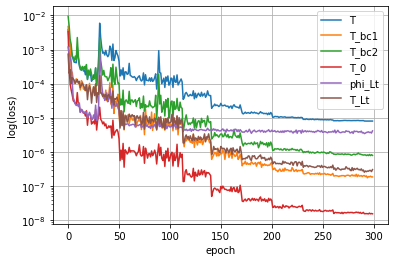

In [73]:
# temp loss graph
# plt.semilogy(T_total_loss_history, label='Total loss')
plt.semilogy(pde_loss_history, label='T')
plt.semilogy(bc_b_loss_history, label='T_bc1')
plt.semilogy(bc_t_loss_history, label='T_bc2')
plt.semilogy(iniT_loss_history, label='T_0')
plt.semilogy(flux_d_loss_history, label='phi_Lt')
plt.semilogy(cont_d_loss_history, label='T_Lt')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.legend()
plt.savefig('Results_Figures\_'+case_info_text_T + '_loss_history.png') 

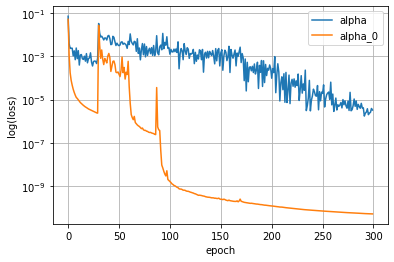

In [74]:
# alpha loss graph
# plt.semilogy(alpha_total_loss_history, label='Total loss')
plt.semilogy(ode_loss_history, label='alpha')
plt.semilogy(inialpha_loss_history, label='alpha_0')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.grid()
plt.legend()
plt.savefig('Results_Figures\_'+case_info_text_alpha + '_loss_history.png') 

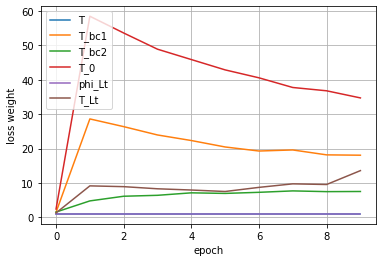

In [75]:
# temp loss weights graph
plt.plot(pde_loss_weight_history, label='T')
plt.plot(bc_b_loss_weight_history, label='T_bc1')
plt.plot(bc_t_loss_weight_history, label='T_bc2')
plt.plot(iniT_loss_weight_history, label='T_0')
plt.plot(flux_d_loss_weight_history, label='phi_Lt')
plt.plot(cont_d_loss_weight_history, label='T_Lt')
plt.xlabel('epoch')
plt.ylabel('loss weight')
plt.grid()
plt.legend()
plt.savefig('Results_Figures\_'+case_info_text_T + '_loss_weights.png') 

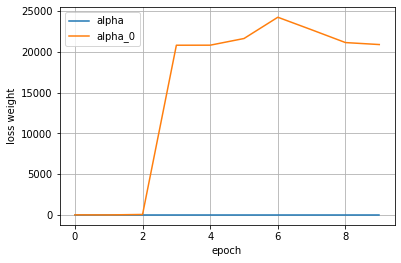

In [76]:
# alpha loss weights graph
plt.plot(ode_loss_weight_history, label='alpha')
plt.plot(inialpha_loss_weight_history, label='alpha_0')
plt.xlabel('epoch')
plt.ylabel('loss weight')
plt.grid()
plt.legend()
plt.savefig('Results_Figures\_'+case_info_text_alpha + '_loss_weights.png') 

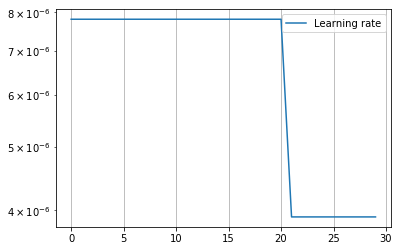

In [82]:
# Temp learning rate change graph
plt.semilogy(history_Heat.history['lr'], label='Learning rate')
plt.grid()
plt.legend()
plt.savefig('Results_Figures\_'+case_info_text_T + '_learning_rate.png') 

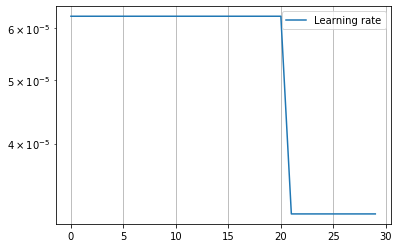

In [83]:
# alpha learning rate change graph
plt.semilogy(history_Alpha.history['lr'], label='Learning rate')
plt.grid()
plt.legend()
plt.savefig('Results_Figures\_'+case_info_text_alpha + '_learning_rate.png') 

## Finite Element results (for comparison)
Reading csv files containin results from FEA using RAVEN 3.1.3 <br>
Reference: (Convergent Manufacturing Technologies. Inc. RAVEN 3.13.1. www.convergent.ca/products/raven-simulation-software, 2020.) <br>
<br>
Finite Element Results are availabloe for following cases (all with one hold standard cure cycle): <br>
* 0.02 m Invar Tool, 0.03 m AS4/8552 composites, convective heat transfer boudanry condition at both ends, one hold temperature cycle <br>
* 0.2 m Invar Tool, 0.3 m AS4/8552 composites, convective heat transfer boudanry condition at both ends, one hold temperature cycle <br>
* 0.02m Invar Tool, 0.03 m AS4/8552 composites, prescribed temperature boudanry condition at both ends, one hold temperature cycle <br>
* 0.2 m Invar Tool, 0.3 m AS4/8552 composites, prescribed temperature boudanry condition at both ends, one hold temperature cycle <br>

In [57]:
T_RAVEN = genfromtxt('FEM_Results\FEM_' + case_info_text_T + '.csv',  delimiter=',')
alpha_RAVEN = genfromtxt('FEM_Results\FEM_' + case_info_text_alpha + '.csv',  delimiter=',')

In [58]:
def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
# reading .csv files for different case studies
if  L_t_bc == 0.05 and  bc_typeb == 'convective':
    T_RAVEN_x_string = 'Temperature [z = 49.990 mm: Temperature 1] ((C))	Time [z = 49.521 mm: Temperature 2] ((min))	Temperature [z = 49.521 mm: Temperature 2] ((C))	Time [z = 48.125 mm: Temperature 3] ((min))	Temperature [z = 48.125 mm: Temperature 3] ((C))	Time [z = 46.250 mm: Temperature 4] ((min))	Temperature [z = 46.250 mm: Temperature 4] ((C))	Time [z = 44.375 mm: Temperature 5] ((min))	Temperature [z = 44.375 mm: Temperature 5] ((C))	Time [z = 42.500 mm: Temperature 6] ((min))	Temperature [z = 42.500 mm: Temperature 6] ((C))	Time [z = 40.625 mm: Temperature 7] ((min))	Temperature [z = 40.625 mm: Temperature 7] ((C))	Time [z = 38.750 mm: Temperature 8] ((min))	Temperature [z = 38.750 mm: Temperature 8] ((C))	Time [z = 36.875 mm: Temperature 9] ((min))	Temperature [z = 36.875 mm: Temperature 9] ((C))	Time [z = 35.000 mm: Temperature 10] ((min))	Temperature [z = 35.000 mm: Temperature 10] ((C))	Time [z = 33.125 mm: Temperature 11] ((min))	Temperature [z = 33.125 mm: Temperature 11] ((C))	Time [z = 31.250 mm: Temperature 12] ((min))	Temperature [z = 31.250 mm: Temperature 12] ((C))	Time [z = 29.375 mm: Temperature 13] ((min))	Temperature [z = 29.375 mm: Temperature 13] ((C))	Time [z = 27.500 mm: Temperature 14] ((min))	Temperature [z = 27.500 mm: Temperature 14] ((C))	Time [z = 25.625 mm: Temperature 15] ((min))	Temperature [z = 25.625 mm: Temperature 15] ((C))	Time [z = 23.750 mm: Temperature 16] ((min))	Temperature [z = 23.750 mm: Temperature 16] ((C))	Time [z = 21.875 mm: Temperature 17] ((min))	Temperature [z = 21.875 mm: Temperature 17] ((C))	Time [z = 20.479 mm: Temperature 18] ((min))	Temperature [z = 20.479 mm: Temperature 18] ((C))	Time [z = 20.010 mm: Temperature 19] ((min))	Temperature [z = 20.010 mm: Temperature 19] ((C))	Time [z = 19.990 mm: Temperature 20] ((min))	Temperature [z = 19.990 mm: Temperature 20] ((C))	Time [z = 19.573 mm: Temperature 21] ((min))	Temperature [z = 19.573 mm: Temperature 21] ((C))	Time [z = 18.333 mm: Temperature 22] ((min))	Temperature [z = 18.333 mm: Temperature 22] ((C))	Time [z = 16.667 mm: Temperature 23] ((min))	Temperature [z = 16.667 mm: Temperature 23] ((C))	Time [z = 15.000 mm: Temperature 24] ((min))	Temperature [z = 15.000 mm: Temperature 24] ((C))	Time [z = 13.333 mm: Temperature 25] ((min))	Temperature [z = 13.333 mm: Temperature 25] ((C))	Time [z = 11.667 mm: Temperature 26] ((min))	Temperature [z = 11.667 mm: Temperature 26] ((C))	Time [z = 10.000 mm: Temperature 27] ((min))	Temperature [z = 10.000 mm: Temperature 27] ((C))	Time [z = 8.333 mm: Temperature 28] ((min))	Temperature [z = 8.333 mm: Temperature 28] ((C))	Time [z = 6.667 mm: Temperature 29] ((min))	Temperature [z = 6.667 mm: Temperature 29] ((C))	Time [z = 5.000 mm: Temperature 30] ((min))	Temperature [z = 5.000 mm: Temperature 30] ((C))	Time [z = 3.333 mm: Temperature 31] ((min))	Temperature [z = 3.333 mm: Temperature 31] ((C))	Time [z = 1.667 mm: Temperature 32] ((min))	Temperature [z = 1.667 mm: Temperature 32] ((C))	Time [z = 0.427 mm: Temperature 33] ((min))	Temperature [z = 0.427 mm: Temperature 33] ((C))	Time [z = 0.010 mm: Temperature 34] ((min))	Temperature [z = 0.010 mm: Temperature 34] ((C))'
    alpha_RAVEN_x_string = 'Degree of Cure [z = 49.990 mm: Degree of Cure]	Degree of Cure [z = 49.521 mm: Degree of Cure 1]	Degree of Cure [z = 48.125 mm: Degree of Cure 2]	Degree of Cure [z = 46.250 mm: Degree of Cure 3]	Degree of Cure [z = 44.375 mm: Degree of Cure 4]	Degree of Cure [z = 42.500 mm: Degree of Cure 5]	Degree of Cure [z = 40.625 mm: Degree of Cure 6]	Degree of Cure [z = 38.750 mm: Degree of Cure 7]	Degree of Cure [z = 36.875 mm: Degree of Cure 8]	Degree of Cure [z = 35.000 mm: Degree of Cure 9]	Degree of Cure [z = 33.125 mm: Degree of Cure 10]	Degree of Cure [z = 31.250 mm: Degree of Cure 11]	Degree of Cure [z = 29.375 mm: Degree of Cure 12]	Degree of Cure [z = 27.500 mm: Degree of Cure 13]	Degree of Cure [z = 25.625 mm: Degree of Cure 14]	Degree of Cure [z = 23.750 mm: Degree of Cure 15]	Degree of Cure [z = 21.875 mm: Degree of Cure 16]	Degree of Cure [z = 20.479 mm: Degree of Cure 17]	Degree of Cure [z = 20.010 mm: Degree of Cure 18]'
elif  L_t_bc == 0.5 and  bc_typeb == 'convective':
    T_RAVEN_x_string = 'Temperature [z = 499.990 mm: Temperature] ((C))	Time [z = 499.497 mm: Temperature] ((min))	Temperature [z = 499.497 mm: Temperature] ((C))	Time [z = 498.026 mm: Temperature] ((min))	Temperature [z = 498.026 mm: Temperature] ((C))	Time [z = 496.053 mm: Temperature] ((min))	Temperature [z = 496.053 mm: Temperature] ((C))	Time [z = 494.079 mm: Temperature] ((min))	Temperature [z = 494.079 mm: Temperature] ((C))	Time [z = 492.105 mm: Temperature] ((min))	Temperature [z = 492.105 mm: Temperature] ((C))	Time [z = 490.132 mm: Temperature] ((min))	Temperature [z = 490.132 mm: Temperature] ((C))	Time [z = 488.158 mm: Temperature] ((min))	Temperature [z = 488.158 mm: Temperature] ((C))	Time [z = 486.184 mm: Temperature] ((min))	Temperature [z = 486.184 mm: Temperature] ((C))	Time [z = 484.211 mm: Temperature] ((min))	Temperature [z = 484.211 mm: Temperature] ((C))	Time [z = 482.237 mm: Temperature] ((min))	Temperature [z = 482.237 mm: Temperature] ((C))	Time [z = 480.263 mm: Temperature] ((min))	Temperature [z = 480.263 mm: Temperature] ((C))	Time [z = 478.289 mm: Temperature] ((min))	Temperature [z = 478.289 mm: Temperature] ((C))	Time [z = 476.316 mm: Temperature] ((min))	Temperature [z = 476.316 mm: Temperature] ((C))	Time [z = 474.342 mm: Temperature] ((min))	Temperature [z = 474.342 mm: Temperature] ((C))	Time [z = 472.368 mm: Temperature] ((min))	Temperature [z = 472.368 mm: Temperature] ((C))	Time [z = 470.395 mm: Temperature] ((min))	Temperature [z = 470.395 mm: Temperature] ((C))	Time [z = 468.421 mm: Temperature] ((min))	Temperature [z = 468.421 mm: Temperature] ((C))	Time [z = 466.447 mm: Temperature] ((min))	Temperature [z = 466.447 mm: Temperature] ((C))	Time [z = 464.474 mm: Temperature] ((min))	Temperature [z = 464.474 mm: Temperature] ((C))	Time [z = 462.500 mm: Temperature] ((min))	Temperature [z = 462.500 mm: Temperature] ((C))	Time [z = 460.526 mm: Temperature] ((min))	Temperature [z = 460.526 mm: Temperature] ((C))	Time [z = 458.553 mm: Temperature] ((min))	Temperature [z = 458.553 mm: Temperature] ((C))	Time [z = 456.579 mm: Temperature] ((min))	Temperature [z = 456.579 mm: Temperature] ((C))	Time [z = 454.605 mm: Temperature] ((min))	Temperature [z = 454.605 mm: Temperature] ((C))	Time [z = 452.632 mm: Temperature] ((min))	Temperature [z = 452.632 mm: Temperature] ((C))	Time [z = 450.658 mm: Temperature] ((min))	Temperature [z = 450.658 mm: Temperature] ((C))	Time [z = 448.684 mm: Temperature] ((min))	Temperature [z = 448.684 mm: Temperature] ((C))	Time [z = 446.711 mm: Temperature] ((min))	Temperature [z = 446.711 mm: Temperature] ((C))	Time [z = 444.737 mm: Temperature] ((min))	Temperature [z = 444.737 mm: Temperature] ((C))	Time [z = 442.763 mm: Temperature] ((min))	Temperature [z = 442.763 mm: Temperature] ((C))	Time [z = 440.789 mm: Temperature] ((min))	Temperature [z = 440.789 mm: Temperature] ((C))	Time [z = 438.816 mm: Temperature] ((min))	Temperature [z = 438.816 mm: Temperature] ((C))	Time [z = 436.842 mm: Temperature] ((min))	Temperature [z = 436.842 mm: Temperature] ((C))	Time [z = 434.868 mm: Temperature] ((min))	Temperature [z = 434.868 mm: Temperature] ((C))	Time [z = 432.895 mm: Temperature] ((min))	Temperature [z = 432.895 mm: Temperature] ((C))	Time [z = 430.921 mm: Temperature] ((min))	Temperature [z = 430.921 mm: Temperature] ((C))	Time [z = 428.947 mm: Temperature] ((min))	Temperature [z = 428.947 mm: Temperature] ((C))	Time [z = 426.974 mm: Temperature] ((min))	Temperature [z = 426.974 mm: Temperature] ((C))	Time [z = 425.000 mm: Temperature] ((min))	Temperature [z = 425.000 mm: Temperature] ((C))	Time [z = 423.026 mm: Temperature] ((min))	Temperature [z = 423.026 mm: Temperature] ((C))	Time [z = 421.053 mm: Temperature] ((min))	Temperature [z = 421.053 mm: Temperature] ((C))	Time [z = 419.079 mm: Temperature] ((min))	Temperature [z = 419.079 mm: Temperature] ((C))	Time [z = 417.105 mm: Temperature] ((min))	Temperature [z = 417.105 mm: Temperature] ((C))	Time [z = 415.132 mm: Temperature] ((min))	Temperature [z = 415.132 mm: Temperature] ((C))	Time [z = 413.158 mm: Temperature] ((min))	Temperature [z = 413.158 mm: Temperature] ((C))	Time [z = 411.184 mm: Temperature] ((min))	Temperature [z = 411.184 mm: Temperature] ((C))	Time [z = 409.211 mm: Temperature] ((min))	Temperature [z = 409.211 mm: Temperature] ((C))	Time [z = 407.237 mm: Temperature] ((min))	Temperature [z = 407.237 mm: Temperature] ((C))	Time [z = 405.263 mm: Temperature] ((min))	Temperature [z = 405.263 mm: Temperature] ((C))	Time [z = 403.289 mm: Temperature] ((min))	Temperature [z = 403.289 mm: Temperature] ((C))	Time [z = 401.316 mm: Temperature] ((min))	Temperature [z = 401.316 mm: Temperature] ((C))	Time [z = 399.342 mm: Temperature] ((min))	Temperature [z = 399.342 mm: Temperature] ((C))	Time [z = 397.368 mm: Temperature] ((min))	Temperature [z = 397.368 mm: Temperature] ((C))	Time [z = 395.395 mm: Temperature] ((min))	Temperature [z = 395.395 mm: Temperature] ((C))	Time [z = 393.421 mm: Temperature] ((min))	Temperature [z = 393.421 mm: Temperature] ((C))	Time [z = 391.447 mm: Temperature] ((min))	Temperature [z = 391.447 mm: Temperature] ((C))	Time [z = 389.474 mm: Temperature] ((min))	Temperature [z = 389.474 mm: Temperature] ((C))	Time [z = 387.500 mm: Temperature] ((min))	Temperature [z = 387.500 mm: Temperature] ((C))	Time [z = 385.526 mm: Temperature] ((min))	Temperature [z = 385.526 mm: Temperature] ((C))	Time [z = 383.553 mm: Temperature] ((min))	Temperature [z = 383.553 mm: Temperature] ((C))	Time [z = 381.579 mm: Temperature] ((min))	Temperature [z = 381.579 mm: Temperature] ((C))	Time [z = 379.605 mm: Temperature] ((min))	Temperature [z = 379.605 mm: Temperature] ((C))	Time [z = 377.632 mm: Temperature] ((min))	Temperature [z = 377.632 mm: Temperature] ((C))	Time [z = 375.658 mm: Temperature] ((min))	Temperature [z = 375.658 mm: Temperature] ((C))	Time [z = 373.684 mm: Temperature] ((min))	Temperature [z = 373.684 mm: Temperature] ((C))	Time [z = 371.711 mm: Temperature] ((min))	Temperature [z = 371.711 mm: Temperature] ((C))	Time [z = 369.737 mm: Temperature] ((min))	Temperature [z = 369.737 mm: Temperature] ((C))	Time [z = 367.763 mm: Temperature] ((min))	Temperature [z = 367.763 mm: Temperature] ((C))	Time [z = 365.789 mm: Temperature] ((min))	Temperature [z = 365.789 mm: Temperature] ((C))	Time [z = 363.816 mm: Temperature] ((min))	Temperature [z = 363.816 mm: Temperature] ((C))	Time [z = 361.842 mm: Temperature] ((min))	Temperature [z = 361.842 mm: Temperature] ((C))	Time [z = 359.868 mm: Temperature] ((min))	Temperature [z = 359.868 mm: Temperature] ((C))	Time [z = 357.895 mm: Temperature] ((min))	Temperature [z = 357.895 mm: Temperature] ((C))	Time [z = 355.921 mm: Temperature] ((min))	Temperature [z = 355.921 mm: Temperature] ((C))	Time [z = 353.947 mm: Temperature] ((min))	Temperature [z = 353.947 mm: Temperature] ((C))	Time [z = 351.974 mm: Temperature] ((min))	Temperature [z = 351.974 mm: Temperature] ((C))	Time [z = 350.000 mm: Temperature] ((min))	Temperature [z = 350.000 mm: Temperature] ((C))	Time [z = 348.026 mm: Temperature] ((min))	Temperature [z = 348.026 mm: Temperature] ((C))	Time [z = 346.053 mm: Temperature] ((min))	Temperature [z = 346.053 mm: Temperature] ((C))	Time [z = 344.079 mm: Temperature] ((min))	Temperature [z = 344.079 mm: Temperature] ((C))	Time [z = 342.105 mm: Temperature] ((min))	Temperature [z = 342.105 mm: Temperature] ((C))	Time [z = 340.132 mm: Temperature] ((min))	Temperature [z = 340.132 mm: Temperature] ((C))	Time [z = 338.158 mm: Temperature] ((min))	Temperature [z = 338.158 mm: Temperature] ((C))	Time [z = 336.184 mm: Temperature] ((min))	Temperature [z = 336.184 mm: Temperature] ((C))	Time [z = 334.211 mm: Temperature] ((min))	Temperature [z = 334.211 mm: Temperature] ((C))	Time [z = 332.237 mm: Temperature] ((min))	Temperature [z = 332.237 mm: Temperature] ((C))	Time [z = 330.263 mm: Temperature] ((min))	Temperature [z = 330.263 mm: Temperature] ((C))	Time [z = 328.289 mm: Temperature] ((min))	Temperature [z = 328.289 mm: Temperature] ((C))	Time [z = 326.316 mm: Temperature] ((min))	Temperature [z = 326.316 mm: Temperature] ((C))	Time [z = 324.342 mm: Temperature] ((min))	Temperature [z = 324.342 mm: Temperature] ((C))	Time [z = 322.368 mm: Temperature] ((min))	Temperature [z = 322.368 mm: Temperature] ((C))	Time [z = 320.395 mm: Temperature] ((min))	Temperature [z = 320.395 mm: Temperature] ((C))	Time [z = 318.421 mm: Temperature] ((min))	Temperature [z = 318.421 mm: Temperature] ((C))	Time [z = 316.447 mm: Temperature] ((min))	Temperature [z = 316.447 mm: Temperature] ((C))	Time [z = 314.474 mm: Temperature] ((min))	Temperature [z = 314.474 mm: Temperature] ((C))	Time [z = 312.500 mm: Temperature] ((min))	Temperature [z = 312.500 mm: Temperature] ((C))	Time [z = 310.526 mm: Temperature] ((min))	Temperature [z = 310.526 mm: Temperature] ((C))	Time [z = 308.553 mm: Temperature] ((min))	Temperature [z = 308.553 mm: Temperature] ((C))	Time [z = 306.579 mm: Temperature] ((min))	Temperature [z = 306.579 mm: Temperature] ((C))	Time [z = 304.605 mm: Temperature] ((min))	Temperature [z = 304.605 mm: Temperature] ((C))	Time [z = 302.632 mm: Temperature] ((min))	Temperature [z = 302.632 mm: Temperature] ((C))	Time [z = 300.658 mm: Temperature] ((min))	Temperature [z = 300.658 mm: Temperature] ((C))	Time [z = 298.684 mm: Temperature] ((min))	Temperature [z = 298.684 mm: Temperature] ((C))	Time [z = 296.711 mm: Temperature] ((min))	Temperature [z = 296.711 mm: Temperature] ((C))	Time [z = 294.737 mm: Temperature] ((min))	Temperature [z = 294.737 mm: Temperature] ((C))	Time [z = 292.763 mm: Temperature] ((min))	Temperature [z = 292.763 mm: Temperature] ((C))	Time [z = 290.789 mm: Temperature] ((min))	Temperature [z = 290.789 mm: Temperature] ((C))	Time [z = 288.816 mm: Temperature] ((min))	Temperature [z = 288.816 mm: Temperature] ((C))	Time [z = 286.842 mm: Temperature] ((min))	Temperature [z = 286.842 mm: Temperature] ((C))	Time [z = 284.868 mm: Temperature] ((min))	Temperature [z = 284.868 mm: Temperature] ((C))	Time [z = 282.895 mm: Temperature] ((min))	Temperature [z = 282.895 mm: Temperature] ((C))	Time [z = 280.921 mm: Temperature] ((min))	Temperature [z = 280.921 mm: Temperature] ((C))	Time [z = 278.947 mm: Temperature] ((min))	Temperature [z = 278.947 mm: Temperature] ((C))	Time [z = 276.974 mm: Temperature] ((min))	Temperature [z = 276.974 mm: Temperature] ((C))	Time [z = 275.000 mm: Temperature] ((min))	Temperature [z = 275.000 mm: Temperature] ((C))	Time [z = 273.026 mm: Temperature] ((min))	Temperature [z = 273.026 mm: Temperature] ((C))	Time [z = 271.053 mm: Temperature] ((min))	Temperature [z = 271.053 mm: Temperature] ((C))	Time [z = 269.079 mm: Temperature] ((min))	Temperature [z = 269.079 mm: Temperature] ((C))	Time [z = 267.105 mm: Temperature] ((min))	Temperature [z = 267.105 mm: Temperature] ((C))	Time [z = 265.132 mm: Temperature] ((min))	Temperature [z = 265.132 mm: Temperature] ((C))	Time [z = 263.158 mm: Temperature] ((min))	Temperature [z = 263.158 mm: Temperature] ((C))	Time [z = 261.184 mm: Temperature] ((min))	Temperature [z = 261.184 mm: Temperature] ((C))	Time [z = 259.211 mm: Temperature] ((min))	Temperature [z = 259.211 mm: Temperature] ((C))	Time [z = 257.237 mm: Temperature] ((min))	Temperature [z = 257.237 mm: Temperature] ((C))	Time [z = 255.263 mm: Temperature] ((min))	Temperature [z = 255.263 mm: Temperature] ((C))	Time [z = 253.289 mm: Temperature] ((min))	Temperature [z = 253.289 mm: Temperature] ((C))	Time [z = 251.316 mm: Temperature] ((min))	Temperature [z = 251.316 mm: Temperature] ((C))	Time [z = 249.342 mm: Temperature] ((min))	Temperature [z = 249.342 mm: Temperature] ((C))	Time [z = 247.368 mm: Temperature] ((min))	Temperature [z = 247.368 mm: Temperature] ((C))	Time [z = 245.395 mm: Temperature] ((min))	Temperature [z = 245.395 mm: Temperature] ((C))	Time [z = 243.421 mm: Temperature] ((min))	Temperature [z = 243.421 mm: Temperature] ((C))	Time [z = 241.447 mm: Temperature] ((min))	Temperature [z = 241.447 mm: Temperature] ((C))	Time [z = 239.474 mm: Temperature] ((min))	Temperature [z = 239.474 mm: Temperature] ((C))	Time [z = 237.500 mm: Temperature] ((min))	Temperature [z = 237.500 mm: Temperature] ((C))	Time [z = 235.526 mm: Temperature] ((min))	Temperature [z = 235.526 mm: Temperature] ((C))	Time [z = 233.553 mm: Temperature] ((min))	Temperature [z = 233.553 mm: Temperature] ((C))	Time [z = 231.579 mm: Temperature] ((min))	Temperature [z = 231.579 mm: Temperature] ((C))	Time [z = 229.605 mm: Temperature] ((min))	Temperature [z = 229.605 mm: Temperature] ((C))	Time [z = 227.632 mm: Temperature] ((min))	Temperature [z = 227.632 mm: Temperature] ((C))	Time [z = 225.658 mm: Temperature] ((min))	Temperature [z = 225.658 mm: Temperature] ((C))	Time [z = 223.684 mm: Temperature] ((min))	Temperature [z = 223.684 mm: Temperature] ((C))	Time [z = 221.711 mm: Temperature] ((min))	Temperature [z = 221.711 mm: Temperature] ((C))	Time [z = 219.737 mm: Temperature] ((min))	Temperature [z = 219.737 mm: Temperature] ((C))	Time [z = 217.763 mm: Temperature] ((min))	Temperature [z = 217.763 mm: Temperature] ((C))	Time [z = 215.789 mm: Temperature] ((min))	Temperature [z = 215.789 mm: Temperature] ((C))	Time [z = 213.816 mm: Temperature] ((min))	Temperature [z = 213.816 mm: Temperature] ((C))	Time [z = 211.842 mm: Temperature] ((min))	Temperature [z = 211.842 mm: Temperature] ((C))	Time [z = 209.868 mm: Temperature] ((min))	Temperature [z = 209.868 mm: Temperature] ((C))	Time [z = 207.895 mm: Temperature] ((min))	Temperature [z = 207.895 mm: Temperature] ((C))	Time [z = 205.921 mm: Temperature] ((min))	Temperature [z = 205.921 mm: Temperature] ((C))	Time [z = 203.947 mm: Temperature] ((min))	Temperature [z = 203.947 mm: Temperature] ((C))	Time [z = 201.974 mm: Temperature] ((min))	Temperature [z = 201.974 mm: Temperature] ((C))	Time [z = 200.503 mm: Temperature] ((min))	Temperature [z = 200.503 mm: Temperature] ((C))	Time [z = 200.010 mm: Temperature] ((min))	Temperature [z = 200.010 mm: Temperature] ((C))	Time [z = 199.990 mm: Temperature] ((min))	Temperature [z = 199.990 mm: Temperature] ((C))	Time [z = 199.490 mm: Temperature] ((min))	Temperature [z = 199.490 mm: Temperature] ((C))	Time [z = 198.000 mm: Temperature] ((min))	Temperature [z = 198.000 mm: Temperature] ((C))	Time [z = 196.000 mm: Temperature] ((min))	Temperature [z = 196.000 mm: Temperature] ((C))	Time [z = 194.000 mm: Temperature] ((min))	Temperature [z = 194.000 mm: Temperature] ((C))	Time [z = 192.000 mm: Temperature] ((min))	Temperature [z = 192.000 mm: Temperature] ((C))	Time [z = 190.000 mm: Temperature] ((min))	Temperature [z = 190.000 mm: Temperature] ((C))	Time [z = 188.000 mm: Temperature] ((min))	Temperature [z = 188.000 mm: Temperature] ((C))	Time [z = 186.000 mm: Temperature] ((min))	Temperature [z = 186.000 mm: Temperature] ((C))	Time [z = 184.000 mm: Temperature] ((min))	Temperature [z = 184.000 mm: Temperature] ((C))	Time [z = 182.000 mm: Temperature] ((min))	Temperature [z = 182.000 mm: Temperature] ((C))	Time [z = 180.000 mm: Temperature] ((min))	Temperature [z = 180.000 mm: Temperature] ((C))	Time [z = 178.000 mm: Temperature] ((min))	Temperature [z = 178.000 mm: Temperature] ((C))	Time [z = 176.000 mm: Temperature] ((min))	Temperature [z = 176.000 mm: Temperature] ((C))	Time [z = 174.000 mm: Temperature] ((min))	Temperature [z = 174.000 mm: Temperature] ((C))	Time [z = 172.000 mm: Temperature] ((min))	Temperature [z = 172.000 mm: Temperature] ((C))	Time [z = 170.000 mm: Temperature] ((min))	Temperature [z = 170.000 mm: Temperature] ((C))	Time [z = 168.000 mm: Temperature] ((min))	Temperature [z = 168.000 mm: Temperature] ((C))	Time [z = 166.000 mm: Temperature] ((min))	Temperature [z = 166.000 mm: Temperature] ((C))	Time [z = 164.000 mm: Temperature] ((min))	Temperature [z = 164.000 mm: Temperature] ((C))	Time [z = 162.000 mm: Temperature] ((min))	Temperature [z = 162.000 mm: Temperature] ((C))	Time [z = 160.000 mm: Temperature] ((min))	Temperature [z = 160.000 mm: Temperature] ((C))	Time [z = 158.000 mm: Temperature] ((min))	Temperature [z = 158.000 mm: Temperature] ((C))	Time [z = 156.000 mm: Temperature] ((min))	Temperature [z = 156.000 mm: Temperature] ((C))	Time [z = 154.000 mm: Temperature] ((min))	Temperature [z = 154.000 mm: Temperature] ((C))	Time [z = 152.000 mm: Temperature] ((min))	Temperature [z = 152.000 mm: Temperature] ((C))	Time [z = 150.000 mm: Temperature] ((min))	Temperature [z = 150.000 mm: Temperature] ((C))	Time [z = 148.000 mm: Temperature] ((min))	Temperature [z = 148.000 mm: Temperature] ((C))	Time [z = 146.000 mm: Temperature] ((min))	Temperature [z = 146.000 mm: Temperature] ((C))	Time [z = 144.000 mm: Temperature] ((min))	Temperature [z = 144.000 mm: Temperature] ((C))	Time [z = 142.000 mm: Temperature] ((min))	Temperature [z = 142.000 mm: Temperature] ((C))	Time [z = 140.000 mm: Temperature] ((min))	Temperature [z = 140.000 mm: Temperature] ((C))	Time [z = 138.000 mm: Temperature] ((min))	Temperature [z = 138.000 mm: Temperature] ((C))	Time [z = 136.000 mm: Temperature] ((min))	Temperature [z = 136.000 mm: Temperature] ((C))	Time [z = 134.000 mm: Temperature] ((min))	Temperature [z = 134.000 mm: Temperature] ((C))	Time [z = 132.000 mm: Temperature] ((min))	Temperature [z = 132.000 mm: Temperature] ((C))	Time [z = 130.000 mm: Temperature] ((min))	Temperature [z = 130.000 mm: Temperature] ((C))	Time [z = 128.000 mm: Temperature] ((min))	Temperature [z = 128.000 mm: Temperature] ((C))	Time [z = 126.000 mm: Temperature] ((min))	Temperature [z = 126.000 mm: Temperature] ((C))	Time [z = 124.000 mm: Temperature] ((min))	Temperature [z = 124.000 mm: Temperature] ((C))	Time [z = 122.000 mm: Temperature] ((min))	Temperature [z = 122.000 mm: Temperature] ((C))	Time [z = 120.000 mm: Temperature] ((min))	Temperature [z = 120.000 mm: Temperature] ((C))	Time [z = 118.000 mm: Temperature] ((min))	Temperature [z = 118.000 mm: Temperature] ((C))	Time [z = 116.000 mm: Temperature] ((min))	Temperature [z = 116.000 mm: Temperature] ((C))	Time [z = 114.000 mm: Temperature] ((min))	Temperature [z = 114.000 mm: Temperature] ((C))	Time [z = 112.000 mm: Temperature] ((min))	Temperature [z = 112.000 mm: Temperature] ((C))	Time [z = 110.000 mm: Temperature] ((min))	Temperature [z = 110.000 mm: Temperature] ((C))	Time [z = 108.000 mm: Temperature] ((min))	Temperature [z = 108.000 mm: Temperature] ((C))	Time [z = 106.000 mm: Temperature] ((min))	Temperature [z = 106.000 mm: Temperature] ((C))	Time [z = 104.000 mm: Temperature] ((min))	Temperature [z = 104.000 mm: Temperature] ((C))	Time [z = 102.000 mm: Temperature] ((min))	Temperature [z = 102.000 mm: Temperature] ((C))	Time [z = 100.000 mm: Temperature] ((min))	Temperature [z = 100.000 mm: Temperature] ((C))	Time [z = 98.000 mm: Temperature] ((min))	Temperature [z = 98.000 mm: Temperature] ((C))	Time [z = 96.000 mm: Temperature] ((min))	Temperature [z = 96.000 mm: Temperature] ((C))	Time [z = 94.000 mm: Temperature] ((min))	Temperature [z = 94.000 mm: Temperature] ((C))	Time [z = 92.000 mm: Temperature] ((min))	Temperature [z = 92.000 mm: Temperature] ((C))	Time [z = 90.000 mm: Temperature] ((min))	Temperature [z = 90.000 mm: Temperature] ((C))	Time [z = 88.000 mm: Temperature] ((min))	Temperature [z = 88.000 mm: Temperature] ((C))	Time [z = 86.000 mm: Temperature] ((min))	Temperature [z = 86.000 mm: Temperature] ((C))	Time [z = 84.000 mm: Temperature] ((min))	Temperature [z = 84.000 mm: Temperature] ((C))	Time [z = 82.000 mm: Temperature] ((min))	Temperature [z = 82.000 mm: Temperature] ((C))	Time [z = 80.000 mm: Temperature] ((min))	Temperature [z = 80.000 mm: Temperature] ((C))	Time [z = 78.000 mm: Temperature] ((min))	Temperature [z = 78.000 mm: Temperature] ((C))	Time [z = 76.000 mm: Temperature] ((min))	Temperature [z = 76.000 mm: Temperature] ((C))	Time [z = 74.000 mm: Temperature] ((min))	Temperature [z = 74.000 mm: Temperature] ((C))	Time [z = 72.000 mm: Temperature] ((min))	Temperature [z = 72.000 mm: Temperature] ((C))	Time [z = 70.000 mm: Temperature] ((min))	Temperature [z = 70.000 mm: Temperature] ((C))	Time [z = 68.000 mm: Temperature] ((min))	Temperature [z = 68.000 mm: Temperature] ((C))	Time [z = 66.000 mm: Temperature] ((min))	Temperature [z = 66.000 mm: Temperature] ((C))	Time [z = 64.000 mm: Temperature] ((min))	Temperature [z = 64.000 mm: Temperature] ((C))	Time [z = 62.000 mm: Temperature] ((min))	Temperature [z = 62.000 mm: Temperature] ((C))	Time [z = 60.000 mm: Temperature] ((min))	Temperature [z = 60.000 mm: Temperature] ((C))	Time [z = 58.000 mm: Temperature] ((min))	Temperature [z = 58.000 mm: Temperature] ((C))	Time [z = 56.000 mm: Temperature] ((min))	Temperature [z = 56.000 mm: Temperature] ((C))	Time [z = 54.000 mm: Temperature] ((min))	Temperature [z = 54.000 mm: Temperature] ((C))	Time [z = 52.000 mm: Temperature] ((min))	Temperature [z = 52.000 mm: Temperature] ((C))	Time [z = 50.000 mm: Temperature] ((min))	Temperature [z = 50.000 mm: Temperature] ((C))	Time [z = 48.000 mm: Temperature] ((min))	Temperature [z = 48.000 mm: Temperature] ((C))	Time [z = 46.000 mm: Temperature] ((min))	Temperature [z = 46.000 mm: Temperature] ((C))	Time [z = 44.000 mm: Temperature] ((min))	Temperature [z = 44.000 mm: Temperature] ((C))	Time [z = 42.000 mm: Temperature] ((min))	Temperature [z = 42.000 mm: Temperature] ((C))	Time [z = 40.000 mm: Temperature] ((min))	Temperature [z = 40.000 mm: Temperature] ((C))	Time [z = 38.000 mm: Temperature] ((min))	Temperature [z = 38.000 mm: Temperature] ((C))	Time [z = 36.000 mm: Temperature] ((min))	Temperature [z = 36.000 mm: Temperature] ((C))	Time [z = 34.000 mm: Temperature] ((min))	Temperature [z = 34.000 mm: Temperature] ((C))	Time [z = 32.000 mm: Temperature] ((min))	Temperature [z = 32.000 mm: Temperature] ((C))	Time [z = 30.000 mm: Temperature] ((min))	Temperature [z = 30.000 mm: Temperature] ((C))	Time [z = 28.000 mm: Temperature] ((min))	Temperature [z = 28.000 mm: Temperature] ((C))	Time [z = 26.000 mm: Temperature] ((min))	Temperature [z = 26.000 mm: Temperature] ((C))	Time [z = 24.000 mm: Temperature] ((min))	Temperature [z = 24.000 mm: Temperature] ((C))	Time [z = 22.000 mm: Temperature] ((min))	Temperature [z = 22.000 mm: Temperature] ((C))	Time [z = 20.000 mm: Temperature] ((min))	Temperature [z = 20.000 mm: Temperature] ((C))	Time [z = 18.000 mm: Temperature] ((min))	Temperature [z = 18.000 mm: Temperature] ((C))	Time [z = 16.000 mm: Temperature] ((min))	Temperature [z = 16.000 mm: Temperature] ((C))	Time [z = 14.000 mm: Temperature] ((min))	Temperature [z = 14.000 mm: Temperature] ((C))	Time [z = 12.000 mm: Temperature] ((min))	Temperature [z = 12.000 mm: Temperature] ((C))	Time [z = 10.000 mm: Temperature] ((min))	Temperature [z = 10.000 mm: Temperature] ((C))	Time [z = 8.000 mm: Temperature] ((min))	Temperature [z = 8.000 mm: Temperature] ((C))	Time [z = 6.000 mm: Temperature] ((min))	Temperature [z = 6.000 mm: Temperature] ((C))	Time [z = 4.000 mm: Temperature] ((min))	Temperature [z = 4.000 mm: Temperature] ((C))	Time [z = 2.000 mm: Temperature] ((min))	Temperature [z = 2.000 mm: Temperature] ((C))	Time [z = 0.510 mm: Temperature] ((min))	Temperature [z = 0.510 mm: Temperature] ((C))	Time [z = 0.010 mm: Temperature] ((min))	Temperature [z = 0.010 mm: Temperature] ((C))'
    alpha_RAVEN_x_string = 'Degree of Cure [z = 499.990 mm: Degree of Cure]	Degree of Cure [z = 499.497 mm: Degree of Cure]	Degree of Cure [z = 498.026 mm: Degree of Cure]	Degree of Cure [z = 496.053 mm: Degree of Cure]	Degree of Cure [z = 494.079 mm: Degree of Cure]	Degree of Cure [z = 492.105 mm: Degree of Cure]	Degree of Cure [z = 490.132 mm: Degree of Cure]	Degree of Cure [z = 488.158 mm: Degree of Cure]	Degree of Cure [z = 486.184 mm: Degree of Cure]	Degree of Cure [z = 484.211 mm: Degree of Cure]	Degree of Cure [z = 482.237 mm: Degree of Cure]	Degree of Cure [z = 480.263 mm: Degree of Cure]	Degree of Cure [z = 478.289 mm: Degree of Cure]	Degree of Cure [z = 476.316 mm: Degree of Cure]	Degree of Cure [z = 474.342 mm: Degree of Cure]	Degree of Cure [z = 472.368 mm: Degree of Cure]	Degree of Cure [z = 470.395 mm: Degree of Cure]	Degree of Cure [z = 468.421 mm: Degree of Cure]	Degree of Cure [z = 466.447 mm: Degree of Cure]	Degree of Cure [z = 464.474 mm: Degree of Cure]	Degree of Cure [z = 462.500 mm: Degree of Cure]	Degree of Cure [z = 460.526 mm: Degree of Cure]	Degree of Cure [z = 458.553 mm: Degree of Cure]	Degree of Cure [z = 456.579 mm: Degree of Cure]	Degree of Cure [z = 454.605 mm: Degree of Cure]	Degree of Cure [z = 452.632 mm: Degree of Cure]	Degree of Cure [z = 450.658 mm: Degree of Cure]	Degree of Cure [z = 448.684 mm: Degree of Cure]	Degree of Cure [z = 446.711 mm: Degree of Cure]	Degree of Cure [z = 444.737 mm: Degree of Cure]	Degree of Cure [z = 442.763 mm: Degree of Cure]	Degree of Cure [z = 440.789 mm: Degree of Cure]	Degree of Cure [z = 438.816 mm: Degree of Cure]	Degree of Cure [z = 436.842 mm: Degree of Cure]	Degree of Cure [z = 434.868 mm: Degree of Cure]	Degree of Cure [z = 432.895 mm: Degree of Cure]	Degree of Cure [z = 430.921 mm: Degree of Cure]	Degree of Cure [z = 428.947 mm: Degree of Cure]	Degree of Cure [z = 426.974 mm: Degree of Cure]	Degree of Cure [z = 425.000 mm: Degree of Cure]	Degree of Cure [z = 423.026 mm: Degree of Cure]	Degree of Cure [z = 421.053 mm: Degree of Cure]	Degree of Cure [z = 419.079 mm: Degree of Cure]	Degree of Cure [z = 417.105 mm: Degree of Cure]	Degree of Cure [z = 415.132 mm: Degree of Cure]	Degree of Cure [z = 413.158 mm: Degree of Cure]	Degree of Cure [z = 411.184 mm: Degree of Cure]	Degree of Cure [z = 409.211 mm: Degree of Cure]	Degree of Cure [z = 407.237 mm: Degree of Cure]	Degree of Cure [z = 405.263 mm: Degree of Cure]	Degree of Cure [z = 403.289 mm: Degree of Cure]	Degree of Cure [z = 401.316 mm: Degree of Cure]	Degree of Cure [z = 399.342 mm: Degree of Cure]	Degree of Cure [z = 397.368 mm: Degree of Cure]	Degree of Cure [z = 395.395 mm: Degree of Cure]	Degree of Cure [z = 393.421 mm: Degree of Cure]	Degree of Cure [z = 391.447 mm: Degree of Cure]	Degree of Cure [z = 389.474 mm: Degree of Cure]	Degree of Cure [z = 387.500 mm: Degree of Cure]	Degree of Cure [z = 385.526 mm: Degree of Cure]	Degree of Cure [z = 383.553 mm: Degree of Cure]	Degree of Cure [z = 381.579 mm: Degree of Cure]	Degree of Cure [z = 379.605 mm: Degree of Cure]	Degree of Cure [z = 377.632 mm: Degree of Cure]	Degree of Cure [z = 375.658 mm: Degree of Cure]	Degree of Cure [z = 373.684 mm: Degree of Cure]	Degree of Cure [z = 371.711 mm: Degree of Cure]	Degree of Cure [z = 369.737 mm: Degree of Cure]	Degree of Cure [z = 367.763 mm: Degree of Cure]	Degree of Cure [z = 365.789 mm: Degree of Cure]	Degree of Cure [z = 363.816 mm: Degree of Cure]	Degree of Cure [z = 361.842 mm: Degree of Cure]	Degree of Cure [z = 359.868 mm: Degree of Cure]	Degree of Cure [z = 357.895 mm: Degree of Cure]	Degree of Cure [z = 355.921 mm: Degree of Cure]	Degree of Cure [z = 353.947 mm: Degree of Cure]	Degree of Cure [z = 351.974 mm: Degree of Cure]	Degree of Cure [z = 350.000 mm: Degree of Cure]	Degree of Cure [z = 348.026 mm: Degree of Cure]	Degree of Cure [z = 346.053 mm: Degree of Cure]	Degree of Cure [z = 344.079 mm: Degree of Cure]	Degree of Cure [z = 342.105 mm: Degree of Cure]	Degree of Cure [z = 340.132 mm: Degree of Cure]	Degree of Cure [z = 338.158 mm: Degree of Cure]	Degree of Cure [z = 336.184 mm: Degree of Cure]	Degree of Cure [z = 334.211 mm: Degree of Cure]	Degree of Cure [z = 332.237 mm: Degree of Cure]	Degree of Cure [z = 330.263 mm: Degree of Cure]	Degree of Cure [z = 328.289 mm: Degree of Cure]	Degree of Cure [z = 326.316 mm: Degree of Cure]	Degree of Cure [z = 324.342 mm: Degree of Cure]	Degree of Cure [z = 322.368 mm: Degree of Cure]	Degree of Cure [z = 320.395 mm: Degree of Cure]	Degree of Cure [z = 318.421 mm: Degree of Cure]	Degree of Cure [z = 316.447 mm: Degree of Cure]	Degree of Cure [z = 314.474 mm: Degree of Cure]	Degree of Cure [z = 312.500 mm: Degree of Cure]	Degree of Cure [z = 310.526 mm: Degree of Cure]	Degree of Cure [z = 308.553 mm: Degree of Cure]	Degree of Cure [z = 306.579 mm: Degree of Cure]	Degree of Cure [z = 304.605 mm: Degree of Cure]	Degree of Cure [z = 302.632 mm: Degree of Cure]	Degree of Cure [z = 300.658 mm: Degree of Cure]	Degree of Cure [z = 298.684 mm: Degree of Cure]	Degree of Cure [z = 296.711 mm: Degree of Cure]	Degree of Cure [z = 294.737 mm: Degree of Cure]	Degree of Cure [z = 292.763 mm: Degree of Cure]	Degree of Cure [z = 290.789 mm: Degree of Cure]	Degree of Cure [z = 288.816 mm: Degree of Cure]	Degree of Cure [z = 286.842 mm: Degree of Cure]	Degree of Cure [z = 284.868 mm: Degree of Cure]	Degree of Cure [z = 282.895 mm: Degree of Cure]	Degree of Cure [z = 280.921 mm: Degree of Cure]	Degree of Cure [z = 278.947 mm: Degree of Cure]	Degree of Cure [z = 276.974 mm: Degree of Cure]	Degree of Cure [z = 275.000 mm: Degree of Cure]	Degree of Cure [z = 273.026 mm: Degree of Cure]	Degree of Cure [z = 271.053 mm: Degree of Cure]	Degree of Cure [z = 269.079 mm: Degree of Cure]	Degree of Cure [z = 267.105 mm: Degree of Cure]	Degree of Cure [z = 265.132 mm: Degree of Cure]	Degree of Cure [z = 263.158 mm: Degree of Cure]	Degree of Cure [z = 261.184 mm: Degree of Cure]	Degree of Cure [z = 259.211 mm: Degree of Cure]	Degree of Cure [z = 257.237 mm: Degree of Cure]	Degree of Cure [z = 255.263 mm: Degree of Cure]	Degree of Cure [z = 253.289 mm: Degree of Cure]	Degree of Cure [z = 251.316 mm: Degree of Cure]	Degree of Cure [z = 249.342 mm: Degree of Cure]	Degree of Cure [z = 247.368 mm: Degree of Cure]	Degree of Cure [z = 245.395 mm: Degree of Cure]	Degree of Cure [z = 243.421 mm: Degree of Cure]	Degree of Cure [z = 241.447 mm: Degree of Cure]	Degree of Cure [z = 239.474 mm: Degree of Cure]	Degree of Cure [z = 237.500 mm: Degree of Cure]	Degree of Cure [z = 235.526 mm: Degree of Cure]	Degree of Cure [z = 233.553 mm: Degree of Cure]	Degree of Cure [z = 231.579 mm: Degree of Cure]	Degree of Cure [z = 229.605 mm: Degree of Cure]	Degree of Cure [z = 227.632 mm: Degree of Cure]	Degree of Cure [z = 225.658 mm: Degree of Cure]	Degree of Cure [z = 223.684 mm: Degree of Cure]	Degree of Cure [z = 221.711 mm: Degree of Cure]	Degree of Cure [z = 219.737 mm: Degree of Cure]	Degree of Cure [z = 217.763 mm: Degree of Cure]	Degree of Cure [z = 215.789 mm: Degree of Cure]	Degree of Cure [z = 213.816 mm: Degree of Cure]	Degree of Cure [z = 211.842 mm: Degree of Cure]	Degree of Cure [z = 209.868 mm: Degree of Cure]	Degree of Cure [z = 207.895 mm: Degree of Cure]	Degree of Cure [z = 205.921 mm: Degree of Cure]	Degree of Cure [z = 203.947 mm: Degree of Cure]	Degree of Cure [z = 201.974 mm: Degree of Cure]	Degree of Cure [z = 200.503 mm: Degree of Cure]	Degree of Cure [z = 200.010 mm: Degree of Cure]'
elif  L_t_bc == 0.05 and  bc_typeb == 'prescribed':
    T_RAVEN_x_string = 'Temperature [z = 50.000 mm: Temperature] ((C))	Time [z = 49.990 mm: Temperature 1] ((min))	Temperature [z = 49.990 mm: Temperature 1] ((C))	Time [z = 49.521 mm: Temperature 2] ((min))	Temperature [z = 49.521 mm: Temperature 2] ((C))	Time [z = 48.125 mm: Temperature 3] ((min))	Temperature [z = 48.125 mm: Temperature 3] ((C))	Time [z = 46.250 mm: Temperature 4] ((min))	Temperature [z = 46.250 mm: Temperature 4] ((C))	Time [z = 44.375 mm: Temperature 5] ((min))	Temperature [z = 44.375 mm: Temperature 5] ((C))	Time [z = 42.500 mm: Temperature 6] ((min))	Temperature [z = 42.500 mm: Temperature 6] ((C))	Time [z = 40.625 mm: Temperature 7] ((min))	Temperature [z = 40.625 mm: Temperature 7] ((C))	Time [z = 38.750 mm: Temperature 8] ((min))	Temperature [z = 38.750 mm: Temperature 8] ((C))	Time [z = 36.875 mm: Temperature 9] ((min))	Temperature [z = 36.875 mm: Temperature 9] ((C))	Time [z = 35.000 mm: Temperature 10] ((min))	Temperature [z = 35.000 mm: Temperature 10] ((C))	Time [z = 33.125 mm: Temperature 11] ((min))	Temperature [z = 33.125 mm: Temperature 11] ((C))	Time [z = 31.250 mm: Temperature 12] ((min))	Temperature [z = 31.250 mm: Temperature 12] ((C))	Time [z = 29.375 mm: Temperature 13] ((min))	Temperature [z = 29.375 mm: Temperature 13] ((C))	Time [z = 27.500 mm: Temperature 14] ((min))	Temperature [z = 27.500 mm: Temperature 14] ((C))	Time [z = 25.625 mm: Temperature 15] ((min))	Temperature [z = 25.625 mm: Temperature 15] ((C))	Time [z = 23.750 mm: Temperature 16] ((min))	Temperature [z = 23.750 mm: Temperature 16] ((C))	Time [z = 21.875 mm: Temperature 17] ((min))	Temperature [z = 21.875 mm: Temperature 17] ((C))	Time [z = 20.479 mm: Temperature 18] ((min))	Temperature [z = 20.479 mm: Temperature 18] ((C))	Time [z = 20.010 mm: Temperature 19] ((min))	Temperature [z = 20.010 mm: Temperature 19] ((C))	Time [z = 19.990 mm: Temperature 20] ((min))	Temperature [z = 19.990 mm: Temperature 20] ((C))	Time [z = 19.573 mm: Temperature 21] ((min))	Temperature [z = 19.573 mm: Temperature 21] ((C))	Time [z = 18.333 mm: Temperature 22] ((min))	Temperature [z = 18.333 mm: Temperature 22] ((C))	Time [z = 16.667 mm: Temperature 23] ((min))	Temperature [z = 16.667 mm: Temperature 23] ((C))	Time [z = 15.000 mm: Temperature 24] ((min))	Temperature [z = 15.000 mm: Temperature 24] ((C))	Time [z = 13.333 mm: Temperature 25] ((min))	Temperature [z = 13.333 mm: Temperature 25] ((C))	Time [z = 11.667 mm: Temperature 26] ((min))	Temperature [z = 11.667 mm: Temperature 26] ((C))	Time [z = 10.000 mm: Temperature 27] ((min))	Temperature [z = 10.000 mm: Temperature 27] ((C))	Time [z = 8.333 mm: Temperature 28] ((min))	Temperature [z = 8.333 mm: Temperature 28] ((C))	Time [z = 6.667 mm: Temperature 29] ((min))	Temperature [z = 6.667 mm: Temperature 29] ((C))	Time [z = 5.000 mm: Temperature 30] ((min))	Temperature [z = 5.000 mm: Temperature 30] ((C))	Time [z = 3.333 mm: Temperature 31] ((min))	Temperature [z = 3.333 mm: Temperature 31] ((C))	Time [z = 1.667 mm: Temperature 32] ((min))	Temperature [z = 1.667 mm: Temperature 32] ((C))	Time [z = 0.427 mm: Temperature 33] ((min))	Temperature [z = 0.427 mm: Temperature 33] ((C))	Time [z = 0.010 mm: Temperature 34] ((min))	Temperature [z = 0.010 mm: Temperature 34] ((C))	Time [z = 0.000 mm: Temperature 35] ((min))	Temperature [z = 0.000 mm: Temperature 35] ((C))'
    alpha_RAVEN_x_string = 'Degree of Cure [z = 49.990 mm: Degree of Cure]	Degree of Cure [z = 49.521 mm: Degree of Cure 1]	Degree of Cure [z = 48.125 mm: Degree of Cure 2]	Degree of Cure [z = 46.250 mm: Degree of Cure 3]	Degree of Cure [z = 44.375 mm: Degree of Cure 4]	Degree of Cure [z = 42.500 mm: Degree of Cure 5]	Degree of Cure [z = 40.625 mm: Degree of Cure 6]	Degree of Cure [z = 38.750 mm: Degree of Cure 7]	Degree of Cure [z = 36.875 mm: Degree of Cure 8]	Degree of Cure [z = 35.000 mm: Degree of Cure 9]	Degree of Cure [z = 33.125 mm: Degree of Cure 10]	Degree of Cure [z = 31.250 mm: Degree of Cure 11]	Degree of Cure [z = 29.375 mm: Degree of Cure 12]	Degree of Cure [z = 27.500 mm: Degree of Cure 13]	Degree of Cure [z = 25.625 mm: Degree of Cure 14]	Degree of Cure [z = 23.750 mm: Degree of Cure 15]	Degree of Cure [z = 21.875 mm: Degree of Cure 16]	Degree of Cure [z = 20.479 mm: Degree of Cure 17]	Degree of Cure [z = 20.010 mm: Degree of Cure 18]'
elif  L_t_bc == 0.5 and  bc_typeb == 'prescribed':
    T_RAVEN_x_string = 'Temperature [z = 500.000 mm: Temperature] ((C))	Time [z = 499.990 mm: Temperature] ((min))	Temperature [z = 499.990 mm: Temperature] ((C))	Time [z = 499.497 mm: Temperature] ((min))	Temperature [z = 499.497 mm: Temperature] ((C))	Time [z = 498.026 mm: Temperature] ((min))	Temperature [z = 498.026 mm: Temperature] ((C))	Time [z = 496.053 mm: Temperature] ((min))	Temperature [z = 496.053 mm: Temperature] ((C))	Time [z = 494.079 mm: Temperature] ((min))	Temperature [z = 494.079 mm: Temperature] ((C))	Time [z = 492.105 mm: Temperature] ((min))	Temperature [z = 492.105 mm: Temperature] ((C))	Time [z = 490.132 mm: Temperature] ((min))	Temperature [z = 490.132 mm: Temperature] ((C))	Time [z = 488.158 mm: Temperature] ((min))	Temperature [z = 488.158 mm: Temperature] ((C))	Time [z = 486.184 mm: Temperature] ((min))	Temperature [z = 486.184 mm: Temperature] ((C))	Time [z = 484.211 mm: Temperature] ((min))	Temperature [z = 484.211 mm: Temperature] ((C))	Time [z = 482.237 mm: Temperature] ((min))	Temperature [z = 482.237 mm: Temperature] ((C))	Time [z = 480.263 mm: Temperature] ((min))	Temperature [z = 480.263 mm: Temperature] ((C))	Time [z = 478.289 mm: Temperature] ((min))	Temperature [z = 478.289 mm: Temperature] ((C))	Time [z = 476.316 mm: Temperature] ((min))	Temperature [z = 476.316 mm: Temperature] ((C))	Time [z = 474.342 mm: Temperature] ((min))	Temperature [z = 474.342 mm: Temperature] ((C))	Time [z = 472.368 mm: Temperature] ((min))	Temperature [z = 472.368 mm: Temperature] ((C))	Time [z = 470.395 mm: Temperature] ((min))	Temperature [z = 470.395 mm: Temperature] ((C))	Time [z = 468.421 mm: Temperature] ((min))	Temperature [z = 468.421 mm: Temperature] ((C))	Time [z = 466.447 mm: Temperature] ((min))	Temperature [z = 466.447 mm: Temperature] ((C))	Time [z = 464.474 mm: Temperature] ((min))	Temperature [z = 464.474 mm: Temperature] ((C))	Time [z = 462.500 mm: Temperature] ((min))	Temperature [z = 462.500 mm: Temperature] ((C))	Time [z = 460.526 mm: Temperature] ((min))	Temperature [z = 460.526 mm: Temperature] ((C))	Time [z = 458.553 mm: Temperature] ((min))	Temperature [z = 458.553 mm: Temperature] ((C))	Time [z = 456.579 mm: Temperature] ((min))	Temperature [z = 456.579 mm: Temperature] ((C))	Time [z = 454.605 mm: Temperature] ((min))	Temperature [z = 454.605 mm: Temperature] ((C))	Time [z = 452.632 mm: Temperature] ((min))	Temperature [z = 452.632 mm: Temperature] ((C))	Time [z = 450.658 mm: Temperature] ((min))	Temperature [z = 450.658 mm: Temperature] ((C))	Time [z = 448.684 mm: Temperature] ((min))	Temperature [z = 448.684 mm: Temperature] ((C))	Time [z = 446.711 mm: Temperature] ((min))	Temperature [z = 446.711 mm: Temperature] ((C))	Time [z = 444.737 mm: Temperature] ((min))	Temperature [z = 444.737 mm: Temperature] ((C))	Time [z = 442.763 mm: Temperature] ((min))	Temperature [z = 442.763 mm: Temperature] ((C))	Time [z = 440.789 mm: Temperature] ((min))	Temperature [z = 440.789 mm: Temperature] ((C))	Time [z = 438.816 mm: Temperature] ((min))	Temperature [z = 438.816 mm: Temperature] ((C))	Time [z = 436.842 mm: Temperature] ((min))	Temperature [z = 436.842 mm: Temperature] ((C))	Time [z = 434.868 mm: Temperature] ((min))	Temperature [z = 434.868 mm: Temperature] ((C))	Time [z = 432.895 mm: Temperature] ((min))	Temperature [z = 432.895 mm: Temperature] ((C))	Time [z = 430.921 mm: Temperature] ((min))	Temperature [z = 430.921 mm: Temperature] ((C))	Time [z = 428.947 mm: Temperature] ((min))	Temperature [z = 428.947 mm: Temperature] ((C))	Time [z = 426.974 mm: Temperature] ((min))	Temperature [z = 426.974 mm: Temperature] ((C))	Time [z = 425.000 mm: Temperature] ((min))	Temperature [z = 425.000 mm: Temperature] ((C))	Time [z = 423.026 mm: Temperature] ((min))	Temperature [z = 423.026 mm: Temperature] ((C))	Time [z = 421.053 mm: Temperature] ((min))	Temperature [z = 421.053 mm: Temperature] ((C))	Time [z = 419.079 mm: Temperature] ((min))	Temperature [z = 419.079 mm: Temperature] ((C))	Time [z = 417.105 mm: Temperature] ((min))	Temperature [z = 417.105 mm: Temperature] ((C))	Time [z = 415.132 mm: Temperature] ((min))	Temperature [z = 415.132 mm: Temperature] ((C))	Time [z = 413.158 mm: Temperature] ((min))	Temperature [z = 413.158 mm: Temperature] ((C))	Time [z = 411.184 mm: Temperature] ((min))	Temperature [z = 411.184 mm: Temperature] ((C))	Time [z = 409.211 mm: Temperature] ((min))	Temperature [z = 409.211 mm: Temperature] ((C))	Time [z = 407.237 mm: Temperature] ((min))	Temperature [z = 407.237 mm: Temperature] ((C))	Time [z = 405.263 mm: Temperature] ((min))	Temperature [z = 405.263 mm: Temperature] ((C))	Time [z = 403.289 mm: Temperature] ((min))	Temperature [z = 403.289 mm: Temperature] ((C))	Time [z = 401.316 mm: Temperature] ((min))	Temperature [z = 401.316 mm: Temperature] ((C))	Time [z = 399.342 mm: Temperature] ((min))	Temperature [z = 399.342 mm: Temperature] ((C))	Time [z = 397.368 mm: Temperature] ((min))	Temperature [z = 397.368 mm: Temperature] ((C))	Time [z = 395.395 mm: Temperature] ((min))	Temperature [z = 395.395 mm: Temperature] ((C))	Time [z = 393.421 mm: Temperature] ((min))	Temperature [z = 393.421 mm: Temperature] ((C))	Time [z = 391.447 mm: Temperature] ((min))	Temperature [z = 391.447 mm: Temperature] ((C))	Time [z = 389.474 mm: Temperature] ((min))	Temperature [z = 389.474 mm: Temperature] ((C))	Time [z = 387.500 mm: Temperature] ((min))	Temperature [z = 387.500 mm: Temperature] ((C))	Time [z = 385.526 mm: Temperature] ((min))	Temperature [z = 385.526 mm: Temperature] ((C))	Time [z = 383.553 mm: Temperature] ((min))	Temperature [z = 383.553 mm: Temperature] ((C))	Time [z = 381.579 mm: Temperature] ((min))	Temperature [z = 381.579 mm: Temperature] ((C))	Time [z = 379.605 mm: Temperature] ((min))	Temperature [z = 379.605 mm: Temperature] ((C))	Time [z = 377.632 mm: Temperature] ((min))	Temperature [z = 377.632 mm: Temperature] ((C))	Time [z = 375.658 mm: Temperature] ((min))	Temperature [z = 375.658 mm: Temperature] ((C))	Time [z = 373.684 mm: Temperature] ((min))	Temperature [z = 373.684 mm: Temperature] ((C))	Time [z = 371.711 mm: Temperature] ((min))	Temperature [z = 371.711 mm: Temperature] ((C))	Time [z = 369.737 mm: Temperature] ((min))	Temperature [z = 369.737 mm: Temperature] ((C))	Time [z = 367.763 mm: Temperature] ((min))	Temperature [z = 367.763 mm: Temperature] ((C))	Time [z = 365.789 mm: Temperature] ((min))	Temperature [z = 365.789 mm: Temperature] ((C))	Time [z = 363.816 mm: Temperature] ((min))	Temperature [z = 363.816 mm: Temperature] ((C))	Time [z = 361.842 mm: Temperature] ((min))	Temperature [z = 361.842 mm: Temperature] ((C))	Time [z = 359.868 mm: Temperature] ((min))	Temperature [z = 359.868 mm: Temperature] ((C))	Time [z = 357.895 mm: Temperature] ((min))	Temperature [z = 357.895 mm: Temperature] ((C))	Time [z = 355.921 mm: Temperature] ((min))	Temperature [z = 355.921 mm: Temperature] ((C))	Time [z = 353.947 mm: Temperature] ((min))	Temperature [z = 353.947 mm: Temperature] ((C))	Time [z = 351.974 mm: Temperature] ((min))	Temperature [z = 351.974 mm: Temperature] ((C))	Time [z = 350.000 mm: Temperature] ((min))	Temperature [z = 350.000 mm: Temperature] ((C))	Time [z = 348.026 mm: Temperature] ((min))	Temperature [z = 348.026 mm: Temperature] ((C))	Time [z = 346.053 mm: Temperature] ((min))	Temperature [z = 346.053 mm: Temperature] ((C))	Time [z = 344.079 mm: Temperature] ((min))	Temperature [z = 344.079 mm: Temperature] ((C))	Time [z = 342.105 mm: Temperature] ((min))	Temperature [z = 342.105 mm: Temperature] ((C))	Time [z = 340.132 mm: Temperature] ((min))	Temperature [z = 340.132 mm: Temperature] ((C))	Time [z = 338.158 mm: Temperature] ((min))	Temperature [z = 338.158 mm: Temperature] ((C))	Time [z = 336.184 mm: Temperature] ((min))	Temperature [z = 336.184 mm: Temperature] ((C))	Time [z = 334.211 mm: Temperature] ((min))	Temperature [z = 334.211 mm: Temperature] ((C))	Time [z = 332.237 mm: Temperature] ((min))	Temperature [z = 332.237 mm: Temperature] ((C))	Time [z = 330.263 mm: Temperature] ((min))	Temperature [z = 330.263 mm: Temperature] ((C))	Time [z = 328.289 mm: Temperature] ((min))	Temperature [z = 328.289 mm: Temperature] ((C))	Time [z = 326.316 mm: Temperature] ((min))	Temperature [z = 326.316 mm: Temperature] ((C))	Time [z = 324.342 mm: Temperature] ((min))	Temperature [z = 324.342 mm: Temperature] ((C))	Time [z = 322.368 mm: Temperature] ((min))	Temperature [z = 322.368 mm: Temperature] ((C))	Time [z = 320.395 mm: Temperature] ((min))	Temperature [z = 320.395 mm: Temperature] ((C))	Time [z = 318.421 mm: Temperature] ((min))	Temperature [z = 318.421 mm: Temperature] ((C))	Time [z = 316.447 mm: Temperature] ((min))	Temperature [z = 316.447 mm: Temperature] ((C))	Time [z = 314.474 mm: Temperature] ((min))	Temperature [z = 314.474 mm: Temperature] ((C))	Time [z = 312.500 mm: Temperature] ((min))	Temperature [z = 312.500 mm: Temperature] ((C))	Time [z = 310.526 mm: Temperature] ((min))	Temperature [z = 310.526 mm: Temperature] ((C))	Time [z = 308.553 mm: Temperature] ((min))	Temperature [z = 308.553 mm: Temperature] ((C))	Time [z = 306.579 mm: Temperature] ((min))	Temperature [z = 306.579 mm: Temperature] ((C))	Time [z = 304.605 mm: Temperature] ((min))	Temperature [z = 304.605 mm: Temperature] ((C))	Time [z = 302.632 mm: Temperature] ((min))	Temperature [z = 302.632 mm: Temperature] ((C))	Time [z = 300.658 mm: Temperature] ((min))	Temperature [z = 300.658 mm: Temperature] ((C))	Time [z = 298.684 mm: Temperature] ((min))	Temperature [z = 298.684 mm: Temperature] ((C))	Time [z = 296.711 mm: Temperature] ((min))	Temperature [z = 296.711 mm: Temperature] ((C))	Time [z = 294.737 mm: Temperature] ((min))	Temperature [z = 294.737 mm: Temperature] ((C))	Time [z = 292.763 mm: Temperature] ((min))	Temperature [z = 292.763 mm: Temperature] ((C))	Time [z = 290.789 mm: Temperature] ((min))	Temperature [z = 290.789 mm: Temperature] ((C))	Time [z = 288.816 mm: Temperature] ((min))	Temperature [z = 288.816 mm: Temperature] ((C))	Time [z = 286.842 mm: Temperature] ((min))	Temperature [z = 286.842 mm: Temperature] ((C))	Time [z = 284.868 mm: Temperature] ((min))	Temperature [z = 284.868 mm: Temperature] ((C))	Time [z = 282.895 mm: Temperature] ((min))	Temperature [z = 282.895 mm: Temperature] ((C))	Time [z = 280.921 mm: Temperature] ((min))	Temperature [z = 280.921 mm: Temperature] ((C))	Time [z = 278.947 mm: Temperature] ((min))	Temperature [z = 278.947 mm: Temperature] ((C))	Time [z = 276.974 mm: Temperature] ((min))	Temperature [z = 276.974 mm: Temperature] ((C))	Time [z = 275.000 mm: Temperature] ((min))	Temperature [z = 275.000 mm: Temperature] ((C))	Time [z = 273.026 mm: Temperature] ((min))	Temperature [z = 273.026 mm: Temperature] ((C))	Time [z = 271.053 mm: Temperature] ((min))	Temperature [z = 271.053 mm: Temperature] ((C))	Time [z = 269.079 mm: Temperature] ((min))	Temperature [z = 269.079 mm: Temperature] ((C))	Time [z = 267.105 mm: Temperature] ((min))	Temperature [z = 267.105 mm: Temperature] ((C))	Time [z = 265.132 mm: Temperature] ((min))	Temperature [z = 265.132 mm: Temperature] ((C))	Time [z = 263.158 mm: Temperature] ((min))	Temperature [z = 263.158 mm: Temperature] ((C))	Time [z = 261.184 mm: Temperature] ((min))	Temperature [z = 261.184 mm: Temperature] ((C))	Time [z = 259.211 mm: Temperature] ((min))	Temperature [z = 259.211 mm: Temperature] ((C))	Time [z = 257.237 mm: Temperature] ((min))	Temperature [z = 257.237 mm: Temperature] ((C))	Time [z = 255.263 mm: Temperature] ((min))	Temperature [z = 255.263 mm: Temperature] ((C))	Time [z = 253.289 mm: Temperature] ((min))	Temperature [z = 253.289 mm: Temperature] ((C))	Time [z = 251.316 mm: Temperature] ((min))	Temperature [z = 251.316 mm: Temperature] ((C))	Time [z = 249.342 mm: Temperature] ((min))	Temperature [z = 249.342 mm: Temperature] ((C))	Time [z = 247.368 mm: Temperature] ((min))	Temperature [z = 247.368 mm: Temperature] ((C))	Time [z = 245.395 mm: Temperature] ((min))	Temperature [z = 245.395 mm: Temperature] ((C))	Time [z = 243.421 mm: Temperature] ((min))	Temperature [z = 243.421 mm: Temperature] ((C))	Time [z = 241.447 mm: Temperature] ((min))	Temperature [z = 241.447 mm: Temperature] ((C))	Time [z = 239.474 mm: Temperature] ((min))	Temperature [z = 239.474 mm: Temperature] ((C))	Time [z = 237.500 mm: Temperature] ((min))	Temperature [z = 237.500 mm: Temperature] ((C))	Time [z = 235.526 mm: Temperature] ((min))	Temperature [z = 235.526 mm: Temperature] ((C))	Time [z = 233.553 mm: Temperature] ((min))	Temperature [z = 233.553 mm: Temperature] ((C))	Time [z = 231.579 mm: Temperature] ((min))	Temperature [z = 231.579 mm: Temperature] ((C))	Time [z = 229.605 mm: Temperature] ((min))	Temperature [z = 229.605 mm: Temperature] ((C))	Time [z = 227.632 mm: Temperature] ((min))	Temperature [z = 227.632 mm: Temperature] ((C))	Time [z = 225.658 mm: Temperature] ((min))	Temperature [z = 225.658 mm: Temperature] ((C))	Time [z = 223.684 mm: Temperature] ((min))	Temperature [z = 223.684 mm: Temperature] ((C))	Time [z = 221.711 mm: Temperature] ((min))	Temperature [z = 221.711 mm: Temperature] ((C))	Time [z = 219.737 mm: Temperature] ((min))	Temperature [z = 219.737 mm: Temperature] ((C))	Time [z = 217.763 mm: Temperature] ((min))	Temperature [z = 217.763 mm: Temperature] ((C))	Time [z = 215.789 mm: Temperature] ((min))	Temperature [z = 215.789 mm: Temperature] ((C))	Time [z = 213.816 mm: Temperature] ((min))	Temperature [z = 213.816 mm: Temperature] ((C))	Time [z = 211.842 mm: Temperature] ((min))	Temperature [z = 211.842 mm: Temperature] ((C))	Time [z = 209.868 mm: Temperature] ((min))	Temperature [z = 209.868 mm: Temperature] ((C))	Time [z = 207.895 mm: Temperature] ((min))	Temperature [z = 207.895 mm: Temperature] ((C))	Time [z = 205.921 mm: Temperature] ((min))	Temperature [z = 205.921 mm: Temperature] ((C))	Time [z = 203.947 mm: Temperature] ((min))	Temperature [z = 203.947 mm: Temperature] ((C))	Time [z = 201.974 mm: Temperature] ((min))	Temperature [z = 201.974 mm: Temperature] ((C))	Time [z = 200.503 mm: Temperature] ((min))	Temperature [z = 200.503 mm: Temperature] ((C))	Time [z = 200.010 mm: Temperature] ((min))	Temperature [z = 200.010 mm: Temperature] ((C))	Time [z = 199.990 mm: Temperature] ((min))	Temperature [z = 199.990 mm: Temperature] ((C))	Time [z = 199.490 mm: Temperature] ((min))	Temperature [z = 199.490 mm: Temperature] ((C))	Time [z = 198.000 mm: Temperature] ((min))	Temperature [z = 198.000 mm: Temperature] ((C))	Time [z = 196.000 mm: Temperature] ((min))	Temperature [z = 196.000 mm: Temperature] ((C))	Time [z = 194.000 mm: Temperature] ((min))	Temperature [z = 194.000 mm: Temperature] ((C))	Time [z = 192.000 mm: Temperature] ((min))	Temperature [z = 192.000 mm: Temperature] ((C))	Time [z = 190.000 mm: Temperature] ((min))	Temperature [z = 190.000 mm: Temperature] ((C))	Time [z = 188.000 mm: Temperature] ((min))	Temperature [z = 188.000 mm: Temperature] ((C))	Time [z = 186.000 mm: Temperature] ((min))	Temperature [z = 186.000 mm: Temperature] ((C))	Time [z = 184.000 mm: Temperature] ((min))	Temperature [z = 184.000 mm: Temperature] ((C))	Time [z = 182.000 mm: Temperature] ((min))	Temperature [z = 182.000 mm: Temperature] ((C))	Time [z = 180.000 mm: Temperature] ((min))	Temperature [z = 180.000 mm: Temperature] ((C))	Time [z = 178.000 mm: Temperature] ((min))	Temperature [z = 178.000 mm: Temperature] ((C))	Time [z = 176.000 mm: Temperature] ((min))	Temperature [z = 176.000 mm: Temperature] ((C))	Time [z = 174.000 mm: Temperature] ((min))	Temperature [z = 174.000 mm: Temperature] ((C))	Time [z = 172.000 mm: Temperature] ((min))	Temperature [z = 172.000 mm: Temperature] ((C))	Time [z = 170.000 mm: Temperature] ((min))	Temperature [z = 170.000 mm: Temperature] ((C))	Time [z = 168.000 mm: Temperature] ((min))	Temperature [z = 168.000 mm: Temperature] ((C))	Time [z = 166.000 mm: Temperature] ((min))	Temperature [z = 166.000 mm: Temperature] ((C))	Time [z = 164.000 mm: Temperature] ((min))	Temperature [z = 164.000 mm: Temperature] ((C))	Time [z = 162.000 mm: Temperature] ((min))	Temperature [z = 162.000 mm: Temperature] ((C))	Time [z = 160.000 mm: Temperature] ((min))	Temperature [z = 160.000 mm: Temperature] ((C))	Time [z = 158.000 mm: Temperature] ((min))	Temperature [z = 158.000 mm: Temperature] ((C))	Time [z = 156.000 mm: Temperature] ((min))	Temperature [z = 156.000 mm: Temperature] ((C))	Time [z = 154.000 mm: Temperature] ((min))	Temperature [z = 154.000 mm: Temperature] ((C))	Time [z = 152.000 mm: Temperature] ((min))	Temperature [z = 152.000 mm: Temperature] ((C))	Time [z = 150.000 mm: Temperature] ((min))	Temperature [z = 150.000 mm: Temperature] ((C))	Time [z = 148.000 mm: Temperature] ((min))	Temperature [z = 148.000 mm: Temperature] ((C))	Time [z = 146.000 mm: Temperature] ((min))	Temperature [z = 146.000 mm: Temperature] ((C))	Time [z = 144.000 mm: Temperature] ((min))	Temperature [z = 144.000 mm: Temperature] ((C))	Time [z = 142.000 mm: Temperature] ((min))	Temperature [z = 142.000 mm: Temperature] ((C))	Time [z = 140.000 mm: Temperature] ((min))	Temperature [z = 140.000 mm: Temperature] ((C))	Time [z = 138.000 mm: Temperature] ((min))	Temperature [z = 138.000 mm: Temperature] ((C))	Time [z = 136.000 mm: Temperature] ((min))	Temperature [z = 136.000 mm: Temperature] ((C))	Time [z = 134.000 mm: Temperature] ((min))	Temperature [z = 134.000 mm: Temperature] ((C))	Time [z = 132.000 mm: Temperature] ((min))	Temperature [z = 132.000 mm: Temperature] ((C))	Time [z = 130.000 mm: Temperature] ((min))	Temperature [z = 130.000 mm: Temperature] ((C))	Time [z = 128.000 mm: Temperature] ((min))	Temperature [z = 128.000 mm: Temperature] ((C))	Time [z = 126.000 mm: Temperature] ((min))	Temperature [z = 126.000 mm: Temperature] ((C))	Time [z = 124.000 mm: Temperature] ((min))	Temperature [z = 124.000 mm: Temperature] ((C))	Time [z = 122.000 mm: Temperature] ((min))	Temperature [z = 122.000 mm: Temperature] ((C))	Time [z = 120.000 mm: Temperature] ((min))	Temperature [z = 120.000 mm: Temperature] ((C))	Time [z = 118.000 mm: Temperature] ((min))	Temperature [z = 118.000 mm: Temperature] ((C))	Time [z = 116.000 mm: Temperature] ((min))	Temperature [z = 116.000 mm: Temperature] ((C))	Time [z = 114.000 mm: Temperature] ((min))	Temperature [z = 114.000 mm: Temperature] ((C))	Time [z = 112.000 mm: Temperature] ((min))	Temperature [z = 112.000 mm: Temperature] ((C))	Time [z = 110.000 mm: Temperature] ((min))	Temperature [z = 110.000 mm: Temperature] ((C))	Time [z = 108.000 mm: Temperature] ((min))	Temperature [z = 108.000 mm: Temperature] ((C))	Time [z = 106.000 mm: Temperature] ((min))	Temperature [z = 106.000 mm: Temperature] ((C))	Time [z = 104.000 mm: Temperature] ((min))	Temperature [z = 104.000 mm: Temperature] ((C))	Time [z = 102.000 mm: Temperature] ((min))	Temperature [z = 102.000 mm: Temperature] ((C))	Time [z = 100.000 mm: Temperature] ((min))	Temperature [z = 100.000 mm: Temperature] ((C))	Time [z = 98.000 mm: Temperature] ((min))	Temperature [z = 98.000 mm: Temperature] ((C))	Time [z = 96.000 mm: Temperature] ((min))	Temperature [z = 96.000 mm: Temperature] ((C))	Time [z = 94.000 mm: Temperature] ((min))	Temperature [z = 94.000 mm: Temperature] ((C))	Time [z = 92.000 mm: Temperature] ((min))	Temperature [z = 92.000 mm: Temperature] ((C))	Time [z = 90.000 mm: Temperature] ((min))	Temperature [z = 90.000 mm: Temperature] ((C))	Time [z = 88.000 mm: Temperature] ((min))	Temperature [z = 88.000 mm: Temperature] ((C))	Time [z = 86.000 mm: Temperature] ((min))	Temperature [z = 86.000 mm: Temperature] ((C))	Time [z = 84.000 mm: Temperature] ((min))	Temperature [z = 84.000 mm: Temperature] ((C))	Time [z = 82.000 mm: Temperature] ((min))	Temperature [z = 82.000 mm: Temperature] ((C))	Time [z = 80.000 mm: Temperature] ((min))	Temperature [z = 80.000 mm: Temperature] ((C))	Time [z = 78.000 mm: Temperature] ((min))	Temperature [z = 78.000 mm: Temperature] ((C))	Time [z = 76.000 mm: Temperature] ((min))	Temperature [z = 76.000 mm: Temperature] ((C))	Time [z = 74.000 mm: Temperature] ((min))	Temperature [z = 74.000 mm: Temperature] ((C))	Time [z = 72.000 mm: Temperature] ((min))	Temperature [z = 72.000 mm: Temperature] ((C))	Time [z = 70.000 mm: Temperature] ((min))	Temperature [z = 70.000 mm: Temperature] ((C))	Time [z = 68.000 mm: Temperature] ((min))	Temperature [z = 68.000 mm: Temperature] ((C))	Time [z = 66.000 mm: Temperature] ((min))	Temperature [z = 66.000 mm: Temperature] ((C))	Time [z = 64.000 mm: Temperature] ((min))	Temperature [z = 64.000 mm: Temperature] ((C))	Time [z = 62.000 mm: Temperature] ((min))	Temperature [z = 62.000 mm: Temperature] ((C))	Time [z = 60.000 mm: Temperature] ((min))	Temperature [z = 60.000 mm: Temperature] ((C))	Time [z = 58.000 mm: Temperature] ((min))	Temperature [z = 58.000 mm: Temperature] ((C))	Time [z = 56.000 mm: Temperature] ((min))	Temperature [z = 56.000 mm: Temperature] ((C))	Time [z = 54.000 mm: Temperature] ((min))	Temperature [z = 54.000 mm: Temperature] ((C))	Time [z = 52.000 mm: Temperature] ((min))	Temperature [z = 52.000 mm: Temperature] ((C))	Time [z = 50.000 mm: Temperature] ((min))	Temperature [z = 50.000 mm: Temperature] ((C))	Time [z = 48.000 mm: Temperature] ((min))	Temperature [z = 48.000 mm: Temperature] ((C))	Time [z = 46.000 mm: Temperature] ((min))	Temperature [z = 46.000 mm: Temperature] ((C))	Time [z = 44.000 mm: Temperature] ((min))	Temperature [z = 44.000 mm: Temperature] ((C))	Time [z = 42.000 mm: Temperature] ((min))	Temperature [z = 42.000 mm: Temperature] ((C))	Time [z = 40.000 mm: Temperature] ((min))	Temperature [z = 40.000 mm: Temperature] ((C))	Time [z = 38.000 mm: Temperature] ((min))	Temperature [z = 38.000 mm: Temperature] ((C))	Time [z = 36.000 mm: Temperature] ((min))	Temperature [z = 36.000 mm: Temperature] ((C))	Time [z = 34.000 mm: Temperature] ((min))	Temperature [z = 34.000 mm: Temperature] ((C))	Time [z = 32.000 mm: Temperature] ((min))	Temperature [z = 32.000 mm: Temperature] ((C))	Time [z = 30.000 mm: Temperature] ((min))	Temperature [z = 30.000 mm: Temperature] ((C))	Time [z = 28.000 mm: Temperature] ((min))	Temperature [z = 28.000 mm: Temperature] ((C))	Time [z = 26.000 mm: Temperature] ((min))	Temperature [z = 26.000 mm: Temperature] ((C))	Time [z = 24.000 mm: Temperature] ((min))	Temperature [z = 24.000 mm: Temperature] ((C))	Time [z = 22.000 mm: Temperature] ((min))	Temperature [z = 22.000 mm: Temperature] ((C))	Time [z = 20.000 mm: Temperature] ((min))	Temperature [z = 20.000 mm: Temperature] ((C))	Time [z = 18.000 mm: Temperature] ((min))	Temperature [z = 18.000 mm: Temperature] ((C))	Time [z = 16.000 mm: Temperature] ((min))	Temperature [z = 16.000 mm: Temperature] ((C))	Time [z = 14.000 mm: Temperature] ((min))	Temperature [z = 14.000 mm: Temperature] ((C))	Time [z = 12.000 mm: Temperature] ((min))	Temperature [z = 12.000 mm: Temperature] ((C))	Time [z = 10.000 mm: Temperature] ((min))	Temperature [z = 10.000 mm: Temperature] ((C))	Time [z = 8.000 mm: Temperature] ((min))	Temperature [z = 8.000 mm: Temperature] ((C))	Time [z = 6.000 mm: Temperature] ((min))	Temperature [z = 6.000 mm: Temperature] ((C))	Time [z = 4.000 mm: Temperature] ((min))	Temperature [z = 4.000 mm: Temperature] ((C))	Time [z = 2.000 mm: Temperature] ((min))	Temperature [z = 2.000 mm: Temperature] ((C))	Time [z = 0.510 mm: Temperature] ((min))	Temperature [z = 0.510 mm: Temperature] ((C))	Time [z = 0.010 mm: Temperature] ((min))	Temperature [z = 0.010 mm: Temperature] ((C))	Time [z = 0.000 mm: Temperature] ((min))	Temperature [z = 0.000 mm: Temperature] ((C))'
    alpha_RAVEN_x_string = 'Degree of Cure [z = 499.990 mm: Degree of Cure]	Degree of Cure [z = 499.497 mm: Degree of Cure]	Degree of Cure [z = 498.026 mm: Degree of Cure]	Degree of Cure [z = 496.053 mm: Degree of Cure]	Degree of Cure [z = 494.079 mm: Degree of Cure]	Degree of Cure [z = 492.105 mm: Degree of Cure]	Degree of Cure [z = 490.132 mm: Degree of Cure]	Degree of Cure [z = 488.158 mm: Degree of Cure]	Degree of Cure [z = 486.184 mm: Degree of Cure]	Degree of Cure [z = 484.211 mm: Degree of Cure]	Degree of Cure [z = 482.237 mm: Degree of Cure]	Degree of Cure [z = 480.263 mm: Degree of Cure]	Degree of Cure [z = 478.289 mm: Degree of Cure]	Degree of Cure [z = 476.316 mm: Degree of Cure]	Degree of Cure [z = 474.342 mm: Degree of Cure]	Degree of Cure [z = 472.368 mm: Degree of Cure]	Degree of Cure [z = 470.395 mm: Degree of Cure]	Degree of Cure [z = 468.421 mm: Degree of Cure]	Degree of Cure [z = 466.447 mm: Degree of Cure]	Degree of Cure [z = 464.474 mm: Degree of Cure]	Degree of Cure [z = 462.500 mm: Degree of Cure]	Degree of Cure [z = 460.526 mm: Degree of Cure]	Degree of Cure [z = 458.553 mm: Degree of Cure]	Degree of Cure [z = 456.579 mm: Degree of Cure]	Degree of Cure [z = 454.605 mm: Degree of Cure]	Degree of Cure [z = 452.632 mm: Degree of Cure]	Degree of Cure [z = 450.658 mm: Degree of Cure]	Degree of Cure [z = 448.684 mm: Degree of Cure]	Degree of Cure [z = 446.711 mm: Degree of Cure]	Degree of Cure [z = 444.737 mm: Degree of Cure]	Degree of Cure [z = 442.763 mm: Degree of Cure]	Degree of Cure [z = 440.789 mm: Degree of Cure]	Degree of Cure [z = 438.816 mm: Degree of Cure]	Degree of Cure [z = 436.842 mm: Degree of Cure]	Degree of Cure [z = 434.868 mm: Degree of Cure]	Degree of Cure [z = 432.895 mm: Degree of Cure]	Degree of Cure [z = 430.921 mm: Degree of Cure]	Degree of Cure [z = 428.947 mm: Degree of Cure]	Degree of Cure [z = 426.974 mm: Degree of Cure]	Degree of Cure [z = 425.000 mm: Degree of Cure]	Degree of Cure [z = 423.026 mm: Degree of Cure]	Degree of Cure [z = 421.053 mm: Degree of Cure]	Degree of Cure [z = 419.079 mm: Degree of Cure]	Degree of Cure [z = 417.105 mm: Degree of Cure]	Degree of Cure [z = 415.132 mm: Degree of Cure]	Degree of Cure [z = 413.158 mm: Degree of Cure]	Degree of Cure [z = 411.184 mm: Degree of Cure]	Degree of Cure [z = 409.211 mm: Degree of Cure]	Degree of Cure [z = 407.237 mm: Degree of Cure]	Degree of Cure [z = 405.263 mm: Degree of Cure]	Degree of Cure [z = 403.289 mm: Degree of Cure]	Degree of Cure [z = 401.316 mm: Degree of Cure]	Degree of Cure [z = 399.342 mm: Degree of Cure]	Degree of Cure [z = 397.368 mm: Degree of Cure]	Degree of Cure [z = 395.395 mm: Degree of Cure]	Degree of Cure [z = 393.421 mm: Degree of Cure]	Degree of Cure [z = 391.447 mm: Degree of Cure]	Degree of Cure [z = 389.474 mm: Degree of Cure]	Degree of Cure [z = 387.500 mm: Degree of Cure]	Degree of Cure [z = 385.526 mm: Degree of Cure]	Degree of Cure [z = 383.553 mm: Degree of Cure]	Degree of Cure [z = 381.579 mm: Degree of Cure]	Degree of Cure [z = 379.605 mm: Degree of Cure]	Degree of Cure [z = 377.632 mm: Degree of Cure]	Degree of Cure [z = 375.658 mm: Degree of Cure]	Degree of Cure [z = 373.684 mm: Degree of Cure]	Degree of Cure [z = 371.711 mm: Degree of Cure]	Degree of Cure [z = 369.737 mm: Degree of Cure]	Degree of Cure [z = 367.763 mm: Degree of Cure]	Degree of Cure [z = 365.789 mm: Degree of Cure]	Degree of Cure [z = 363.816 mm: Degree of Cure]	Degree of Cure [z = 361.842 mm: Degree of Cure]	Degree of Cure [z = 359.868 mm: Degree of Cure]	Degree of Cure [z = 357.895 mm: Degree of Cure]	Degree of Cure [z = 355.921 mm: Degree of Cure]	Degree of Cure [z = 353.947 mm: Degree of Cure]	Degree of Cure [z = 351.974 mm: Degree of Cure]	Degree of Cure [z = 350.000 mm: Degree of Cure]	Degree of Cure [z = 348.026 mm: Degree of Cure]	Degree of Cure [z = 346.053 mm: Degree of Cure]	Degree of Cure [z = 344.079 mm: Degree of Cure]	Degree of Cure [z = 342.105 mm: Degree of Cure]	Degree of Cure [z = 340.132 mm: Degree of Cure]	Degree of Cure [z = 338.158 mm: Degree of Cure]	Degree of Cure [z = 336.184 mm: Degree of Cure]	Degree of Cure [z = 334.211 mm: Degree of Cure]	Degree of Cure [z = 332.237 mm: Degree of Cure]	Degree of Cure [z = 330.263 mm: Degree of Cure]	Degree of Cure [z = 328.289 mm: Degree of Cure]	Degree of Cure [z = 326.316 mm: Degree of Cure]	Degree of Cure [z = 324.342 mm: Degree of Cure]	Degree of Cure [z = 322.368 mm: Degree of Cure]	Degree of Cure [z = 320.395 mm: Degree of Cure]	Degree of Cure [z = 318.421 mm: Degree of Cure]	Degree of Cure [z = 316.447 mm: Degree of Cure]	Degree of Cure [z = 314.474 mm: Degree of Cure]	Degree of Cure [z = 312.500 mm: Degree of Cure]	Degree of Cure [z = 310.526 mm: Degree of Cure]	Degree of Cure [z = 308.553 mm: Degree of Cure]	Degree of Cure [z = 306.579 mm: Degree of Cure]	Degree of Cure [z = 304.605 mm: Degree of Cure]	Degree of Cure [z = 302.632 mm: Degree of Cure]	Degree of Cure [z = 300.658 mm: Degree of Cure]	Degree of Cure [z = 298.684 mm: Degree of Cure]	Degree of Cure [z = 296.711 mm: Degree of Cure]	Degree of Cure [z = 294.737 mm: Degree of Cure]	Degree of Cure [z = 292.763 mm: Degree of Cure]	Degree of Cure [z = 290.789 mm: Degree of Cure]	Degree of Cure [z = 288.816 mm: Degree of Cure]	Degree of Cure [z = 286.842 mm: Degree of Cure]	Degree of Cure [z = 284.868 mm: Degree of Cure]	Degree of Cure [z = 282.895 mm: Degree of Cure]	Degree of Cure [z = 280.921 mm: Degree of Cure]	Degree of Cure [z = 278.947 mm: Degree of Cure]	Degree of Cure [z = 276.974 mm: Degree of Cure]	Degree of Cure [z = 275.000 mm: Degree of Cure]	Degree of Cure [z = 273.026 mm: Degree of Cure]	Degree of Cure [z = 271.053 mm: Degree of Cure]	Degree of Cure [z = 269.079 mm: Degree of Cure]	Degree of Cure [z = 267.105 mm: Degree of Cure]	Degree of Cure [z = 265.132 mm: Degree of Cure]	Degree of Cure [z = 263.158 mm: Degree of Cure]	Degree of Cure [z = 261.184 mm: Degree of Cure]	Degree of Cure [z = 259.211 mm: Degree of Cure]	Degree of Cure [z = 257.237 mm: Degree of Cure]	Degree of Cure [z = 255.263 mm: Degree of Cure]	Degree of Cure [z = 253.289 mm: Degree of Cure]	Degree of Cure [z = 251.316 mm: Degree of Cure]	Degree of Cure [z = 249.342 mm: Degree of Cure]	Degree of Cure [z = 247.368 mm: Degree of Cure]	Degree of Cure [z = 245.395 mm: Degree of Cure]	Degree of Cure [z = 243.421 mm: Degree of Cure]	Degree of Cure [z = 241.447 mm: Degree of Cure]	Degree of Cure [z = 239.474 mm: Degree of Cure]	Degree of Cure [z = 237.500 mm: Degree of Cure]	Degree of Cure [z = 235.526 mm: Degree of Cure]	Degree of Cure [z = 233.553 mm: Degree of Cure]	Degree of Cure [z = 231.579 mm: Degree of Cure]	Degree of Cure [z = 229.605 mm: Degree of Cure]	Degree of Cure [z = 227.632 mm: Degree of Cure]	Degree of Cure [z = 225.658 mm: Degree of Cure]	Degree of Cure [z = 223.684 mm: Degree of Cure]	Degree of Cure [z = 221.711 mm: Degree of Cure]	Degree of Cure [z = 219.737 mm: Degree of Cure]	Degree of Cure [z = 217.763 mm: Degree of Cure]	Degree of Cure [z = 215.789 mm: Degree of Cure]	Degree of Cure [z = 213.816 mm: Degree of Cure]	Degree of Cure [z = 211.842 mm: Degree of Cure]	Degree of Cure [z = 209.868 mm: Degree of Cure]	Degree of Cure [z = 207.895 mm: Degree of Cure]	Degree of Cure [z = 205.921 mm: Degree of Cure]	Degree of Cure [z = 203.947 mm: Degree of Cure]	Degree of Cure [z = 201.974 mm: Degree of Cure]	Degree of Cure [z = 200.503 mm: Degree of Cure]	Degree of Cure [z = 200.010 mm: Degree of Cure]'

       
    
T_RAVEN_x = [float(i) for i in T_RAVEN_x_string.split() if is_number(i)] 
T_RAVEN_x = T_RAVEN_x[-1::-2]
T_RAVEN_x = np.array(T_RAVEN_x)
alpha_RAVEN_x = [float(i) for i in alpha_RAVEN_x_string.split() if is_number(i)] 
alpha_RAVEN_x = alpha_RAVEN_x[-1::-1]
alpha_RAVEN_x = np.array(alpha_RAVEN_x)


## Visualization of predictions

#### function to evaluate  results at test points

In [59]:
# Temperture prediction at test points
def pred_test_T_RAVEN(model, out_indx, T_RAVEN_x, T_RAVEN):
    
    # internal points
    x = T_RAVEN_x/1000#
    t = T_RAVEN[1:-1,0]*60
    
    test_num = x.shape[0] * t.shape[0] # number of collocation points
    test_data_np = np.array(np.meshgrid(x, t),dtype=np.float64).T.reshape(-1,2)
    test_data_np1 = test_data_np
    test_data_np2 = test_data_np
    test_data_np1 = min_max1.transform(test_data_np1)
    test_data_np2 = min_max2.transform(test_data_np2)
    test_x = test_data_np1[:,0]
    test_t = test_data_np2[:,1]
    test_x = np.reshape(test_x, (test_x.shape[0], 1))
    test_t = np.reshape(test_t, (test_t.shape[0], 1))
    
    inp = model.input  
    functors = kb.function([inp], model.layers[out_indx].output)
    predictions_test_T = functors([test_x, test_t, test_x*0])
    
    predictions_test_T_arr = tf.reshape(predictions_test_T[0:test_num,:], [x.shape[0], t.shape[0]]) * T_scale
    

    
    proto_tensor = tf.make_tensor_proto(predictions_test_T_arr)  # convert `tensor a` to a proto tensor
    proto_tensor= tf.make_ndarray(proto_tensor) # conver tensor to array
    predictions_test_T_df=pd.DataFrame(data=proto_tensor,
                                       index=np.around(x*1000,0).astype(int),
                                       columns=np.around(t/60,0).astype(int)) # convert array to data frame
    
    
    predictions_test_T_RAVEN_arr = (T_RAVEN[1:-1,-1::-2]+273).T

    proto_tensor = tf.make_tensor_proto(predictions_test_T_RAVEN_arr)  # convert `tensor a` to a proto tensor
    proto_tensor= tf.make_ndarray(proto_tensor) # conver tensor to array
    predictions_test_TRAVEN_df=pd.DataFrame(data=proto_tensor,
                                       index=np.around(x*1000,0).astype(int),
                                       columns=np.around(t/60,0).astype(int)) # convert array to data frame
    

    return  x, t, predictions_test_T_arr, predictions_test_T_df, predictions_test_T_RAVEN_arr, predictions_test_TRAVEN_df


In [60]:
# degree of cure (alpha) prediction at test points
def pred_test_alpha_RAVEN(model, out_indx, alpha_RAVEN_x, alpha_RAVEN):
    
    # internal points
    x = alpha_RAVEN_x/1000
    t = alpha_RAVEN[1:,0]*60
       
    test_num = x.shape[0] * t.shape[0] # number of collocation points
    test_data_np = np.array(np.meshgrid(x, t),dtype=np.float64).T.reshape(-1,2)
    test_data_np1 = test_data_np
    test_data_np2 = test_data_np
    test_data_np1 = min_max1.transform(test_data_np1)
    test_data_np2 = min_max2.transform(test_data_np2)
    test_x = test_data_np1[:,0]
    test_t = test_data_np2[:,1]
    test_x = np.reshape(test_x, (test_x.shape[0], 1))
    test_t = np.reshape(test_t, (test_t.shape[0], 1)) 

    inp = model.input  
    functors = kb.function([inp], model.layers[out_indx].output)
    predictions_test_alpha = functors([test_x, test_t, test_x*0])
    
    predictions_test_alpha_arr = tf.reshape(predictions_test_alpha[0:test_num,:], [x.shape[0], t.shape[0]])
    
    proto_tensor = tf.make_tensor_proto(predictions_test_alpha_arr)  # convert `tensor a` to a proto tensor
    proto_tensor= tf.make_ndarray(proto_tensor) # conver tensor to array
    predictions_test_alpha_df=pd.DataFrame(data=proto_tensor,
                                       index=np.around(x*1000,0).astype(int),
                                       columns=np.around(t/60,0).astype(int)) # convert array to data frame
    
    predictions_test_alpha_RAVEN_arr = (alpha_RAVEN[1:,-1:0:-1]).T

    proto_tensor = tf.make_tensor_proto(predictions_test_alpha_RAVEN_arr)  # convert `tensor a` to a proto tensor
    proto_tensor= tf.make_ndarray(proto_tensor) # conver tensor to array
    predictions_test_alphaRAVEN_df=pd.DataFrame(data=proto_tensor,
                                       index=np.around(x*1000,0).astype(int),
                                       columns=np.around(t/60,0).astype(int))# convert array to data frame
    

    return  x, t,  predictions_test_alpha_arr,  predictions_test_alpha_df, predictions_test_alpha_RAVEN_arr, predictions_test_alphaRAVEN_df


#### function to visualize predictions

In [61]:
# plot Temp results for different locations
def plot_test_T_RAVEN_x(xn, 
                        T_RAVEN,
                        x, t, predictions_test_T_arr, 
                        predictions_test_T_df,
                        predictions_test_T_RAVEN_arr, 
                        predictions_test_TRAVEN_df):
    
    
    t_RAVEN = T_RAVEN[1:-1,0]*60
    location = round(x[xn],5) # current time
    print('location is {}'.format(location))
    plt.figure(figsize=(8,12))

    plt.subplot(411)
    ax= sns.heatmap(predictions_test_T_df, cmap='coolwarm') # heatmap the data fram
    plt.plot([0,T_RAVEN[-2,0]*60],[xn,xn], color='yellow')
    ax.invert_yaxis()
    plt.title(r"$\bf{PINN}$" + r', Temperature (K)')
    plt.xlabel('time, t (min)')
    plt.ylabel('location, x (mm)')
    
    plt.subplot(412)
    ax= sns.heatmap(predictions_test_TRAVEN_df, cmap='coolwarm') # heatmap the data fram
    plt.plot([0,T_RAVEN[-2,0]*60],[xn,xn], color='yellow')
    ax.invert_yaxis()
    plt.title(r"$\bf{FEM}$" + r', Temperature (K)')
    plt.xlabel('time, t (min)')
    plt.ylabel('location, x (mm)')

    plt.subplot(413)
    if predictions_test_T_df.shape == predictions_test_TRAVEN_df.shape:
        error_arr = abs(predictions_test_T_arr-predictions_test_T_RAVEN_arr)#/predictions_test_T_RAVEN_arr*100
        proto_tensor = tf.make_tensor_proto(error_arr)  # convert `tensor a` to a proto tensor
        proto_tensor= tf.make_ndarray(proto_tensor) # conver tensor to array
        error_df=pd.DataFrame(data=proto_tensor,
                                           index=np.around(x*1000,0).astype(int),
                                           columns=np.around(t_RAVEN/60,0).astype(int)) # convert array to data frame
        ax= sns.heatmap(error_df, cmap='coolwarm') # heatmap the data fram
        plt.plot([0,T_RAVEN[-2,0]*60],[xn,xn], color='yellow')
        ax.invert_yaxis()
        plt.title(r"$\bf{Absolute}$"+ r' ' + r"$\bf{Error}$" + r', Temperature (K)')
        plt.xlabel('time, t (min)')
        plt.ylabel('location, x (mm)')
        
    plt.subplot(414)
    plt.plot(np.around(t_RAVEN/60,0).astype(int), predictions_test_T_arr[xn,:], label='PINN') #, loc = {} m,'.format(location)

    
    plt.plot(np.around(t_RAVEN/60,0).astype(int), predictions_test_T_RAVEN_arr[xn,:],
             color='magenta', linestyle = '--', label='FEM')    
    
    air_temp = T_bc(temptypet, t_RAVEN, T_rate_t, T_s_t, T_hold_t, th1_t, th2_t, np.array([[1,1]])) 
    plt.plot(np.around(t_RAVEN/60,0).astype(int), air_temp,
             color='green', linestyle = '--', label='Air temperature')  
   
    
    ymin = np.min(predictions_test_T_RAVEN_arr)
    ymax = np.max(predictions_test_T_RAVEN_arr)
    plt.grid()
    plt.legend()
    plt.ylim(0.9*ymin, 1.1*ymax) 
    plt.xlabel('time, t (min)')
    plt.ylabel('Temperature, T (K)')

        
    plt.tight_layout()
    
    return x, predictions_test_T_arr

In [62]:
# plot alpha results for different locations
def plot_test_alpha_RAVEN_x(xn, 
                        T_RAVEN,
                        x, t, predictions_test_alpha_arr, 
                        predictions_test_alpha_df,
                        predictions_test_alpha_RAVEN_arr, 
                        predictions_test_alphaRAVEN_df):
    
    t_RAVEN = alpha_RAVEN[1:,0]*60
    location = round(x[xn],4) # current time
    print('location is {}'.format(location))
    plt.figure(figsize=(8,12))
    
    plt.subplot(411)
    ax= sns.heatmap(predictions_test_alpha_df, cmap='coolwarm') # heatmap the data fram
    ax.set_yticklabels(ax.get_yticklabels(), rotation=-1)
    plt.plot([0,alpha_RAVEN[-1,0]*60],[xn,xn], color='yellow')
    ax.invert_yaxis()
    plt.title(r"$\bf{PINN}$" + r', Degree of Cure')
    plt.xlabel('time, t (min)')
    plt.ylabel('location, x (mm)')
    
    plt.subplot(412)
    ax= sns.heatmap(predictions_test_alphaRAVEN_df, cmap='coolwarm') # heatmap the data fram
    ax.set_yticklabels(ax.get_yticklabels(), rotation=-1)
    plt.plot([0,alpha_RAVEN[-1,0]*60],[xn,xn], color='yellow')
    ax.invert_yaxis()
    plt.title(r"$\bf{FEM}$" + r', Degree of Cure')
    plt.xlabel('time, t (min)')
    plt.ylabel('location, x (mm)')

    plt.subplot(413)
    if predictions_test_alpha_df.shape == predictions_test_alphaRAVEN_df.shape:
        error_arr = abs(predictions_test_alpha_arr-predictions_test_alpha_RAVEN_arr)
        proto_tensor = tf.make_tensor_proto(error_arr)  # convert `tensor a` to a proto tensor
        proto_tensor= tf.make_ndarray(proto_tensor) # conver tensor to array
        error_df=pd.DataFrame(data=proto_tensor,
                                           index=np.around(x*1000,0).astype(int),
                                           columns=np.around(t_RAVEN/60,0).astype(int)) # convert array to data frame
        ax= sns.heatmap(error_df, cmap='coolwarm') # heatmap the data fram
        ax.set_yticklabels(ax.get_yticklabels(), rotation=-1)
        plt.plot([0,alpha_RAVEN[-1,0*60]*60],[xn,xn], color='yellow')
        ax.invert_yaxis()
        plt.title(r"$\bf{Absolute}$"+ r' ' + r"$\bf{Error}$" + r', Degree of Cure')
        plt.xlabel('time, t (min)')
        plt.ylabel('location, x (mm)')
        
    plt.subplot(414)
    plt.plot(np.around(t_RAVEN/60,0).astype(int), predictions_test_alpha_arr[xn,:], label='PINN') #, loc = {} m,'.format(location)

    
    plt.plot(np.around(t_RAVEN/60,0).astype(int), predictions_test_alpha_RAVEN_arr[xn,:],
             color='magenta', linestyle = '--', label='FEM')    
      
    
    ymin = np.min(predictions_test_alpha_RAVEN_arr)
    ymax = np.max(predictions_test_alpha_RAVEN_arr)
    plt.grid()
    plt.legend()
    plt.ylim(0.9*ymin, 1.1*ymax) 
    plt.xlabel('time, t (min)')
    plt.ylabel('Degree of Cure, alpha')

        
    plt.tight_layout()
    
    return x, predictions_test_alpha_arr

In [63]:
# plot Temp results for different times
def plot_test_T_RAVEN_t(tn, 
                        T_RAVEN,
                        x, t, predictions_test_T_arr, 
                        predictions_test_T_df,
                        predictions_test_T_RAVEN_arr, 
                        predictions_test_TRAVEN_df):
    
    t_RAVEN = T_RAVEN[1:-1,0]*60
    time = round(t[tn],3) # current time
    plt.figure(figsize=(8,12))
    
    
    plt.subplot(411)
    ax= sns.heatmap(predictions_test_T_df, cmap='coolwarm') # heatmap the data fram
    plt.plot([tn,tn],[0,1000], color='yellow')
    ax.invert_yaxis()
    plt.title(r"$\bf{PINN}$" + r', Temperature (K)')
    plt.xlabel('time, t (min)')
    plt.ylabel('location, x (mm)')
    
    plt.subplot(412)
    ax= sns.heatmap(predictions_test_TRAVEN_df, cmap='coolwarm') # heatmap the data fram
    plt.plot([tn,tn],[0,1000], color='yellow')
    ax.invert_yaxis()
    plt.title(r"$\bf{FEM}$" + r', Temperature (K)')
    plt.xlabel('time, t (min)')
    plt.ylabel('location, x (mm)')

    plt.subplot(413)
    if predictions_test_T_df.shape == predictions_test_TRAVEN_df.shape:
        error_arr = abs(predictions_test_T_arr-predictions_test_T_RAVEN_arr)#/predictions_test_T_RAVEN_arr*100
        proto_tensor = tf.make_tensor_proto(error_arr)  # convert `tensor a` to a proto tensor
        proto_tensor= tf.make_ndarray(proto_tensor) # conver tensor to array
        error_df=pd.DataFrame(data=proto_tensor,
                                           index=np.around(x*1000,0).astype(int),
                                           columns=np.around(t_RAVEN/60,0).astype(int)) # convert array to data frame
        ax= sns.heatmap(error_df, cmap='coolwarm') # heatmap the data fram
        plt.plot([tn,tn],[0,1000], color='yellow')
        ax.invert_yaxis()
        plt.title(r"$\bf{Absolute}$"+ r' ' + r"$\bf{Error}$" + r', Temperature (K)')
        plt.xlabel('time, t (min)')
        plt.ylabel('location, x (mm)')
        
    plt.subplot(414)
    plt.plot(x, predictions_test_T_arr[:,tn], label='PINN, time = {} s,'.format(time))

    
    plt.plot(x, predictions_test_T_RAVEN_arr[:,tn],
             color='magenta', linestyle = '--', label='FEM')    
   
    air_temp = T_bc(temptypet, t_RAVEN, T_rate_t, T_s_t, T_hold_t, th1_t, th2_t, np.array([[1,1]])) 
    proto_tensor = tf.make_tensor_proto(air_temp)
    air_temp = tf.make_ndarray(proto_tensor)
    plt.scatter([x[0],x[-1]], [air_temp[tn], air_temp[tn]], color='green', marker = 'o', label='Air temperature') 
    
    
    ymin = np.min(predictions_test_T_RAVEN_arr)
    ymax = np.max(predictions_test_T_RAVEN_arr)
    plt.grid()
    plt.legend()
    plt.ylim(0.9*ymin, 1.1*ymax) 
    plt.xlabel('location, x (m)')
    plt.ylabel('Temperature, T (K)')

        
    plt.tight_layout()
    
    return x, predictions_test_T_arr

In [64]:
# plot alpha results for different times
def plot_test_alpha_RAVEN_t(tn, 
                        T_RAVEN,
                        x, t, predictions_test_alpha_arr, 
                        predictions_test_alpha_df,
                        predictions_test_alpha_RAVEN_arr, 
                        predictions_test_alphaRAVEN_df):
    
    t_RAVEN = alpha_RAVEN[1:,0]*60
    time = round(t[tn],3) # current time
    plt.figure(figsize=(8,12))
    
    plt.subplot(411)
    ax= sns.heatmap(predictions_test_alpha_df, cmap='coolwarm') # heatmap the data fram
    ax.set_yticklabels(ax.get_yticklabels(), rotation=-1)
    plt.plot([tn,tn],[0,1000], color='yellow')
    ax.invert_yaxis()
    plt.title(r"$\bf{PINN}$" + r', Degree of Cure')
    plt.xlabel('time, t (min)')
    plt.ylabel('location, x (mm)')
    
    plt.subplot(412)
    ax= sns.heatmap(predictions_test_alphaRAVEN_df, cmap='coolwarm') # heatmap the data fram
    ax.set_yticklabels(ax.get_yticklabels(), rotation=-1)
    plt.plot([tn,tn],[0,1000], color='yellow')
    ax.invert_yaxis()
    plt.title(r"$\bf{FEM}$" + r', Degree of Cure')
    plt.xlabel('time, t (min)')
    plt.ylabel('location, x (mm)')

    plt.subplot(413)
    if predictions_test_alpha_df.shape == predictions_test_alphaRAVEN_df.shape:
        error_arr = abs(predictions_test_alpha_arr-predictions_test_alpha_RAVEN_arr)
        proto_tensor = tf.make_tensor_proto(error_arr)  # convert `tensor a` to a proto tensor
        proto_tensor= tf.make_ndarray(proto_tensor) # conver tensor to array
        error_df=pd.DataFrame(data=proto_tensor,
                                           index=np.around(x*1000,0).astype(int),
                                           columns=np.around(t_RAVEN/60,0).astype(int)) # convert array to data frame
        ax= sns.heatmap(error_df, cmap='coolwarm') # heatmap the data fram
        ax.set_yticklabels(ax.get_yticklabels(), rotation=-1)
        plt.plot([tn,tn],[0,1000], color='yellow')
        ax.invert_yaxis()
        plt.title(r"$\bf{Absolute}$"+ r' ' + r"$\bf{Error}$" + r', Degree of Cure')
        plt.xlabel('time, t (min)')
        plt.ylabel('location, x (mm)')
        
    plt.subplot(414)
    plt.plot(x, predictions_test_alpha_arr[:,tn], label='PINNs, time = {} s,'.format(time))

    
    plt.plot(x, predictions_test_alpha_RAVEN_arr[:,tn],
             color='magenta', linestyle = '--', label='FEM')    
   
    
    
    ymin = np.min(predictions_test_alpha_RAVEN_arr)
    ymax = np.max(predictions_test_alpha_RAVEN_arr)
    plt.grid()
    plt.legend()
    plt.ylim(0.9*ymin, 1.1*ymax) 
    plt.xlabel('location, x (m)')
    plt.ylabel('Degree of Cure, alpha')

        
    plt.tight_layout()
    
    return x, predictions_test_alpha_arr

## Prediction figures and graphs

In [65]:
# temperature predition
x_T_RAVEN, t_T_RAVEN, predictions_test_T_arr, predictions_test_T_df,  predictions_test_T_RAVEN_arr, predictions_test_TRAVEN_df = \
pred_test_T_RAVEN(best_Heat_model, out_T_indx, T_RAVEN_x, T_RAVEN)

In [66]:
# alpha predition
x_alpha_RAVEN, t_alpha_RAVEN, predictions_test_alpha_arr, predictions_test_alpha_df,  predictions_test_alpha_RAVEN_arr, predictions_test_alphaRAVEN_df = \
pred_test_alpha_RAVEN(best_Alpha_model, out_alpha_indx, alpha_RAVEN_x, alpha_RAVEN)

In [67]:
# visualizing temperature for different locations
interactive(lambda xn=0: plot_test_T_RAVEN_x(xn, T_RAVEN,
                                       x_T_RAVEN, t_T_RAVEN, predictions_test_T_arr, 
                                       predictions_test_T_df,
                                       predictions_test_T_RAVEN_arr, 
                                       predictions_test_TRAVEN_df),
            xn=(0,T_RAVEN_x.shape[0]-1,1))

interactive(children=(IntSlider(value=0, description='xn', max=259), Output()), _dom_classes=('widget-interact…

In [68]:
# visualizing alpha for different locations
interactive(lambda xn=0: plot_test_alpha_RAVEN_x(xn, alpha_RAVEN,
                                       x_alpha_RAVEN, t_alpha_RAVEN, predictions_test_alpha_arr, 
                                       predictions_test_alpha_df,
                                       predictions_test_alpha_RAVEN_arr, 
                                       predictions_test_alphaRAVEN_df),
            xn=(0,alpha_RAVEN_x.shape[0]-1,1))

interactive(children=(IntSlider(value=0, description='xn', max=154), Output()), _dom_classes=('widget-interact…

In [69]:
# visualizing temperature for different times
interactive(lambda tn=0: plot_test_T_RAVEN_t(tn, T_RAVEN,
                                             x_T_RAVEN, t_T_RAVEN, predictions_test_T_arr, 
                                             predictions_test_T_df,
                                             predictions_test_T_RAVEN_arr, 
                                             predictions_test_TRAVEN_df),
            tn=(0,T_RAVEN.shape[0]-1,1))

interactive(children=(IntSlider(value=0, description='tn', max=927), Output()), _dom_classes=('widget-interact…

In [70]:
# visualizing alpha for different times
interactive(lambda tn=0: plot_test_alpha_RAVEN_t(tn, alpha_RAVEN,
                                             x_alpha_RAVEN, t_alpha_RAVEN, predictions_test_alpha_arr, 
                                             predictions_test_alpha_df,
                                             predictions_test_alpha_RAVEN_arr, 
                                             predictions_test_alphaRAVEN_df),
            tn=(0,alpha_RAVEN.shape[0]-1,1))

interactive(children=(IntSlider(value=0, description='tn', max=927), Output()), _dom_classes=('widget-interact…

location is 0.0


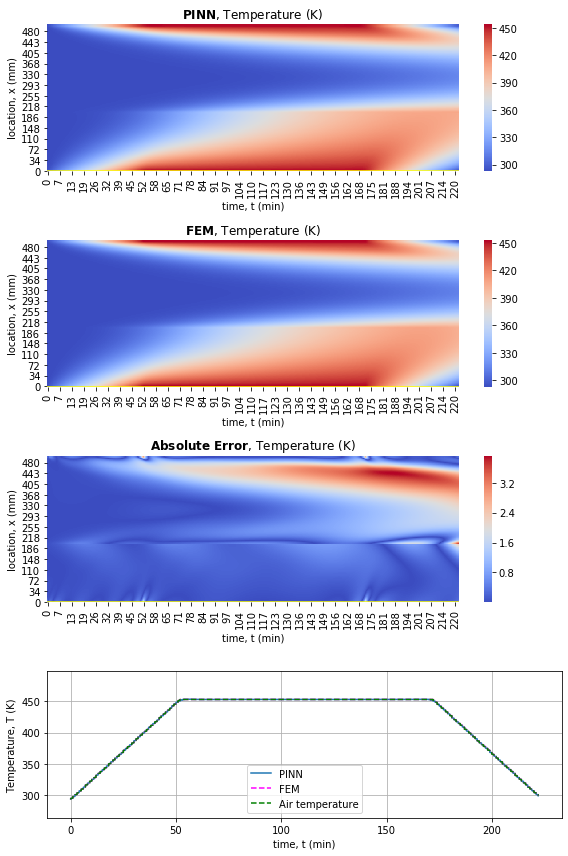

In [71]:
plot_test_T_RAVEN_x(0, T_RAVEN,x_T_RAVEN, t_T_RAVEN,
                    predictions_test_T_arr,predictions_test_T_df,
                    predictions_test_T_RAVEN_arr,predictions_test_TRAVEN_df)
plt.savefig('Results_Figures\_'+case_info_text_T + '_prediction.png') 

location is 0.2


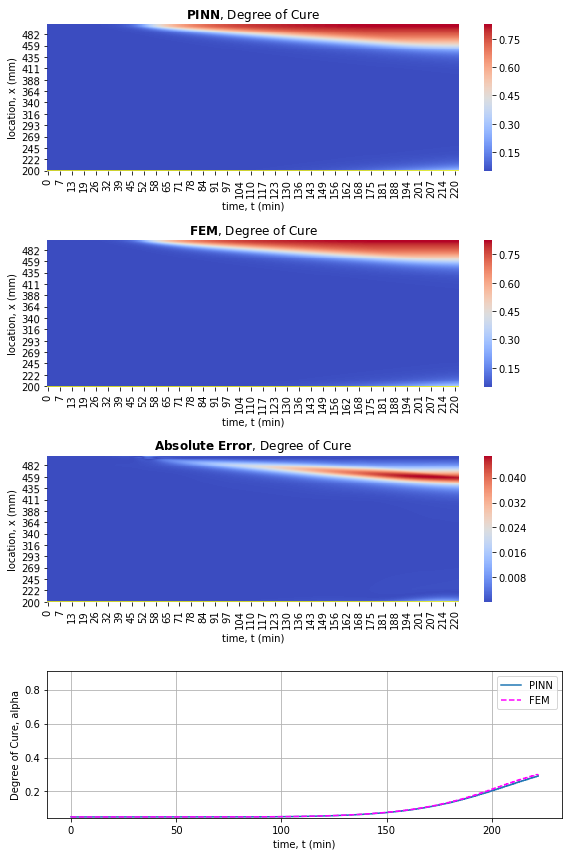

In [81]:
plot_test_alpha_RAVEN_x(0, alpha_RAVEN,x_alpha_RAVEN, t_alpha_RAVEN,
                        predictions_test_alpha_arr,predictions_test_alpha_df,
                        predictions_test_alpha_RAVEN_arr,predictions_test_alphaRAVEN_df)
plt.savefig('Results_Figures\_'+case_info_text_alpha + '_prediction.png') 